In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Golden Retriever Dog Emotions.zip to Golden Retriever Dog Emotions.zip


In [ ]:
import zipfile
import os

zip_filename = next(iter(uploaded))  # gets the uploaded file name
extract_path = '/content/dog_emotions'

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
image_paths = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))


In [ ]:
from collections import defaultdict
from pathlib import Path

label_to_images = defaultdict(list)
for path in image_paths:
    label = Path(path).parent.name
    label_to_images[label].append(path)


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

split_dir = '/content/dog_emotions_split'
os.makedirs(split_dir, exist_ok=True)

def copy_files(image_list, dest_dir):
    for path in image_list:
        label = Path(path).parent.name
        label_folder = os.path.join(dest_dir, label)
        os.makedirs(label_folder, exist_ok=True)
        shutil.copy2(path, os.path.join(label_folder, Path(path).name))

for label, paths in label_to_images.items():
    train_imgs, test_imgs = train_test_split(paths, train_size=0.8, random_state=42)
    copy_files(train_imgs, os.path.join(split_dir, 'train'))
    copy_files(test_imgs, os.path.join(split_dir, 'test'))

In [ ]:
shutil.make_archive('/content/dog_emotions_split', 'zip', split_dir)

'/content/dog_emotions_split.zip'

In [ ]:
import tensorflow as tf

# Define dataset paths
train_dir = "/content/dog_emotions_split/train"
test_dir = "/content/dog_emotions_split/test"

# Load datasets
batch_size = 32
img_size = (224, 224)  # Resize to match common models like ResNet, MobileNet

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

Found 720 files belonging to 3 classes.
Found 180 files belonging to 3 classes.


In [ ]:
# Normalize pixel values (0 to 1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 720 files belonging to 3 classes.


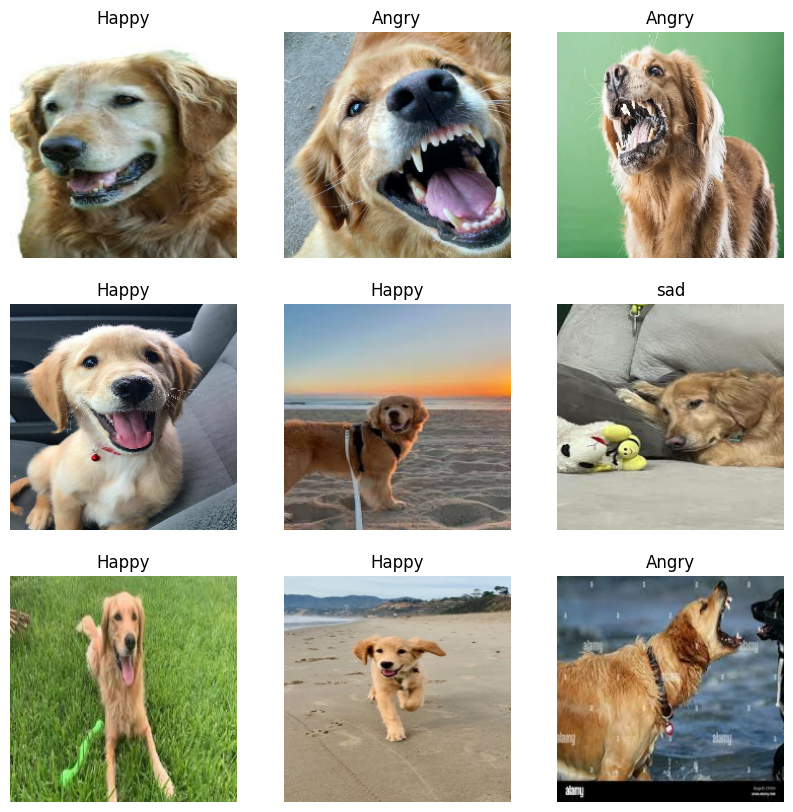

In [ ]:
import matplotlib.pyplot as plt

# Retrieve class names before applying .map()
train_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    "/content/dog_emotions_split/train",
    image_size=(224, 224),
    batch_size=32
)

class_names = train_dataset_raw.class_names  # Save class names

# Visualize images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset_raw.take(1):  # Take one batch
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to NumPy
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load MobileNetV2 without top layers
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False # Freeze base model

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Reduce feature map size
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),  # Prevent overfitting
    layers.Dense(len(class_names), activation="softmax") # Output layer
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Show model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Epochs

# CNN+LSTM


🔁 Fold 1
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3738 - loss: 1.0847 - val_accuracy: 0.7361 - val_loss: 1.0023 - learning_rate: 5.0000e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7521 - loss: 0.9153 - val_accuracy: 0.7500 - val_loss: 0.7289 - learning_rate: 5.0000e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8653 - loss: 0.5409 - val_accuracy: 0.7847 - val_loss: 0.4979 - learning_rate: 5.0000e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9309 - loss: 0.2736 - val_accuracy: 0.8611 - val_loss: 0.4289 - learning_rate: 5.0000e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9519 - loss: 0.1616 - val_accuracy: 0.8750 - val_loss: 0.4309 - learning_rate: 5.0000e-04
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9651 - loss: 0.1146 - val_accuracy: 0.8681 - val_loss: 0.4496 - learning_rate: 5.0000e-04
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.98

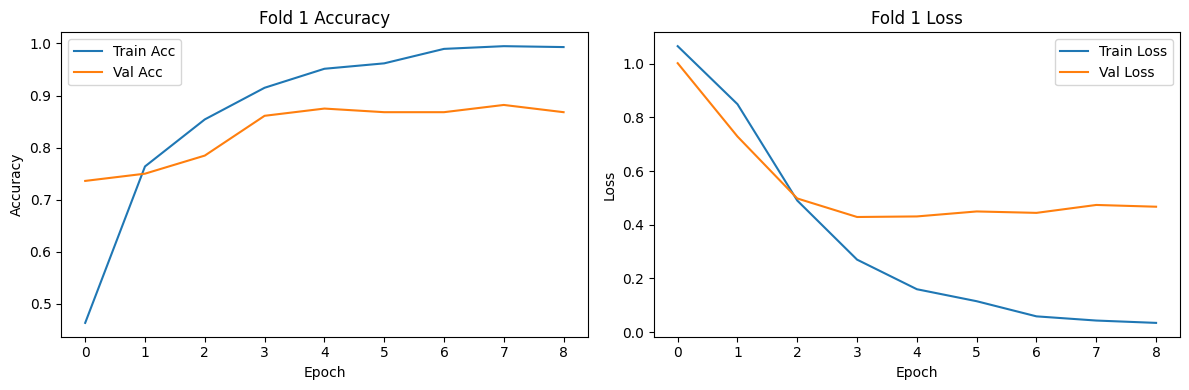


🔁 Fold 2
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3811 - loss: 1.0829 - val_accuracy: 0.7569 - val_loss: 0.9676 - learning_rate: 5.0000e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7593 - loss: 0.8894 - val_accuracy: 0.8264 - val_loss: 0.6258 - learning_rate: 5.0000e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8517 - loss: 0.5437 - val_accuracy: 0.8472 - val_loss: 0.4086 - learning_rate: 5.0000e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9011 - loss: 0.3232 - val_accuracy: 0.8611 - val_loss: 0.3469 - learning_rate: 5.0000e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9274 - loss: 0.1985 - val_accuracy: 0.8542 - val_loss: 0.3776 - learning_rate: 5.0000e-04
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9776 - loss: 0.1174 - val_accuracy: 0.8542 - val_loss: 0.4274 - learning_rate: 5.0000e-04
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.98

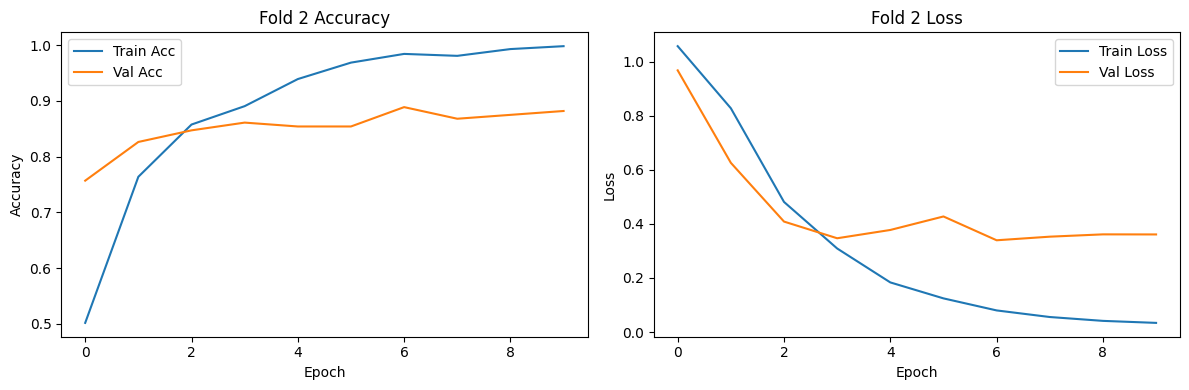


🔁 Fold 3
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4213 - loss: 1.0802 - val_accuracy: 0.7083 - val_loss: 0.9624 - learning_rate: 5.0000e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7255 - loss: 0.8975 - val_accuracy: 0.8333 - val_loss: 0.6080 - learning_rate: 5.0000e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8249 - loss: 0.5310 - val_accuracy: 0.8611 - val_loss: 0.3887 - learning_rate: 5.0000e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9210 - loss: 0.2590 - val_accuracy: 0.8681 - val_loss: 0.3038 - learning_rate: 5.0000e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9562 - loss: 0.1636 - val_accuracy: 0.8681 - val_loss: 0.3161 - learning_rate: 5.0000e-04
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9626 - loss: 0.1224 - val_accuracy: 0.8333 - val_loss: 0.4421 - learning_rate: 5.0000e-04
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.95

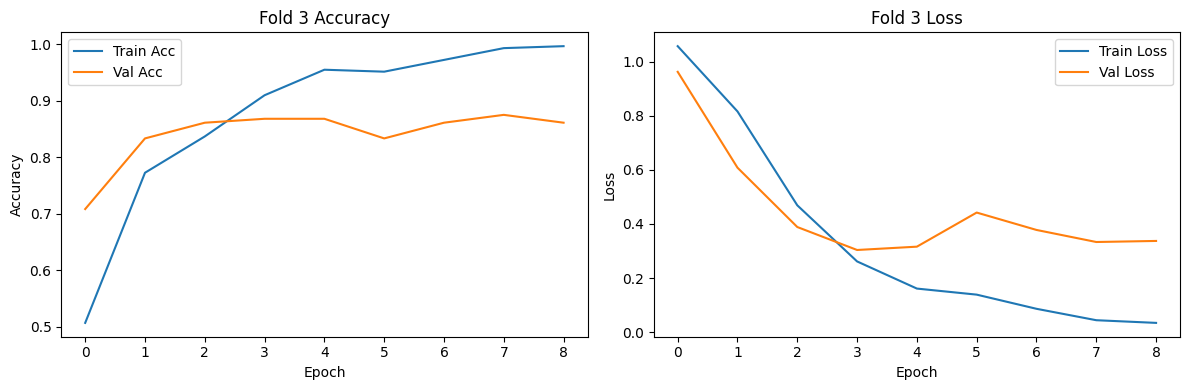


🔁 Fold 4
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4502 - loss: 1.0801 - val_accuracy: 0.7222 - val_loss: 0.9790 - learning_rate: 5.0000e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7716 - loss: 0.8838 - val_accuracy: 0.7639 - val_loss: 0.6506 - learning_rate: 5.0000e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8706 - loss: 0.5198 - val_accuracy: 0.7917 - val_loss: 0.5165 - learning_rate: 5.0000e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8766 - loss: 0.3536 - val_accuracy: 0.8264 - val_loss: 0.4018 - learning_rate: 5.0000e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9511 - loss: 0.1721 - val_accuracy: 0.8333 - val_loss: 0.4522 - learning_rate: 5.0000e-04
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9694 - loss: 0.1182 - val_accuracy: 0.8125 - val_loss: 0.5022 - learning_rate: 5.0000e-04
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.97

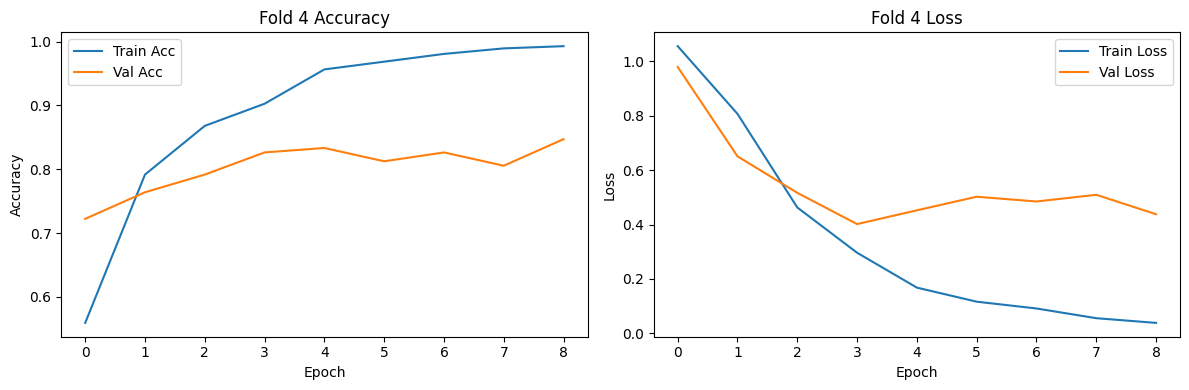


🔁 Fold 5
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4639 - loss: 1.0698 - val_accuracy: 0.7153 - val_loss: 0.9516 - learning_rate: 5.0000e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7795 - loss: 0.8725 - val_accuracy: 0.8125 - val_loss: 0.6274 - learning_rate: 5.0000e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8660 - loss: 0.5262 - val_accuracy: 0.8194 - val_loss: 0.4470 - learning_rate: 5.0000e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8778 - loss: 0.3309 - val_accuracy: 0.8750 - val_loss: 0.3450 - learning_rate: 5.0000e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9520 - loss: 0.1695 - val_accuracy: 0.8681 - val_loss: 0.3559 - learning_rate: 5.0000e-04
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9711 - loss: 0.1141 - val_accuracy: 0.8958 - val_loss: 0.3612 - learning_rate: 5.0000e-04
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.97

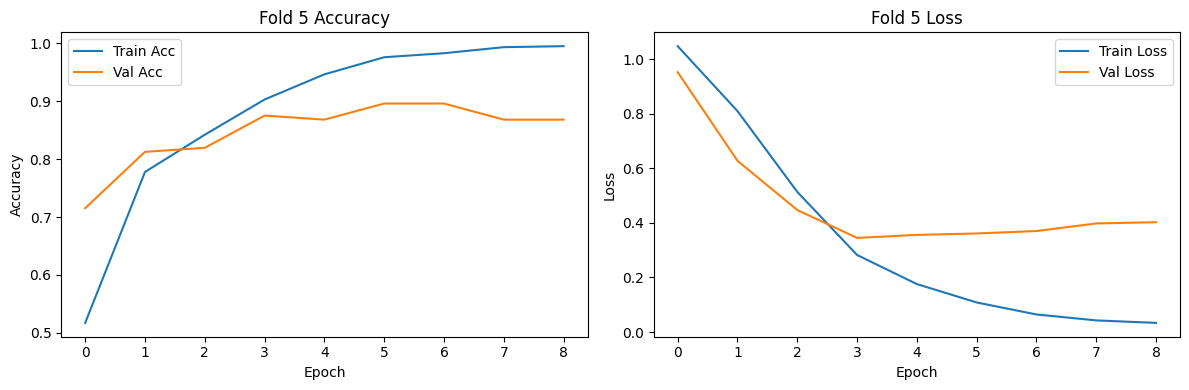


📊 Average Accuracy over 5 folds: 86.39%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 10
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")



🔁 Fold 1
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4672 - loss: 1.0762 - val_accuracy: 0.7639 - val_loss: 0.9755 - learning_rate: 5.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7903 - loss: 0.8786 - val_accuracy: 0.7917 - val_loss: 0.7073 - learning_rate: 5.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8398 - loss: 0.5469 - val_accuracy: 0.8194 - val_loss: 0.5117 - learning_rate: 5.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8949 - loss: 0.3032 - val_accuracy: 0.8819 - val_loss: 0.4045 - learning_rate: 5.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9278 - loss: 0.1879 - val_accuracy: 0.8681 - val_loss: 0.4088 - learning_rate: 5.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9495 - loss: 0.1374 - val_accuracy: 0.8611 - val_loss: 0.4636 - learning_rate: 5.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.98

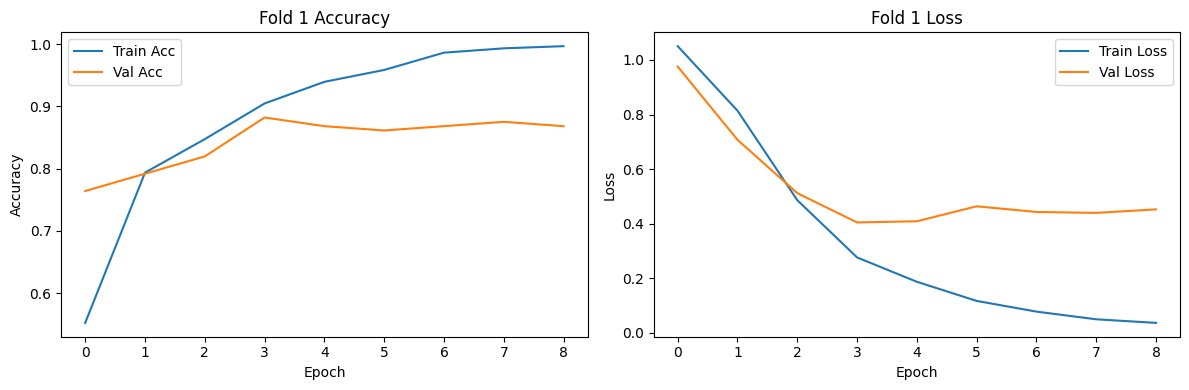


🔁 Fold 2
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4038 - loss: 1.0857 - val_accuracy: 0.7639 - val_loss: 0.9815 - learning_rate: 5.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7484 - loss: 0.8985 - val_accuracy: 0.8125 - val_loss: 0.6213 - learning_rate: 5.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8509 - loss: 0.5281 - val_accuracy: 0.7917 - val_loss: 0.4939 - learning_rate: 5.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9078 - loss: 0.2953 - val_accuracy: 0.8611 - val_loss: 0.3755 - learning_rate: 5.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9532 - loss: 0.1713 - val_accuracy: 0.8542 - val_loss: 0.3749 - learning_rate: 5.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9513 - loss: 0.1188 - val_accuracy: 0.8681 - val_loss: 0.3757 - learning_rate: 5.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.97

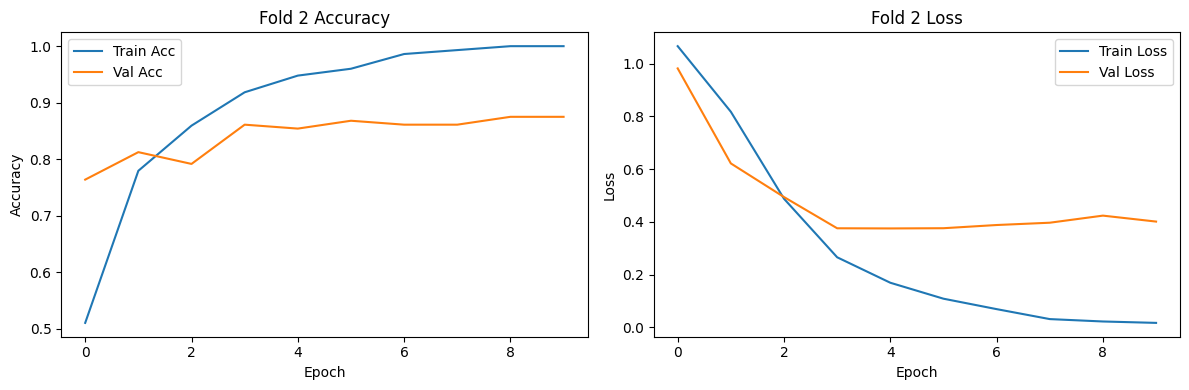


🔁 Fold 3
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3985 - loss: 1.0839 - val_accuracy: 0.7014 - val_loss: 1.0003 - learning_rate: 5.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7427 - loss: 0.9213 - val_accuracy: 0.7569 - val_loss: 0.6646 - learning_rate: 5.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8148 - loss: 0.5702 - val_accuracy: 0.8264 - val_loss: 0.3956 - learning_rate: 5.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8933 - loss: 0.3012 - val_accuracy: 0.8333 - val_loss: 0.3399 - learning_rate: 5.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9484 - loss: 0.2041 - val_accuracy: 0.8403 - val_loss: 0.4163 - learning_rate: 5.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9414 - loss: 0.1686 - val_accuracy: 0.8403 - val_loss: 0.3378 - learning_rate: 5.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.96

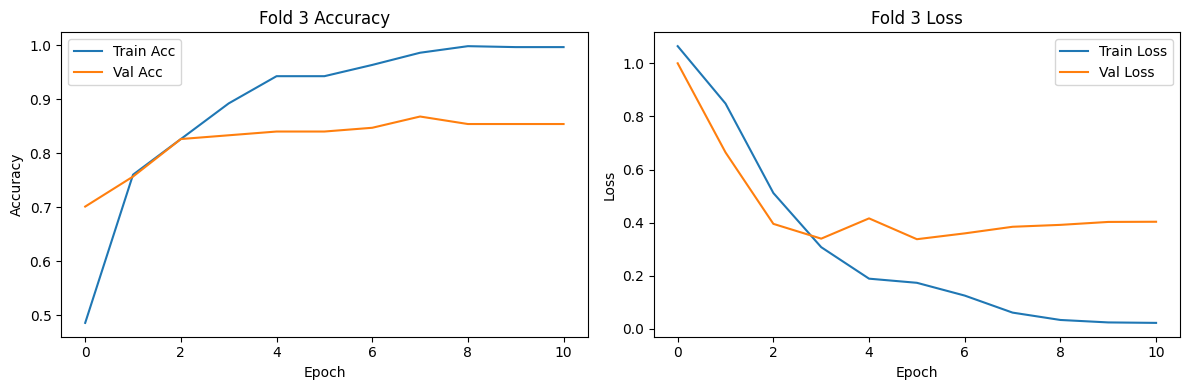


🔁 Fold 4
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4132 - loss: 1.0820 - val_accuracy: 0.7292 - val_loss: 0.9808 - learning_rate: 5.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7924 - loss: 0.8710 - val_accuracy: 0.7917 - val_loss: 0.6350 - learning_rate: 5.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8750 - loss: 0.4854 - val_accuracy: 0.8333 - val_loss: 0.4543 - learning_rate: 5.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9222 - loss: 0.2770 - val_accuracy: 0.8542 - val_loss: 0.4139 - learning_rate: 5.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9762 - loss: 0.1180 - val_accuracy: 0.8403 - val_loss: 0.4296 - learning_rate: 5.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9760 - loss: 0.1082 - val_accuracy: 0.8194 - val_loss: 0.5051 - learning_rate: 5.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.98

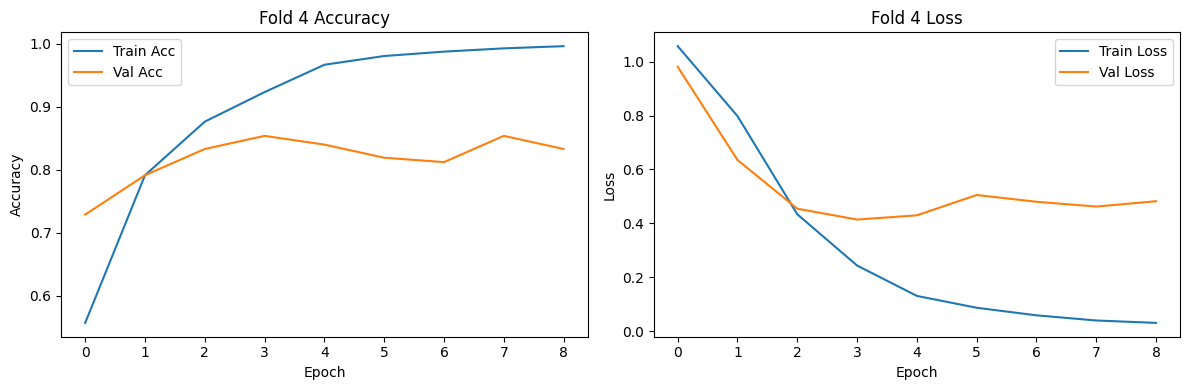


🔁 Fold 5
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3956 - loss: 1.0845 - val_accuracy: 0.6806 - val_loss: 0.9833 - learning_rate: 5.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7363 - loss: 0.9054 - val_accuracy: 0.8194 - val_loss: 0.6611 - learning_rate: 5.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8451 - loss: 0.5467 - val_accuracy: 0.8750 - val_loss: 0.3853 - learning_rate: 5.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9113 - loss: 0.3169 - val_accuracy: 0.8472 - val_loss: 0.3645 - learning_rate: 5.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9352 - loss: 0.2034 - val_accuracy: 0.8958 - val_loss: 0.3640 - learning_rate: 5.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9465 - loss: 0.1489 - val_accuracy: 0.8889 - val_loss: 0.3701 - learning_rate: 5.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.98

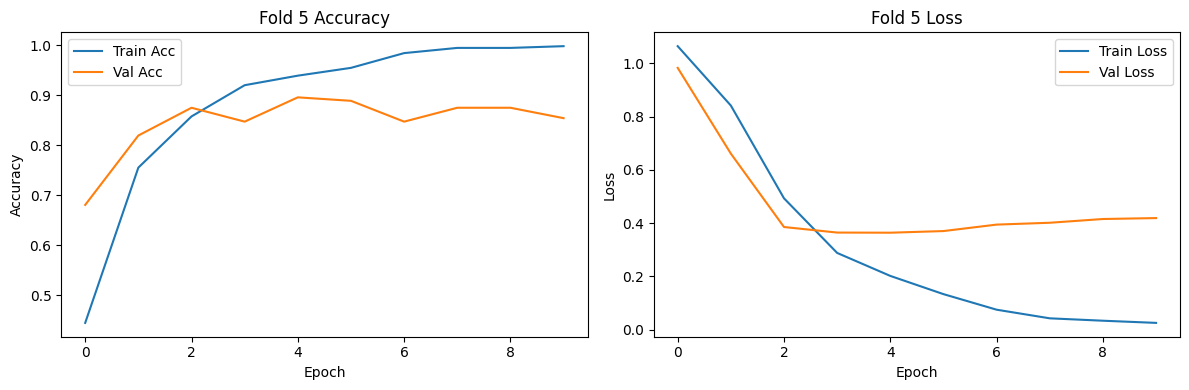


📊 Average Accuracy over 5 folds: 86.53%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 20
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")



🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4807 - loss: 1.0754 - val_accuracy: 0.7431 - val_loss: 0.9720 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7952 - loss: 0.8689 - val_accuracy: 0.7917 - val_loss: 0.6678 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8347 - loss: 0.5093 - val_accuracy: 0.7847 - val_loss: 0.5197 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9275 - loss: 0.2571 - val_accuracy: 0.8681 - val_loss: 0.4399 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9658 - loss: 0.1516 - val_accuracy: 0.8889 - val_loss: 0.4043 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9828 - loss: 0.0745 - val_accuracy: 0.8750 - val_loss: 0.4523 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.99

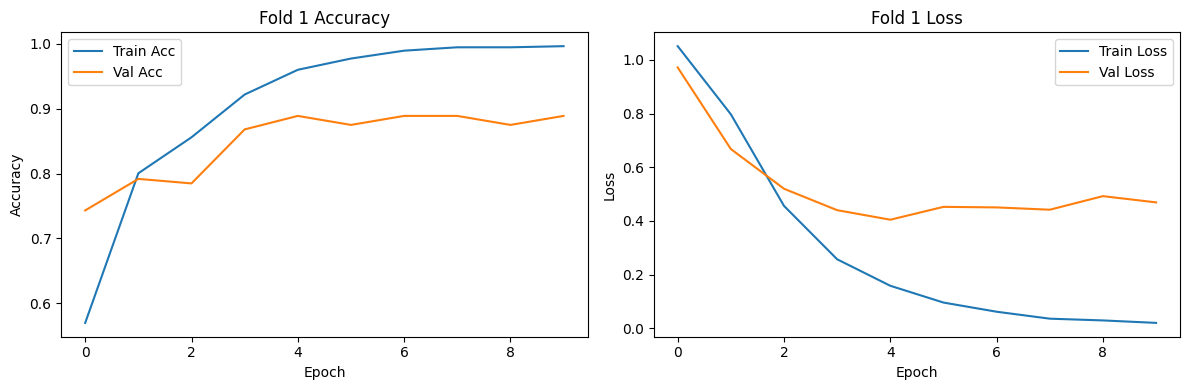


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5106 - loss: 1.0713 - val_accuracy: 0.7847 - val_loss: 0.9376 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7570 - loss: 0.8635 - val_accuracy: 0.7847 - val_loss: 0.6356 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.8562 - loss: 0.5171 - val_accuracy: 0.8125 - val_loss: 0.4458 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9161 - loss: 0.3134 - val_accuracy: 0.8681 - val_loss: 0.3679 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9468 - loss: 0.1680 - val_accuracy: 0.8750 - val_loss: 0.3591 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9674 - loss: 0.1105 - val_accuracy: 0.8819 - val_loss: 0.3434 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.99

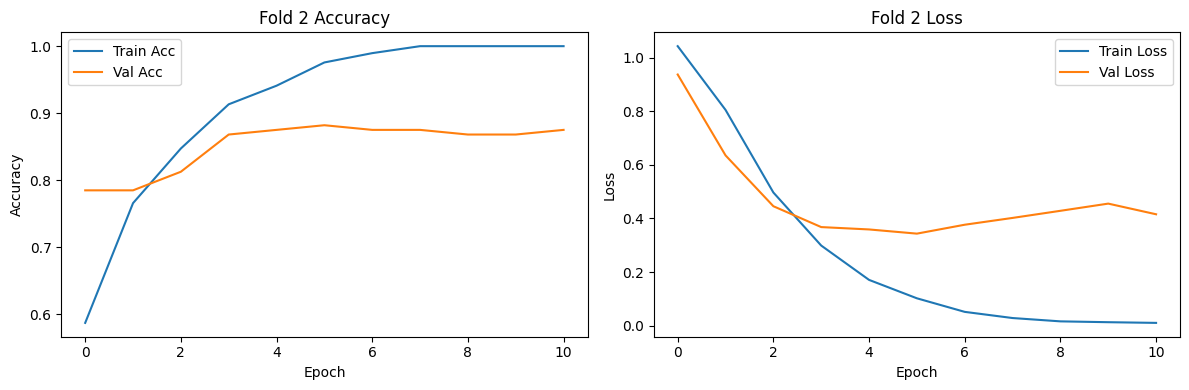


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5338 - loss: 1.0780 - val_accuracy: 0.7639 - val_loss: 0.9539 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7655 - loss: 0.8927 - val_accuracy: 0.7917 - val_loss: 0.6129 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8632 - loss: 0.4923 - val_accuracy: 0.8681 - val_loss: 0.3652 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8905 - loss: 0.3060 - val_accuracy: 0.8681 - val_loss: 0.3051 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9512 - loss: 0.1695 - val_accuracy: 0.8611 - val_loss: 0.3730 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9668 - loss: 0.1023 - val_accuracy: 0.8472 - val_loss: 0.4121 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.97

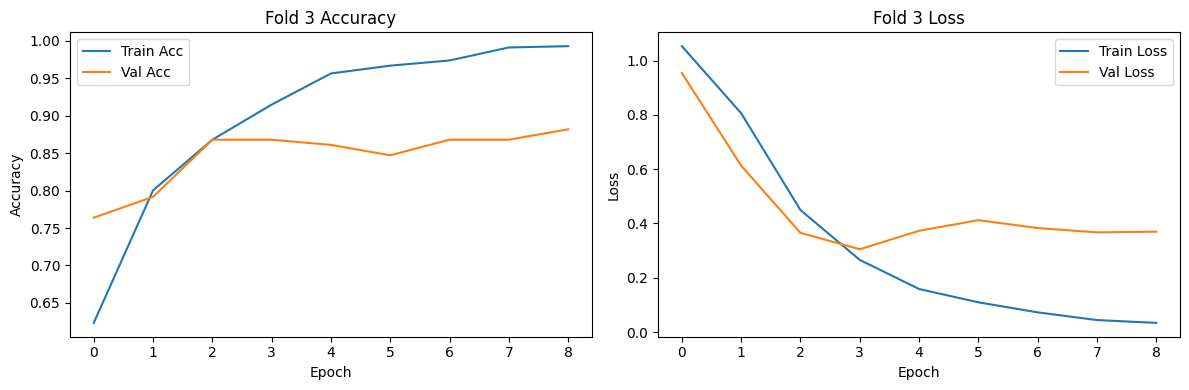


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4970 - loss: 1.0715 - val_accuracy: 0.7292 - val_loss: 0.9424 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7582 - loss: 0.8447 - val_accuracy: 0.7639 - val_loss: 0.6280 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8813 - loss: 0.4640 - val_accuracy: 0.8125 - val_loss: 0.4438 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8968 - loss: 0.2875 - val_accuracy: 0.7986 - val_loss: 0.4486 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9684 - loss: 0.1518 - val_accuracy: 0.8333 - val_loss: 0.4445 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9793 - loss: 0.1012 - val_accuracy: 0.8194 - val_loss: 0.4504 - learning_rate: 2.5000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.98

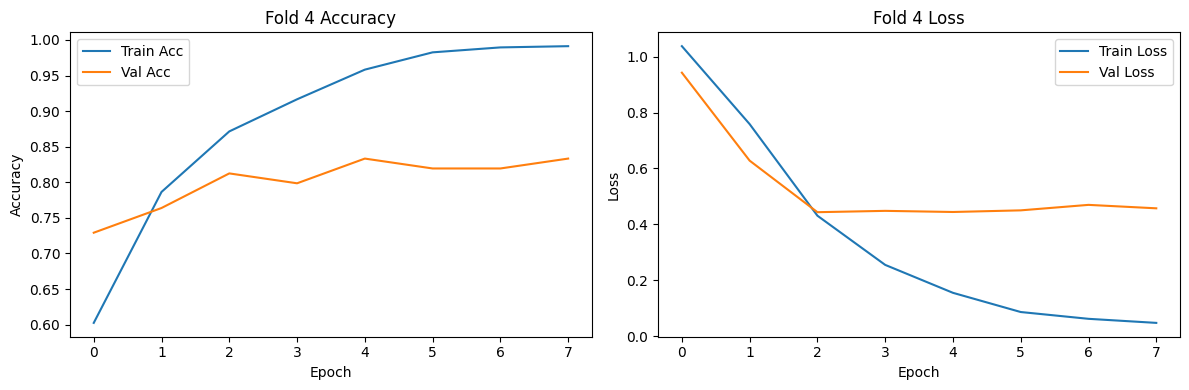


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5197 - loss: 1.0730 - val_accuracy: 0.7639 - val_loss: 0.9398 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7759 - loss: 0.8559 - val_accuracy: 0.8194 - val_loss: 0.6084 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8418 - loss: 0.5454 - val_accuracy: 0.8750 - val_loss: 0.3736 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8884 - loss: 0.3156 - val_accuracy: 0.8889 - val_loss: 0.3039 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9536 - loss: 0.1746 - val_accuracy: 0.8750 - val_loss: 0.3033 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9719 - loss: 0.1211 - val_accuracy: 0.8958 - val_loss: 0.3292 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.98

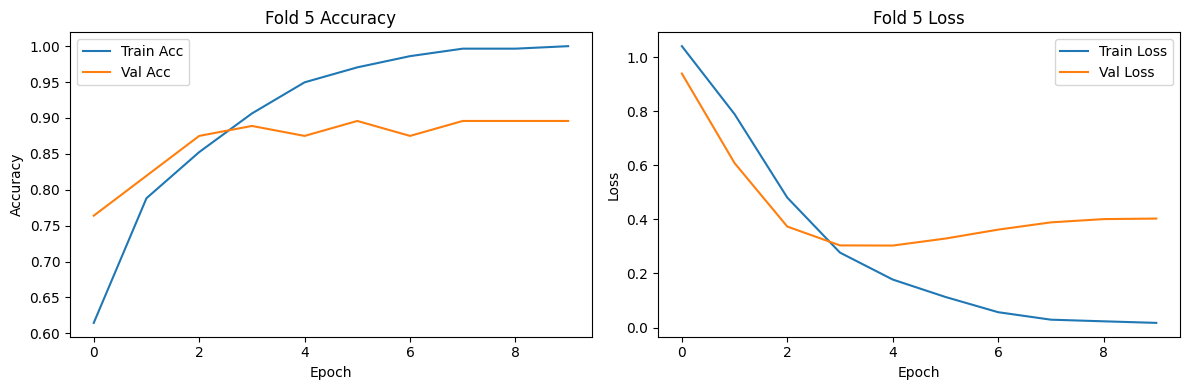


📊 Average Accuracy over 5 folds: 86.53%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4090 - loss: 1.0825 - val_accuracy: 0.7153 - val_loss: 0.9811 - learning_rate: 5.0000e-04
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7538 - loss: 0.8858 - val_accuracy: 0.7708 - val_loss: 0.6504 - learning_rate: 5.0000e-04
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8457 - loss: 0.5106 - val_accuracy: 0.7847 - val_loss: 0.4980 - learning_rate: 5.0000e-04
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9186 - loss: 0.2774 - val_accuracy: 0.8472 - val_loss: 0.4271 - learning_rate: 5.0000e-04
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9508 - loss: 0.1357 - val_accuracy: 0.8264 - val_loss: 0.4979 - learning_rate: 5.0000e-04
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9743 - loss: 0.1252 - val_accuracy: 0.9097 - val_loss: 0.3921 - learning_rate: 5.0000e-04
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.98

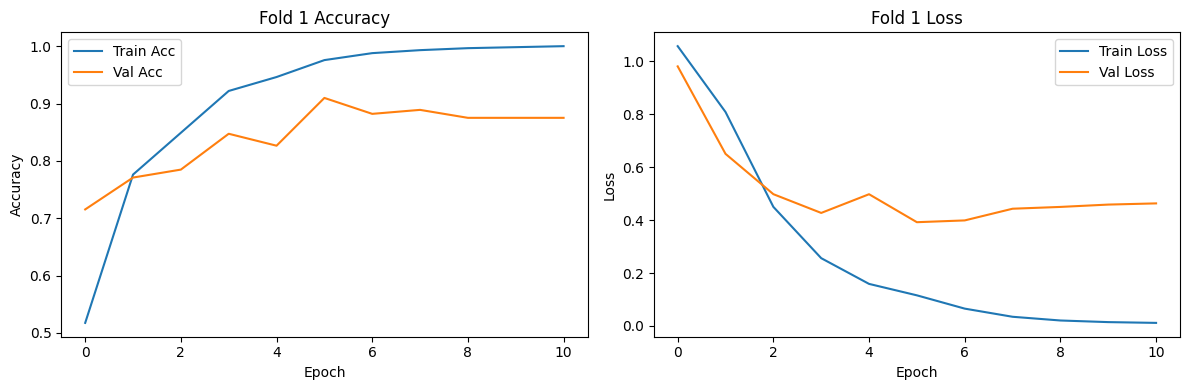


🔁 Fold 2
Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4074 - loss: 1.0781 - val_accuracy: 0.7500 - val_loss: 0.9769 - learning_rate: 5.0000e-04
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7690 - loss: 0.9020 - val_accuracy: 0.7847 - val_loss: 0.6861 - learning_rate: 5.0000e-04
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8572 - loss: 0.5629 - val_accuracy: 0.8194 - val_loss: 0.5139 - learning_rate: 5.0000e-04
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9136 - loss: 0.2885 - val_accuracy: 0.8750 - val_loss: 0.3682 - learning_rate: 5.0000e-04
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9525 - loss: 0.1720 - val_accuracy: 0.8333 - val_loss: 0.4510 - learning_rate: 5.0000e-04
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9583 - loss: 0.1313 - val_accuracy: 0.8611 - val_loss: 0.4403 - learning_rate: 5.0000e-04
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.98

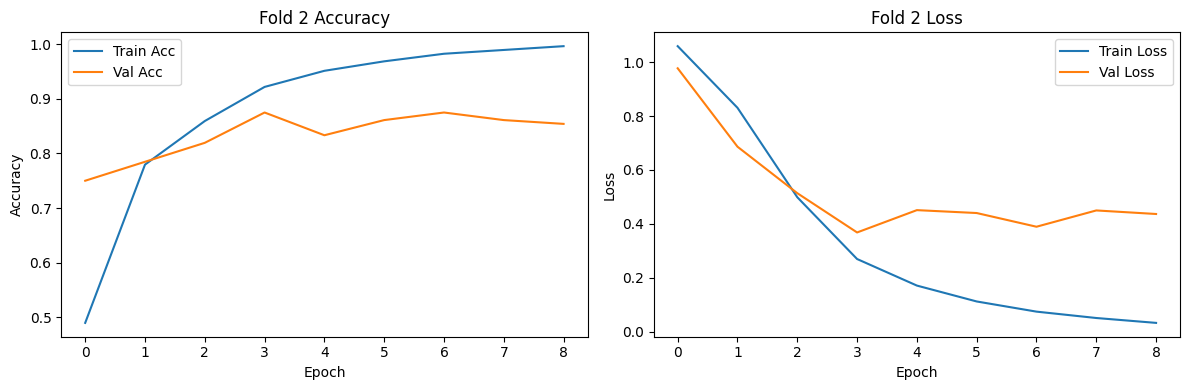


🔁 Fold 3
Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4690 - loss: 1.0760 - val_accuracy: 0.7431 - val_loss: 0.9503 - learning_rate: 5.0000e-04
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7578 - loss: 0.8631 - val_accuracy: 0.8264 - val_loss: 0.5884 - learning_rate: 5.0000e-04
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8366 - loss: 0.5116 - val_accuracy: 0.8472 - val_loss: 0.3829 - learning_rate: 5.0000e-04
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9140 - loss: 0.2761 - val_accuracy: 0.8958 - val_loss: 0.3065 - learning_rate: 5.0000e-04
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9345 - loss: 0.1972 - val_accuracy: 0.8681 - val_loss: 0.2939 - learning_rate: 5.0000e-04
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9496 - loss: 0.1707 - val_accuracy: 0.8403 - val_loss: 0.3880 - learning_rate: 5.0000e-04
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.96

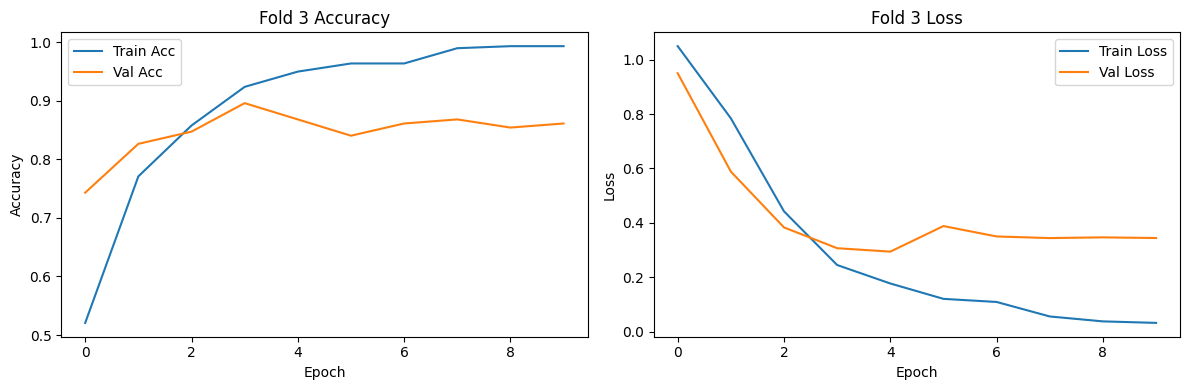


🔁 Fold 4
Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4347 - loss: 1.0767 - val_accuracy: 0.7708 - val_loss: 0.9523 - learning_rate: 5.0000e-04
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7887 - loss: 0.8527 - val_accuracy: 0.8194 - val_loss: 0.6255 - learning_rate: 5.0000e-04
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8564 - loss: 0.4939 - val_accuracy: 0.8056 - val_loss: 0.4787 - learning_rate: 5.0000e-04
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9199 - loss: 0.2436 - val_accuracy: 0.8403 - val_loss: 0.4225 - learning_rate: 5.0000e-04
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9506 - loss: 0.1587 - val_accuracy: 0.7917 - val_loss: 0.5482 - learning_rate: 5.0000e-04
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9733 - loss: 0.0914 - val_accuracy: 0.8264 - val_loss: 0.4904 - learning_rate: 5.0000e-04
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.99

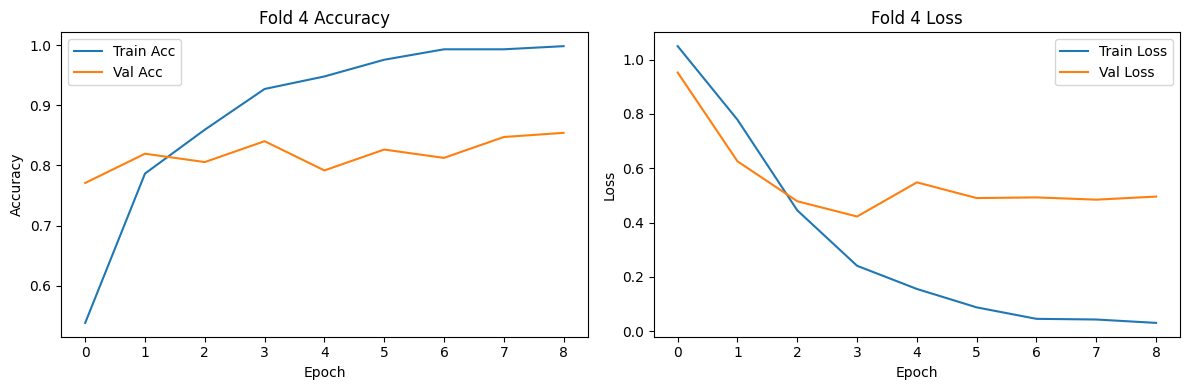


🔁 Fold 5
Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4763 - loss: 1.0698 - val_accuracy: 0.6181 - val_loss: 0.9439 - learning_rate: 5.0000e-04
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7011 - loss: 0.8616 - val_accuracy: 0.7917 - val_loss: 0.6072 - learning_rate: 5.0000e-04
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8666 - loss: 0.4991 - val_accuracy: 0.8472 - val_loss: 0.4071 - learning_rate: 5.0000e-04
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9071 - loss: 0.2915 - val_accuracy: 0.8264 - val_loss: 0.3838 - learning_rate: 5.0000e-04
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9577 - loss: 0.1729 - val_accuracy: 0.8472 - val_loss: 0.4051 - learning_rate: 5.0000e-04
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9601 - loss: 0.1210 - val_accuracy: 0.8819 - val_loss: 0.4703 - learning_rate: 5.0000e-04
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.98

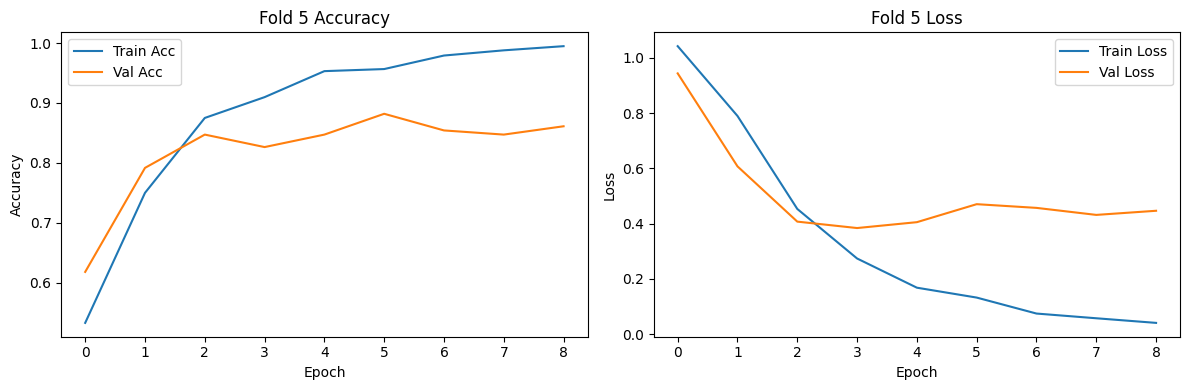


📊 Average Accuracy over 5 folds: 86.39%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 40
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4760 - loss: 1.0793 - val_accuracy: 0.7500 - val_loss: 0.9823 - learning_rate: 5.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8077 - loss: 0.8733 - val_accuracy: 0.7153 - val_loss: 0.6984 - learning_rate: 5.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8596 - loss: 0.5118 - val_accuracy: 0.8125 - val_loss: 0.5212 - learning_rate: 5.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8954 - loss: 0.2796 - val_accuracy: 0.8333 - val_loss: 0.4790 - learning_rate: 5.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9334 - loss: 0.1946 - val_accuracy: 0.8750 - val_loss: 0.4413 - learning_rate: 5.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9713 - loss: 0.1159 - val_accuracy: 0.8542 - val_loss: 0.4360 - learning_rate: 5.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.97

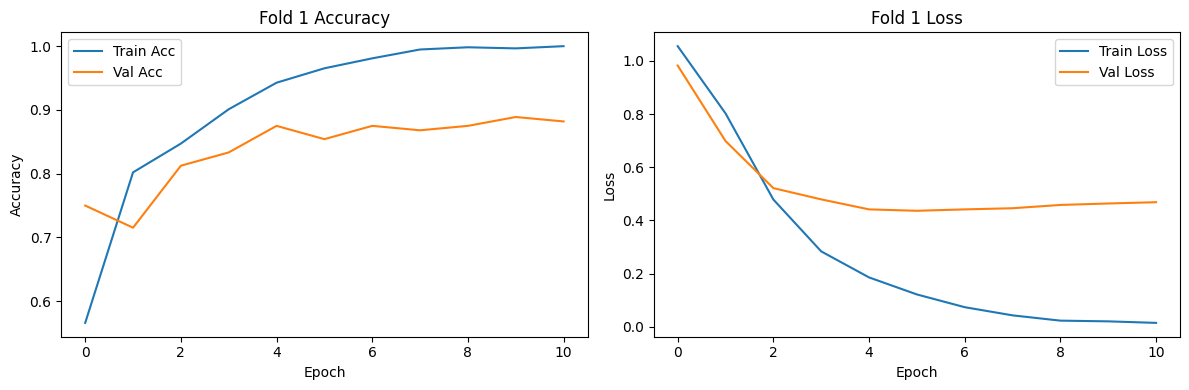


🔁 Fold 2
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3816 - loss: 1.0870 - val_accuracy: 0.7292 - val_loss: 1.0093 - learning_rate: 5.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7333 - loss: 0.9508 - val_accuracy: 0.7431 - val_loss: 0.7365 - learning_rate: 5.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8111 - loss: 0.6378 - val_accuracy: 0.8681 - val_loss: 0.4624 - learning_rate: 5.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8919 - loss: 0.3498 - val_accuracy: 0.8611 - val_loss: 0.3817 - learning_rate: 5.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9410 - loss: 0.2137 - val_accuracy: 0.8611 - val_loss: 0.3676 - learning_rate: 5.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9656 - loss: 0.1274 - val_accuracy: 0.8750 - val_loss: 0.3727 - learning_rate: 5.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.99

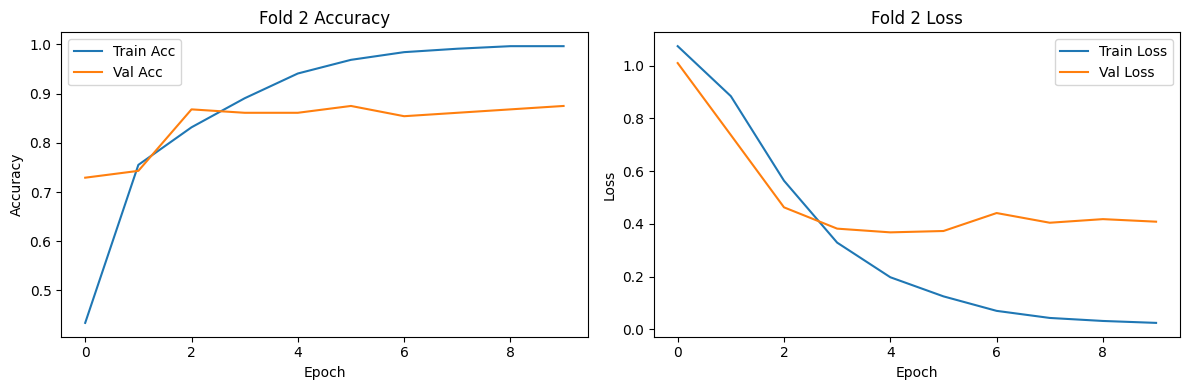


🔁 Fold 3
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5299 - loss: 1.0745 - val_accuracy: 0.7986 - val_loss: 0.9193 - learning_rate: 5.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8358 - loss: 0.8254 - val_accuracy: 0.8403 - val_loss: 0.5625 - learning_rate: 5.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8573 - loss: 0.4762 - val_accuracy: 0.8542 - val_loss: 0.3710 - learning_rate: 5.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9172 - loss: 0.2914 - val_accuracy: 0.8681 - val_loss: 0.3462 - learning_rate: 5.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9533 - loss: 0.1709 - val_accuracy: 0.8681 - val_loss: 0.3235 - learning_rate: 5.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9617 - loss: 0.1237 - val_accuracy: 0.8472 - val_loss: 0.3259 - learning_rate: 5.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.98

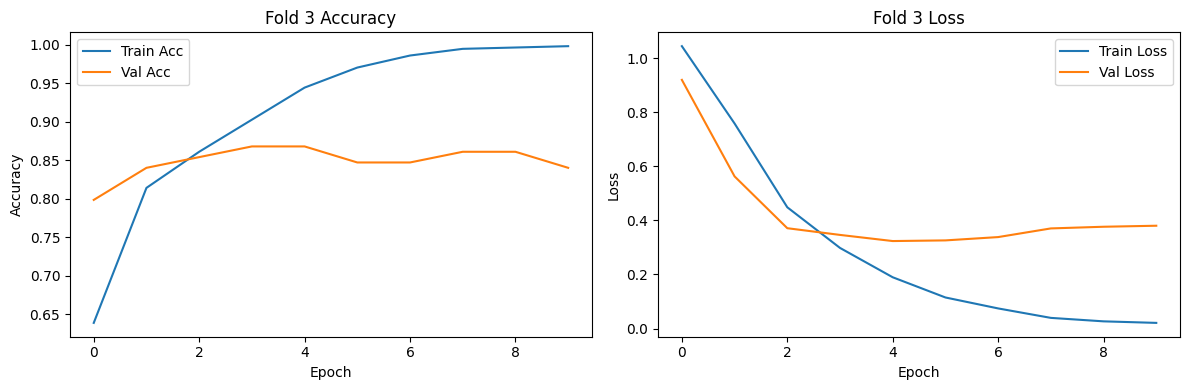


🔁 Fold 4
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4581 - loss: 1.0776 - val_accuracy: 0.6806 - val_loss: 0.9630 - learning_rate: 5.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7525 - loss: 0.8690 - val_accuracy: 0.7778 - val_loss: 0.6590 - learning_rate: 5.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8407 - loss: 0.5132 - val_accuracy: 0.8056 - val_loss: 0.4790 - learning_rate: 5.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9074 - loss: 0.3081 - val_accuracy: 0.8194 - val_loss: 0.4093 - learning_rate: 5.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9616 - loss: 0.1605 - val_accuracy: 0.8264 - val_loss: 0.4090 - learning_rate: 5.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9795 - loss: 0.1011 - val_accuracy: 0.8194 - val_loss: 0.4923 - learning_rate: 5.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.98

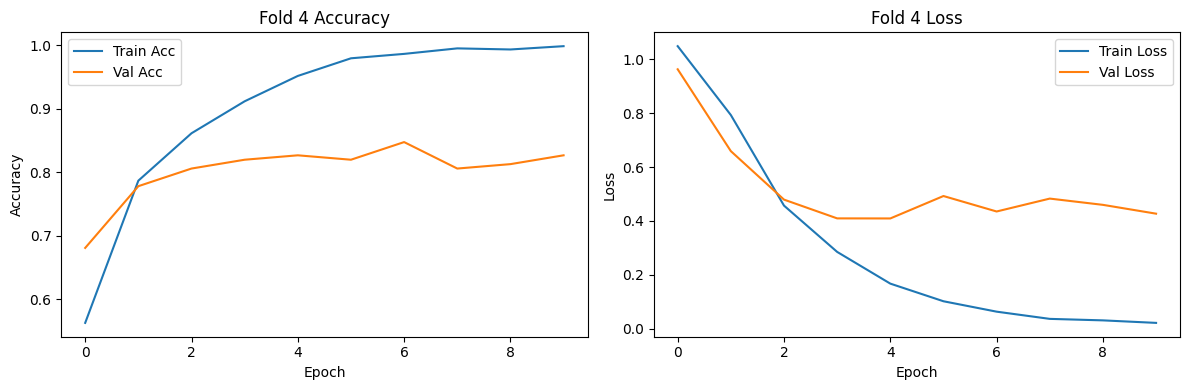


🔁 Fold 5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5273 - loss: 1.0782 - val_accuracy: 0.7708 - val_loss: 0.9615 - learning_rate: 5.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8300 - loss: 0.8796 - val_accuracy: 0.8125 - val_loss: 0.6095 - learning_rate: 5.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8692 - loss: 0.4793 - val_accuracy: 0.8403 - val_loss: 0.3911 - learning_rate: 5.0000e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8919 - loss: 0.3222 - val_accuracy: 0.8681 - val_loss: 0.3241 - learning_rate: 5.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9194 - loss: 0.2514 - val_accuracy: 0.8542 - val_loss: 0.3554 - learning_rate: 5.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9511 - loss: 0.1479 - val_accuracy: 0.8958 - val_loss: 0.4149 - learning_rate: 5.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.97

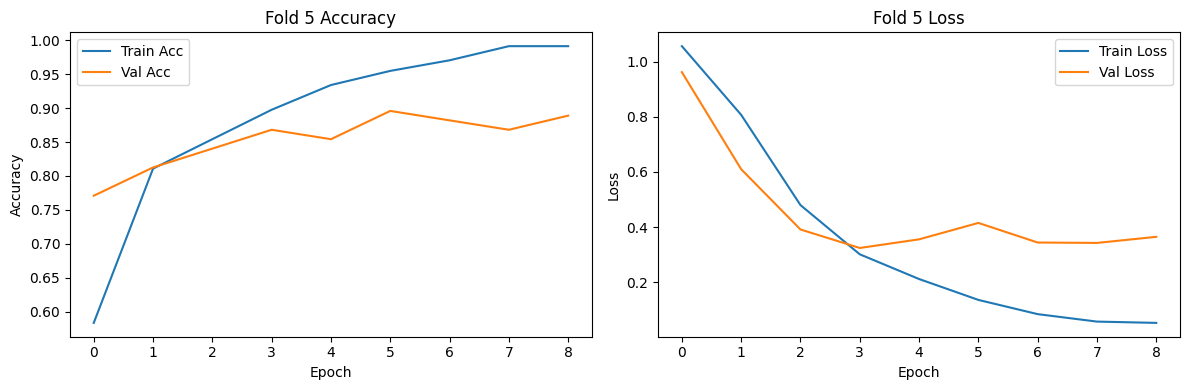


📊 Average Accuracy over 5 folds: 85.56%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 50
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")

# Learning Rate


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3465 - loss: 1.0988 - val_accuracy: 0.5694 - val_loss: 1.0881 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5584 - loss: 1.0773 - val_accuracy: 0.6111 - val_loss: 1.0683 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6232 - loss: 1.0503 - val_accuracy: 0.7014 - val_loss: 1.0320 - learning_rate: 1.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.6726 - loss: 0.9984 - val_accuracy: 0.7361 - val_loss: 0.9735 - learning_rate: 1.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7536 - loss: 0.9177 - val_accuracy: 0.7500 - val_loss: 0.8854 - learning_rate: 1.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7937 - loss: 0.7997 - val_accuracy: 0.7569 - val_loss: 0.7851 - learning_rate: 1.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.83

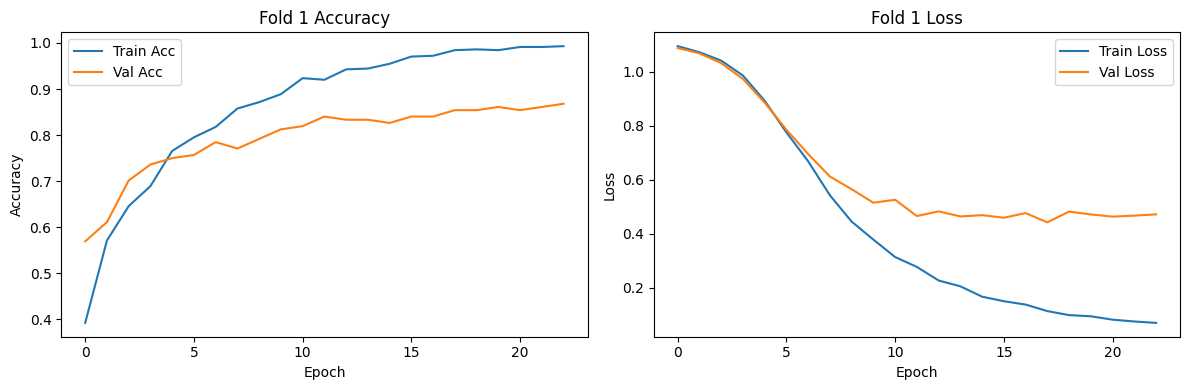


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3192 - loss: 1.0981 - val_accuracy: 0.5139 - val_loss: 1.0822 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5422 - loss: 1.0723 - val_accuracy: 0.5764 - val_loss: 1.0538 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.6072 - loss: 1.0443 - val_accuracy: 0.7153 - val_loss: 1.0052 - learning_rate: 1.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7324 - loss: 0.9800 - val_accuracy: 0.7639 - val_loss: 0.9286 - learning_rate: 1.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8027 - loss: 0.8908 - val_accuracy: 0.8056 - val_loss: 0.8311 - learning_rate: 1.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8327 - loss: 0.7764 - val_accuracy: 0.8194 - val_loss: 0.7201 - learning_rate: 1.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.84

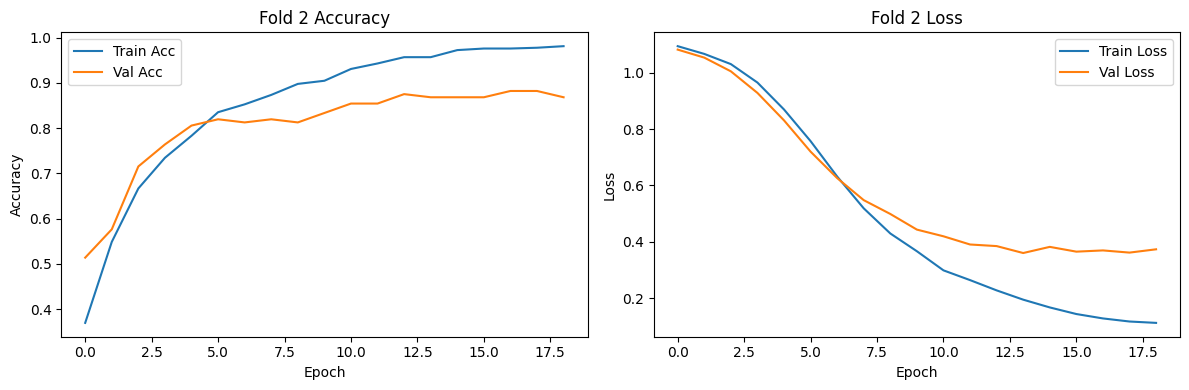


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4051 - loss: 1.0947 - val_accuracy: 0.5903 - val_loss: 1.0817 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5735 - loss: 1.0771 - val_accuracy: 0.6736 - val_loss: 1.0549 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6664 - loss: 1.0462 - val_accuracy: 0.7014 - val_loss: 1.0131 - learning_rate: 1.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7627 - loss: 0.9945 - val_accuracy: 0.7708 - val_loss: 0.9428 - learning_rate: 1.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8019 - loss: 0.9185 - val_accuracy: 0.7917 - val_loss: 0.8480 - learning_rate: 1.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8419 - loss: 0.7998 - val_accuracy: 0.8125 - val_loss: 0.7409 - learning_rate: 1.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.84

4/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step

✅ Fold 3 Accuracy: 86.11%

🧾 Classification Report:
              precision    recall  f1-score   support

       Angry     0.8333    0.8333    0.8333        48
       Happy     0.8431    0.8958    0.8687        48
         sad     0.9111    0.8542    0.8817        48

    accuracy                         0.8611       144
   macro avg     0.8625    0.8611    0.8612       144
weighted avg     0.8625    0.8611    0.8612       144



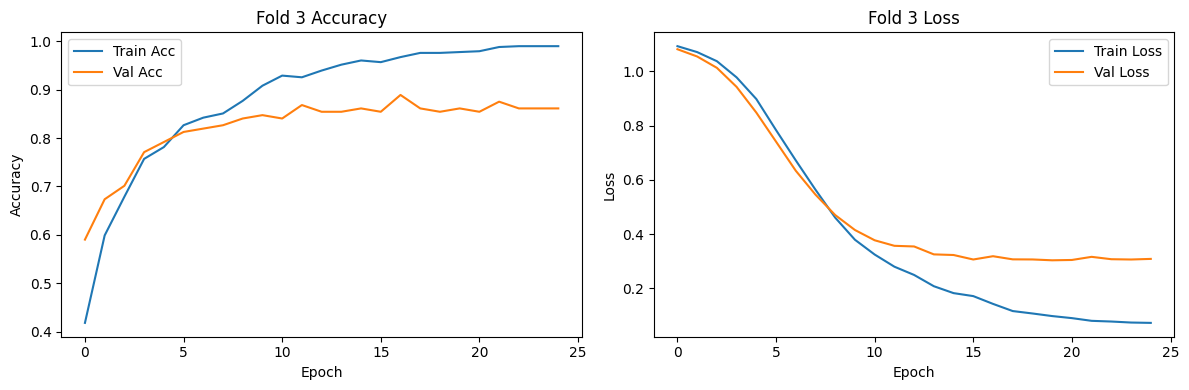


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3551 - loss: 1.0977 - val_accuracy: 0.4931 - val_loss: 1.0835 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5220 - loss: 1.0726 - val_accuracy: 0.5972 - val_loss: 1.0594 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6052 - loss: 1.0441 - val_accuracy: 0.7361 - val_loss: 1.0203 - learning_rate: 1.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7247 - loss: 0.9838 - val_accuracy: 0.7361 - val_loss: 0.9586 - learning_rate: 1.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8260 - loss: 0.9068 - val_accuracy: 0.7292 - val_loss: 0.8763 - learning_rate: 1.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8184 - loss: 0.8042 - val_accuracy: 0.7569 - val_loss: 0.7756 - learning_rate: 1.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.85

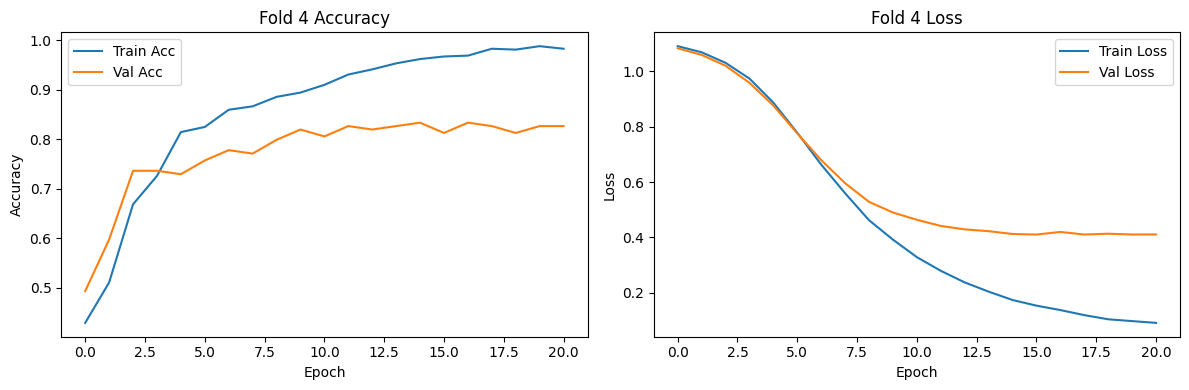


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3725 - loss: 1.0940 - val_accuracy: 0.5764 - val_loss: 1.0792 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5884 - loss: 1.0701 - val_accuracy: 0.7361 - val_loss: 1.0481 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7127 - loss: 1.0284 - val_accuracy: 0.7778 - val_loss: 0.9959 - learning_rate: 1.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7861 - loss: 0.9622 - val_accuracy: 0.8125 - val_loss: 0.9146 - learning_rate: 1.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8176 - loss: 0.8743 - val_accuracy: 0.8125 - val_loss: 0.8060 - learning_rate: 1.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8448 - loss: 0.7380 - val_accuracy: 0.7986 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.85

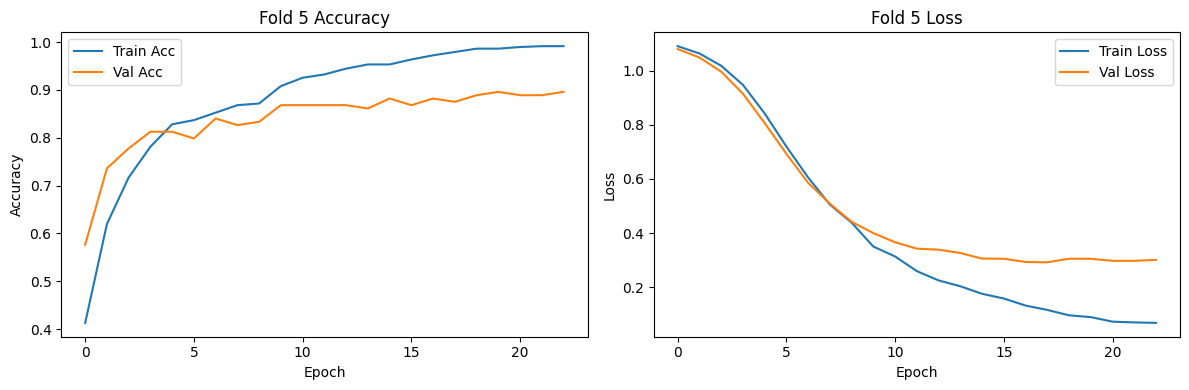


📊 Average Accuracy over 5 folds: 85.42%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4114 - loss: 1.0906 - val_accuracy: 0.6319 - val_loss: 1.0611 - learning_rate: 2.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7362 - loss: 1.0291 - val_accuracy: 0.7292 - val_loss: 0.9742 - learning_rate: 2.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7805 - loss: 0.9098 - val_accuracy: 0.7361 - val_loss: 0.8268 - learning_rate: 2.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8066 - loss: 0.7094 - val_accuracy: 0.7917 - val_loss: 0.6587 - learning_rate: 2.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8533 - loss: 0.5302 - val_accuracy: 0.8056 - val_loss: 0.5558 - learning_rate: 2.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8787 - loss: 0.3795 - val_accuracy: 0.7847 - val_loss: 0.5012 - learning_rate: 2.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.92

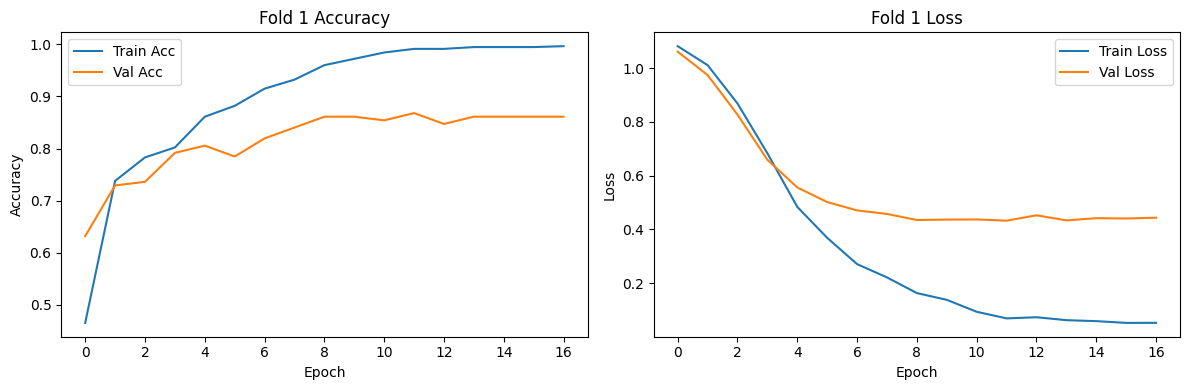


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4492 - loss: 1.0888 - val_accuracy: 0.6875 - val_loss: 1.0571 - learning_rate: 2.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6688 - loss: 1.0385 - val_accuracy: 0.7708 - val_loss: 0.9677 - learning_rate: 2.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7806 - loss: 0.9185 - val_accuracy: 0.7847 - val_loss: 0.8064 - learning_rate: 2.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7988 - loss: 0.7415 - val_accuracy: 0.8125 - val_loss: 0.6206 - learning_rate: 2.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8790 - loss: 0.5228 - val_accuracy: 0.8264 - val_loss: 0.5126 - learning_rate: 2.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8953 - loss: 0.3629 - val_accuracy: 0.8403 - val_loss: 0.4173 - learning_rate: 2.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.91

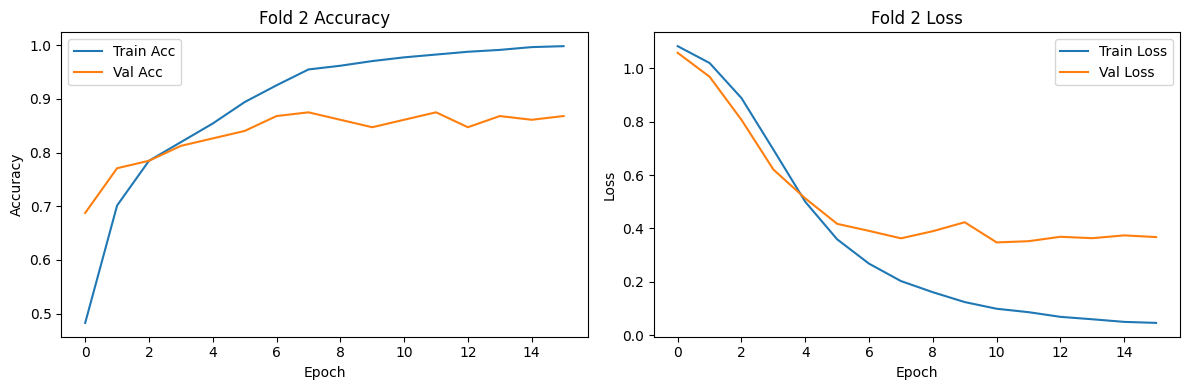


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3618 - loss: 1.0952 - val_accuracy: 0.6667 - val_loss: 1.0641 - learning_rate: 2.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6980 - loss: 1.0458 - val_accuracy: 0.7639 - val_loss: 0.9807 - learning_rate: 2.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7402 - loss: 0.9381 - val_accuracy: 0.8264 - val_loss: 0.8085 - learning_rate: 2.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8375 - loss: 0.7479 - val_accuracy: 0.8264 - val_loss: 0.6044 - learning_rate: 2.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8701 - loss: 0.5513 - val_accuracy: 0.8542 - val_loss: 0.4534 - learning_rate: 2.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8734 - loss: 0.4016 - val_accuracy: 0.8681 - val_loss: 0.3733 - learning_rate: 2.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.92

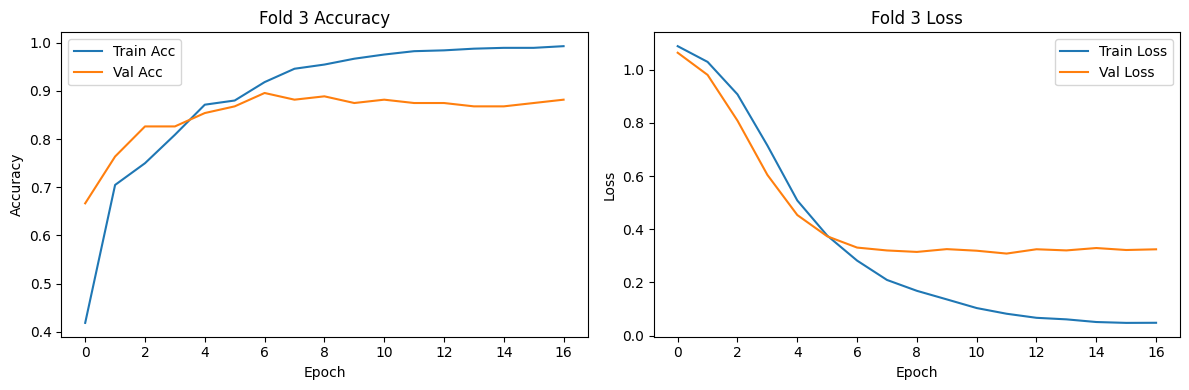


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4643 - loss: 1.0877 - val_accuracy: 0.7083 - val_loss: 1.0535 - learning_rate: 2.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7420 - loss: 1.0292 - val_accuracy: 0.7708 - val_loss: 0.9636 - learning_rate: 2.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8066 - loss: 0.9025 - val_accuracy: 0.7639 - val_loss: 0.8069 - learning_rate: 2.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8428 - loss: 0.7092 - val_accuracy: 0.8056 - val_loss: 0.6175 - learning_rate: 2.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8816 - loss: 0.4721 - val_accuracy: 0.8264 - val_loss: 0.4798 - learning_rate: 2.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9136 - loss: 0.3214 - val_accuracy: 0.8333 - val_loss: 0.4164 - learning_rate: 2.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.93

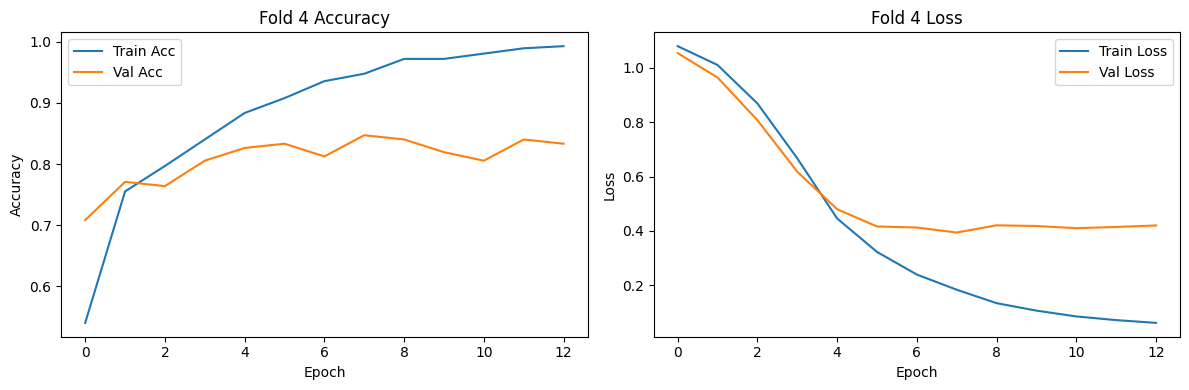


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5006 - loss: 1.0873 - val_accuracy: 0.6875 - val_loss: 1.0527 - learning_rate: 2.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7362 - loss: 1.0326 - val_accuracy: 0.8125 - val_loss: 0.9574 - learning_rate: 2.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7911 - loss: 0.9114 - val_accuracy: 0.7986 - val_loss: 0.7972 - learning_rate: 2.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8174 - loss: 0.7236 - val_accuracy: 0.8125 - val_loss: 0.5972 - learning_rate: 2.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8663 - loss: 0.5249 - val_accuracy: 0.8403 - val_loss: 0.4560 - learning_rate: 2.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8584 - loss: 0.4284 - val_accuracy: 0.8403 - val_loss: 0.3886 - learning_rate: 2.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.89

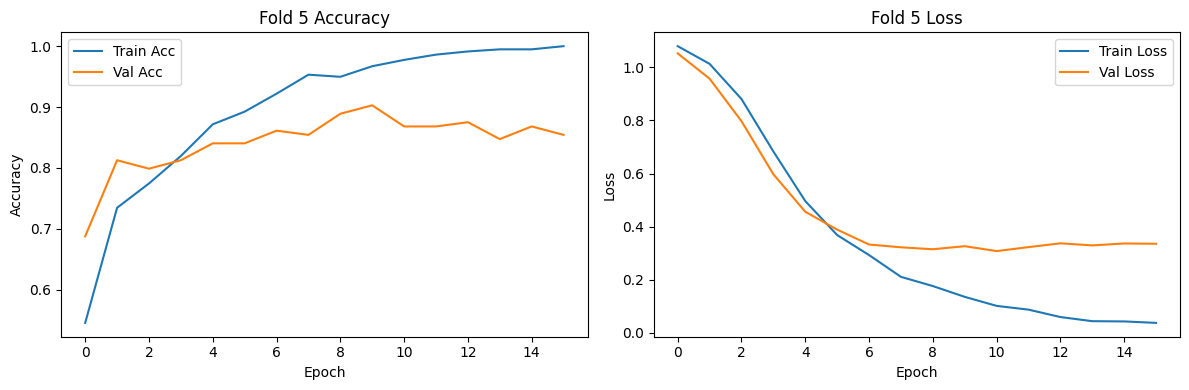


📊 Average Accuracy over 5 folds: 86.39%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5078 - loss: 1.0731 - val_accuracy: 0.7014 - val_loss: 0.9680 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7980 - loss: 0.8681 - val_accuracy: 0.7917 - val_loss: 0.6644 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8419 - loss: 0.4960 - val_accuracy: 0.7639 - val_loss: 0.5565 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9118 - loss: 0.2887 - val_accuracy: 0.8333 - val_loss: 0.4586 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9272 - loss: 0.2060 - val_accuracy: 0.8333 - val_loss: 0.4472 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9569 - loss: 0.1372 - val_accuracy: 0.8681 - val_loss: 0.4436 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.98

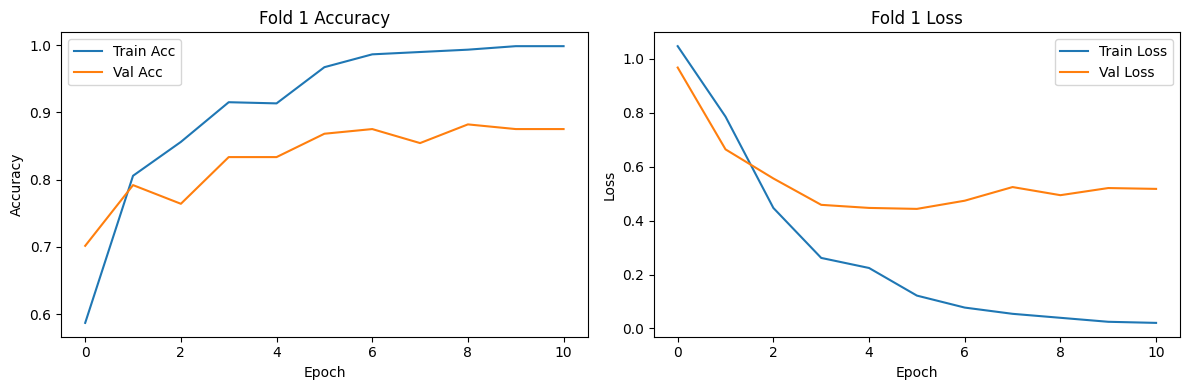


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4803 - loss: 1.0779 - val_accuracy: 0.8056 - val_loss: 0.9496 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8031 - loss: 0.8669 - val_accuracy: 0.7986 - val_loss: 0.6049 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8435 - loss: 0.4848 - val_accuracy: 0.8681 - val_loss: 0.3814 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9251 - loss: 0.2662 - val_accuracy: 0.8750 - val_loss: 0.3732 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9346 - loss: 0.2050 - val_accuracy: 0.8889 - val_loss: 0.3254 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9749 - loss: 0.0960 - val_accuracy: 0.8611 - val_loss: 0.3586 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.98

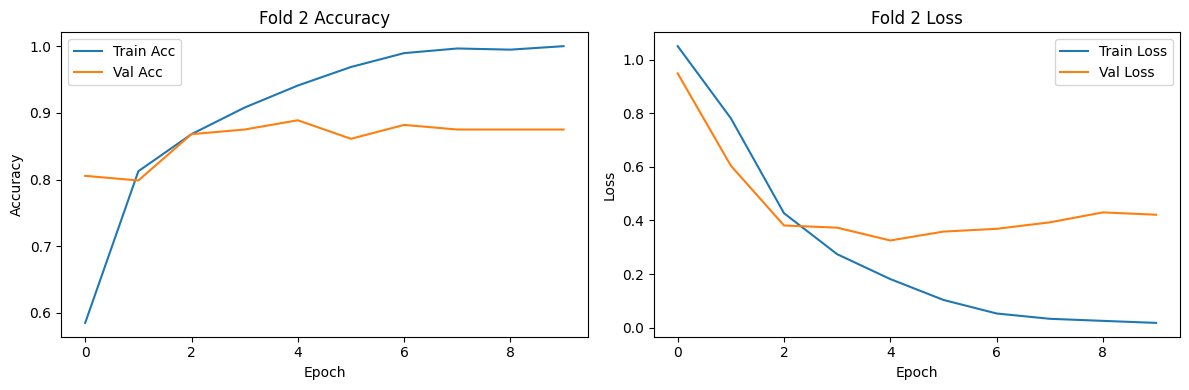


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4350 - loss: 1.0829 - val_accuracy: 0.7986 - val_loss: 0.9702 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7799 - loss: 0.8984 - val_accuracy: 0.8056 - val_loss: 0.6249 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8334 - loss: 0.5612 - val_accuracy: 0.8750 - val_loss: 0.3748 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9054 - loss: 0.2833 - val_accuracy: 0.8819 - val_loss: 0.3315 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9252 - loss: 0.2082 - val_accuracy: 0.8264 - val_loss: 0.4078 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9318 - loss: 0.1846 - val_accuracy: 0.8750 - val_loss: 0.3111 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.98

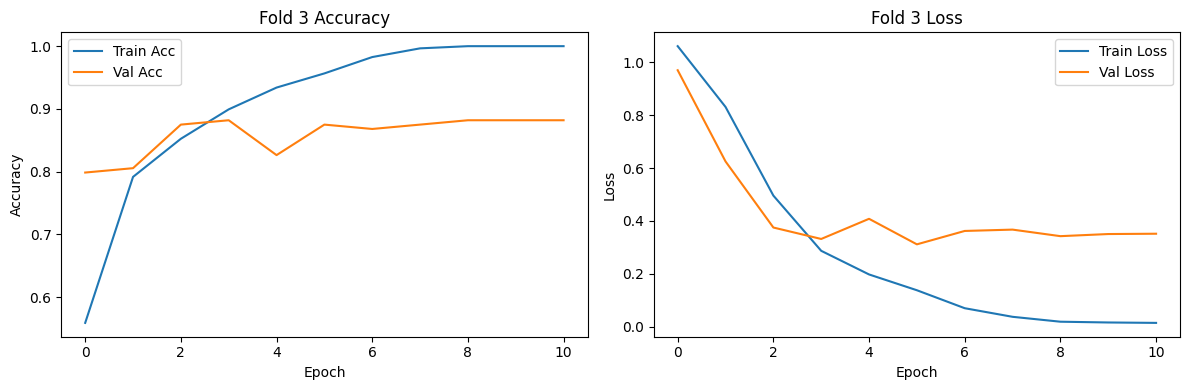


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4276 - loss: 1.0780 - val_accuracy: 0.7292 - val_loss: 0.9671 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7865 - loss: 0.8603 - val_accuracy: 0.7778 - val_loss: 0.6479 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8270 - loss: 0.5321 - val_accuracy: 0.8264 - val_loss: 0.4778 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9006 - loss: 0.2990 - val_accuracy: 0.8264 - val_loss: 0.3863 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9350 - loss: 0.1864 - val_accuracy: 0.8194 - val_loss: 0.4307 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9868 - loss: 0.0805 - val_accuracy: 0.8333 - val_loss: 0.3983 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.97

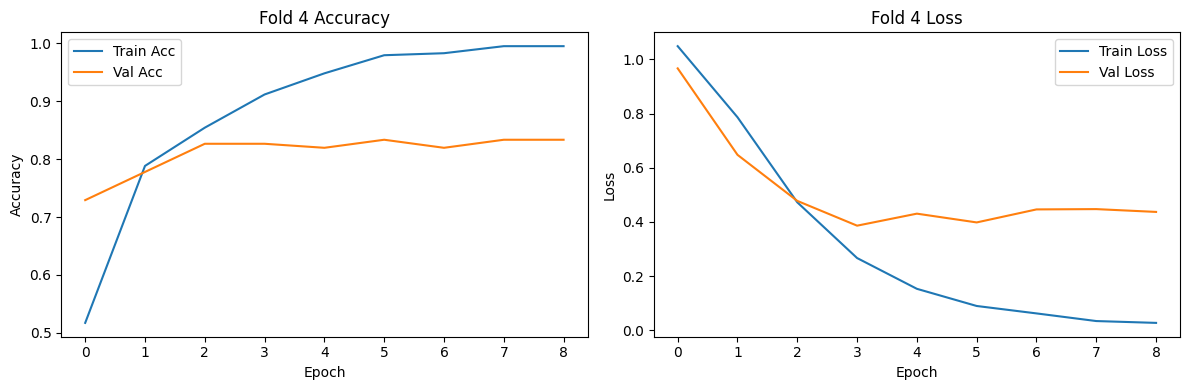


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4837 - loss: 1.0776 - val_accuracy: 0.7014 - val_loss: 0.9579 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7628 - loss: 0.8686 - val_accuracy: 0.7847 - val_loss: 0.6217 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8232 - loss: 0.5459 - val_accuracy: 0.8681 - val_loss: 0.3987 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9087 - loss: 0.3093 - val_accuracy: 0.8958 - val_loss: 0.3422 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9215 - loss: 0.2135 - val_accuracy: 0.8750 - val_loss: 0.3382 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9641 - loss: 0.1056 - val_accuracy: 0.8611 - val_loss: 0.4025 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.96

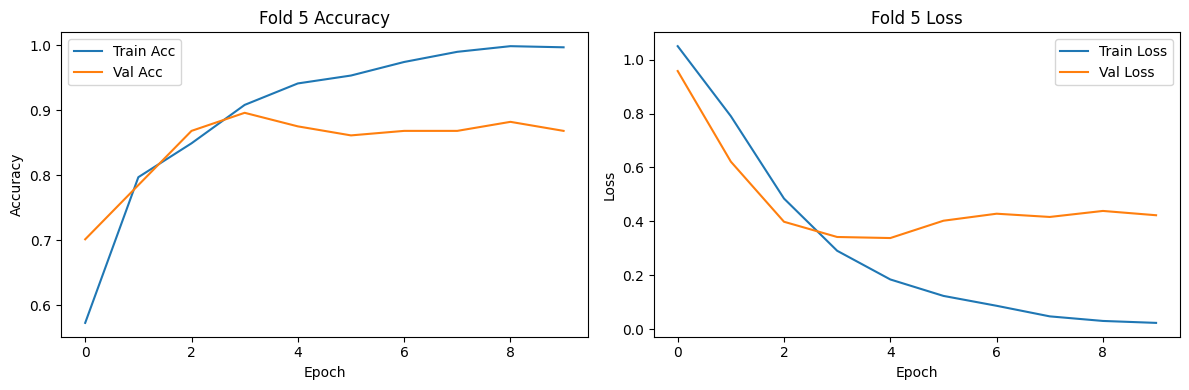


📊 Average Accuracy over 5 folds: 86.67%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5194 - loss: 1.0486 - val_accuracy: 0.7083 - val_loss: 0.7961 - learning_rate: 0.0010
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8004 - loss: 0.5950 - val_accuracy: 0.8125 - val_loss: 0.4823 - learning_rate: 0.0010
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8911 - loss: 0.2989 - val_accuracy: 0.8403 - val_loss: 0.5121 - learning_rate: 0.0010
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9763 - loss: 0.1165 - val_accuracy: 0.8611 - val_loss: 0.4846 - learning_rate: 0.0010
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9697 - loss: 0.0929 - val_accuracy: 0.8681 - val_loss: 0.4781 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9830 - loss: 0.0639 - val_accuracy: 0.8681 - val_loss: 0.5143 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9990 - loss: 0.027

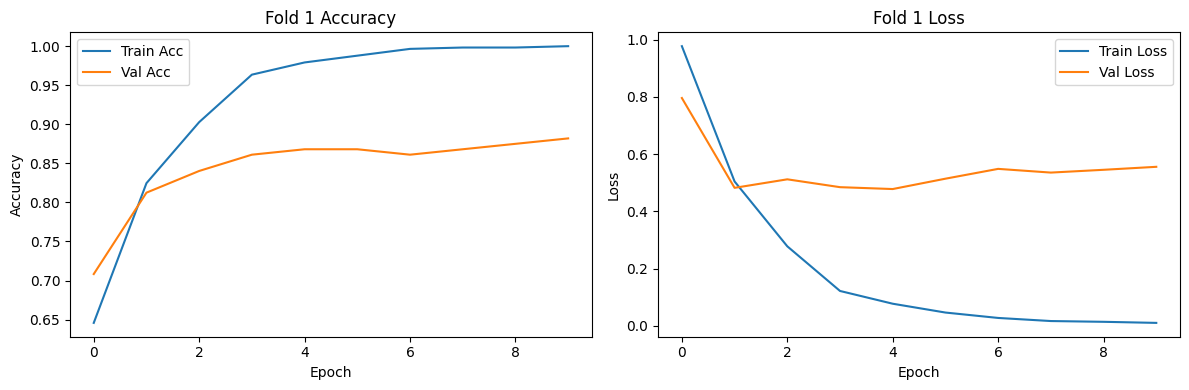


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4751 - loss: 1.0437 - val_accuracy: 0.7778 - val_loss: 0.7131 - learning_rate: 0.0010
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8070 - loss: 0.5730 - val_accuracy: 0.8194 - val_loss: 0.4310 - learning_rate: 0.0010
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9140 - loss: 0.2498 - val_accuracy: 0.8819 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9495 - loss: 0.1525 - val_accuracy: 0.8264 - val_loss: 0.4585 - learning_rate: 0.0010
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9710 - loss: 0.1074 - val_accuracy: 0.8542 - val_loss: 0.4453 - learning_rate: 0.0010
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9882 - loss: 0.0467 - val_accuracy: 0.8542 - val_loss: 0.4174 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 1.0000 - loss: 0.0175 - 

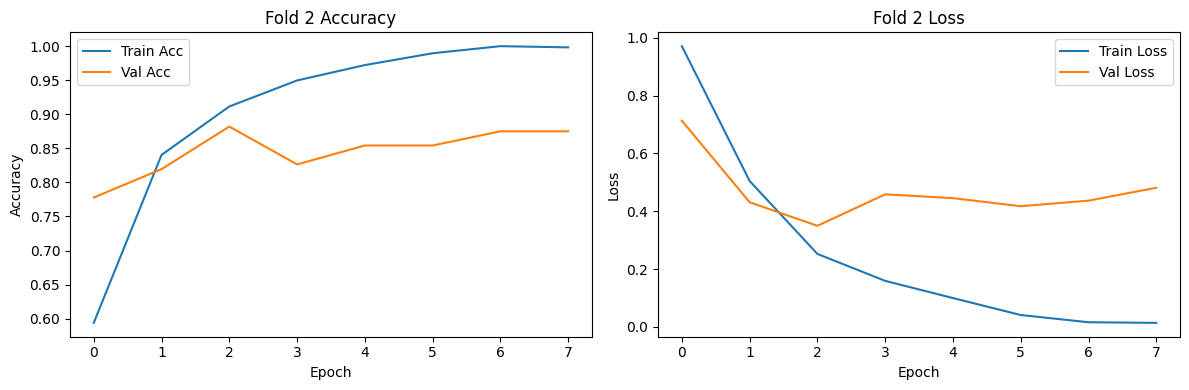


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5570 - loss: 1.0446 - val_accuracy: 0.8264 - val_loss: 0.7249 - learning_rate: 0.0010
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8289 - loss: 0.6187 - val_accuracy: 0.8958 - val_loss: 0.3407 - learning_rate: 0.0010
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8758 - loss: 0.3541 - val_accuracy: 0.9028 - val_loss: 0.2786 - learning_rate: 0.0010
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9466 - loss: 0.1678 - val_accuracy: 0.8889 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9840 - loss: 0.0892 - val_accuracy: 0.8681 - val_loss: 0.3147 - learning_rate: 0.0010
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9857 - loss: 0.0466 - val_accuracy: 0.8750 - val_loss: 0.3505 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9982 - loss: 0.0214 - 

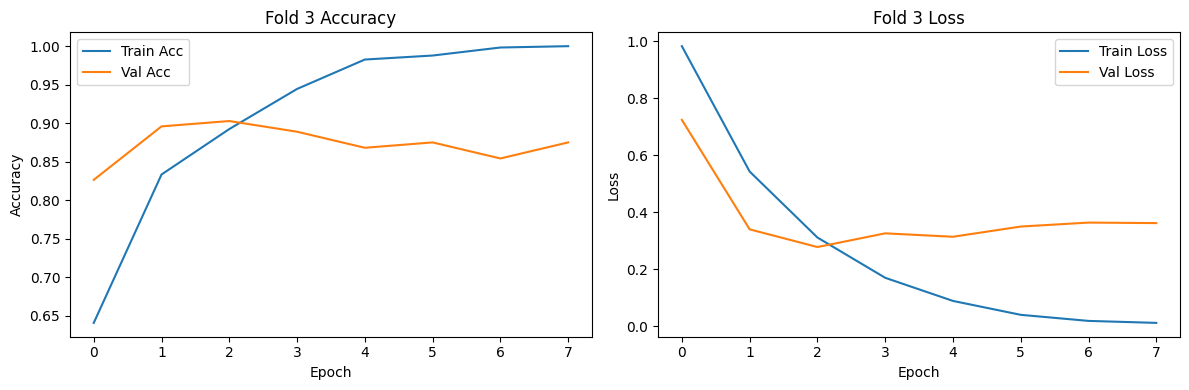


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5295 - loss: 1.0435 - val_accuracy: 0.7153 - val_loss: 0.7568 - learning_rate: 0.0010
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8063 - loss: 0.5995 - val_accuracy: 0.8056 - val_loss: 0.4367 - learning_rate: 0.0010
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9114 - loss: 0.2785 - val_accuracy: 0.8333 - val_loss: 0.4168 - learning_rate: 0.0010
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9601 - loss: 0.1337 - val_accuracy: 0.8472 - val_loss: 0.4370 - learning_rate: 0.0010
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9841 - loss: 0.0737 - val_accuracy: 0.7986 - val_loss: 0.6545 - learning_rate: 0.0010
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9926 - loss: 0.0483 - val_accuracy: 0.7986 - val_loss: 0.6329 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9945 - loss: 0.0282 - 

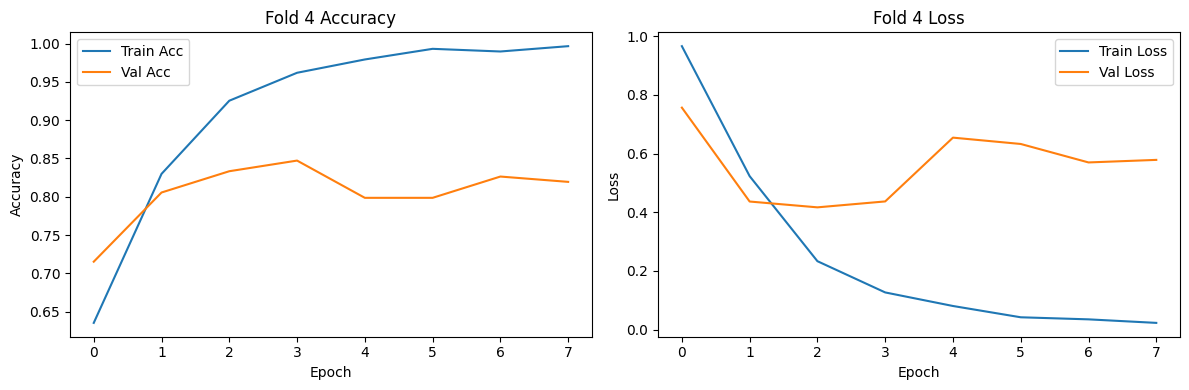


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5230 - loss: 1.0473 - val_accuracy: 0.7083 - val_loss: 0.7448 - learning_rate: 0.0010
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8211 - loss: 0.5832 - val_accuracy: 0.8681 - val_loss: 0.3792 - learning_rate: 0.0010
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9094 - loss: 0.2690 - val_accuracy: 0.8403 - val_loss: 0.3597 - learning_rate: 0.0010
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9680 - loss: 0.1106 - val_accuracy: 0.8819 - val_loss: 0.3900 - learning_rate: 0.0010
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9441 - loss: 0.1347 - val_accuracy: 0.8819 - val_loss: 0.4655 - learning_rate: 0.0010
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9792 - loss: 0.0656 - val_accuracy: 0.8611 - val_loss: 0.4150 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9997 - loss: 0.0160 - 

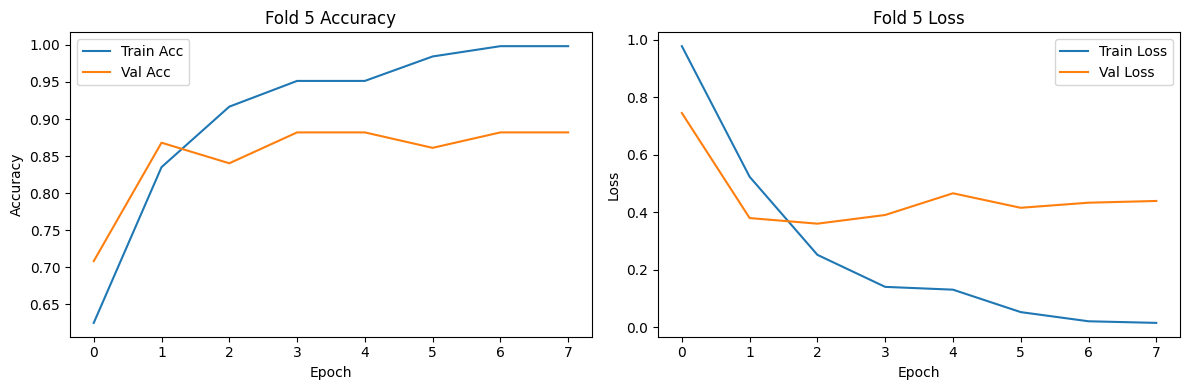


📊 Average Accuracy over 5 folds: 86.53%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5098 - loss: 0.9969 - val_accuracy: 0.7778 - val_loss: 0.5874 - learning_rate: 0.0020
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8265 - loss: 0.4331 - val_accuracy: 0.8194 - val_loss: 0.4629 - learning_rate: 0.0020
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9263 - loss: 0.2352 - val_accuracy: 0.8681 - val_loss: 0.4376 - learning_rate: 0.0020
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9399 - loss: 0.1604 - val_accuracy: 0.8750 - val_loss: 0.4595 - learning_rate: 0.0020
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9580 - loss: 0.1084 - val_accuracy: 0.8056 - val_loss: 0.7693 - learning_rate: 0.0020
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9456 - loss: 0.1182 - val_accuracy: 0.8750 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9776 - loss: 0.0513 - val_

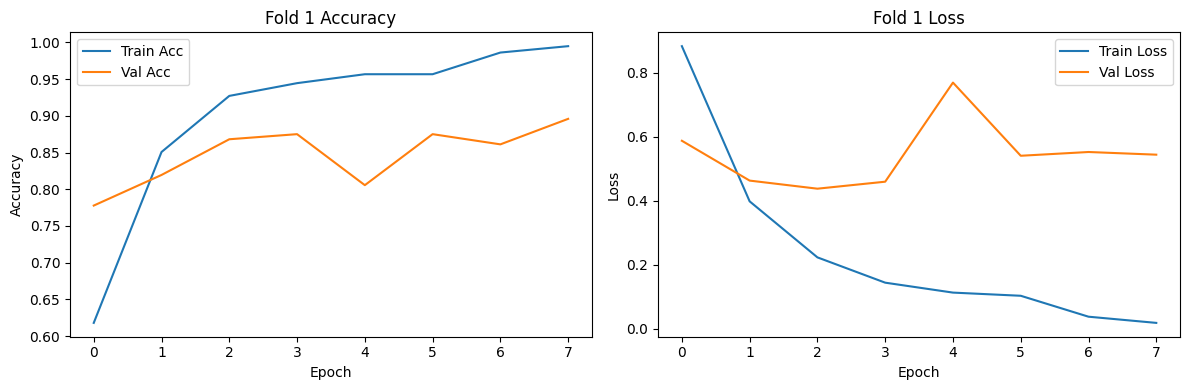


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5631 - loss: 0.9828 - val_accuracy: 0.8056 - val_loss: 0.5127 - learning_rate: 0.0020
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8558 - loss: 0.3902 - val_accuracy: 0.8264 - val_loss: 0.4390 - learning_rate: 0.0020
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9012 - loss: 0.2678 - val_accuracy: 0.8333 - val_loss: 0.4399 - learning_rate: 0.0020
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9309 - loss: 0.1668 - val_accuracy: 0.8125 - val_loss: 0.6007 - learning_rate: 0.0020
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9622 - loss: 0.1101 - val_accuracy: 0.8611 - val_loss: 0.4700 - learning_rate: 0.0010
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9906 - loss: 0.0434 - val_accuracy: 0.8542 - val_loss: 0.5796 - learning_rate: 0.0010
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9900 - loss: 0.0248 - val_

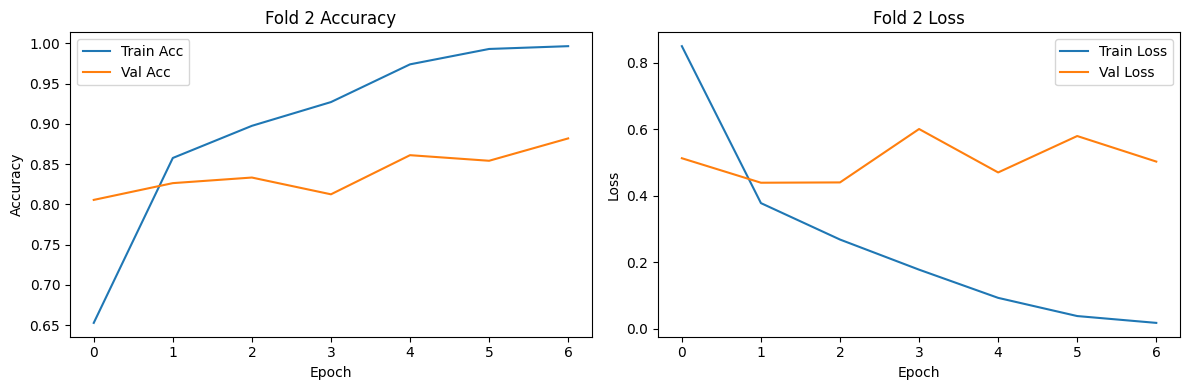


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4693 - loss: 1.0187 - val_accuracy: 0.7639 - val_loss: 0.6085 - learning_rate: 0.0020
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8660 - loss: 0.4417 - val_accuracy: 0.7500 - val_loss: 0.5392 - learning_rate: 0.0020
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8744 - loss: 0.3108 - val_accuracy: 0.8681 - val_loss: 0.3153 - learning_rate: 0.0020
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9404 - loss: 0.1689 - val_accuracy: 0.8403 - val_loss: 0.5269 - learning_rate: 0.0020
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9336 - loss: 0.1668 - val_accuracy: 0.8681 - val_loss: 0.3348 - learning_rate: 0.0020
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9667 - loss: 0.0952 - val_accuracy: 0.8958 - val_loss: 0.3742 - learning_rate: 0.0010
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9834 - loss: 0.0614 - val_

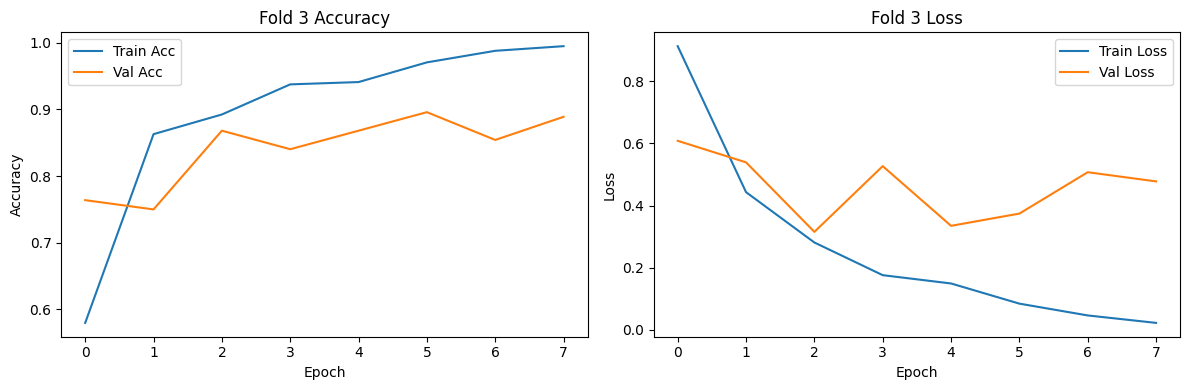


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5408 - loss: 0.9630 - val_accuracy: 0.7569 - val_loss: 0.5910 - learning_rate: 0.0020
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8485 - loss: 0.3786 - val_accuracy: 0.7847 - val_loss: 0.6964 - learning_rate: 0.0020
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9201 - loss: 0.2593 - val_accuracy: 0.8125 - val_loss: 0.4995 - learning_rate: 0.0020
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9568 - loss: 0.1248 - val_accuracy: 0.7778 - val_loss: 0.6517 - learning_rate: 0.0020
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9635 - loss: 0.1182 - val_accuracy: 0.8333 - val_loss: 0.5077 - learning_rate: 0.0020
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9817 - loss: 0.0513 - val_accuracy: 0.8403 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9949 - loss: 0.0256 - val_

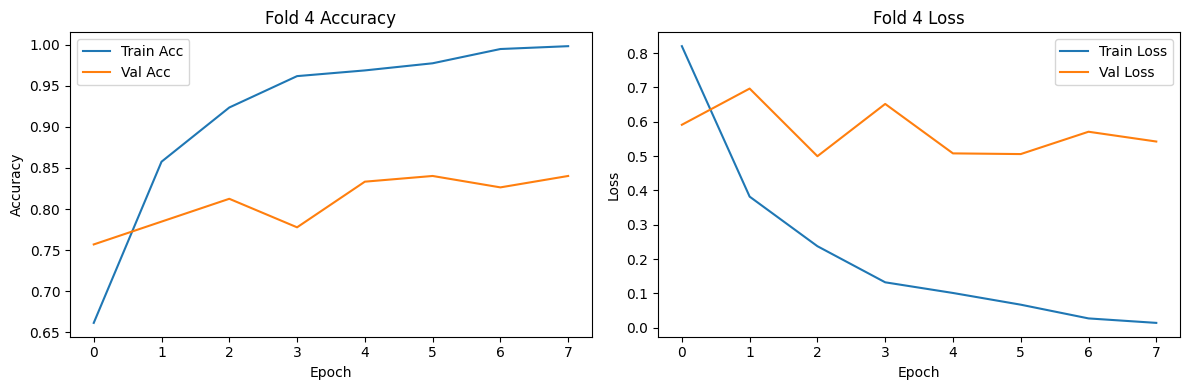


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5137 - loss: 1.0039 - val_accuracy: 0.8264 - val_loss: 0.5283 - learning_rate: 0.0020
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8527 - loss: 0.4367 - val_accuracy: 0.8264 - val_loss: 0.4329 - learning_rate: 0.0020
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9466 - loss: 0.1770 - val_accuracy: 0.8611 - val_loss: 0.4492 - learning_rate: 0.0020
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9494 - loss: 0.1570 - val_accuracy: 0.8264 - val_loss: 0.4990 - learning_rate: 0.0020
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9643 - loss: 0.0978 - val_accuracy: 0.8750 - val_loss: 0.4997 - learning_rate: 0.0010
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9899 - loss: 0.0410 - val_accuracy: 0.8819 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9967 - loss: 0.0225 - val_

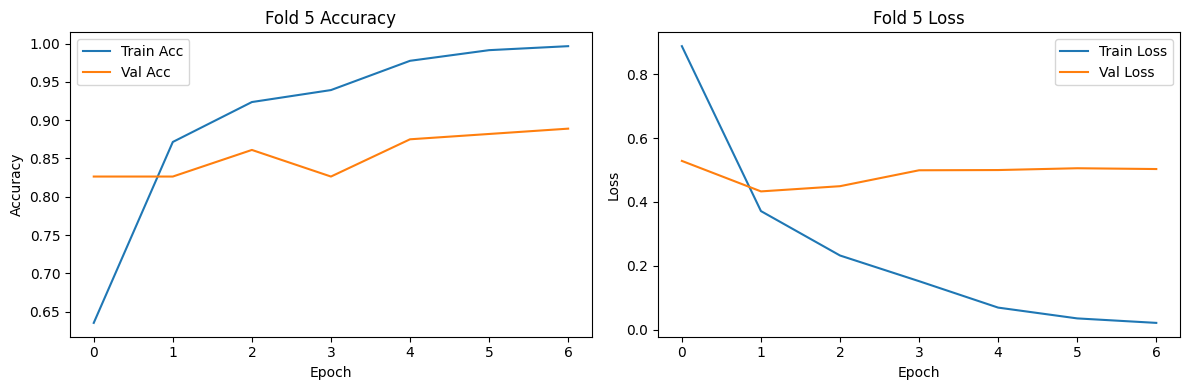


📊 Average Accuracy over 5 folds: 84.03%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")

# Batch Size


🔁 Fold 1
Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - accuracy: 0.4820 - loss: 1.0377 - val_accuracy: 0.7361 - val_loss: 0.6611 - learning_rate: 5.0000e-04
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - accuracy: 0.8655 - loss: 0.4080 - val_accuracy: 0.8056 - val_loss: 0.4621 - learning_rate: 5.0000e-04
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 272ms/step - accuracy: 0.8992 - loss: 0.2893 - val_accuracy: 0.8403 - val_loss: 0.5078 - learning_rate: 5.0000e-04
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9554 - loss: 0.1321 - val_accuracy: 0.8125 - val_loss: 0.5342 - learning_rate: 5.0000e-04
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.9633 - loss: 0.1165 - val_accuracy: 0.8611 - val_loss: 0.4701 - learning_rate: 2.5000e-04
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.9960 - loss: 0.0425 - val_accuracy: 0.8819 - val_loss: 0.4713 - learning_rate: 2.5000e-04
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 270ms/

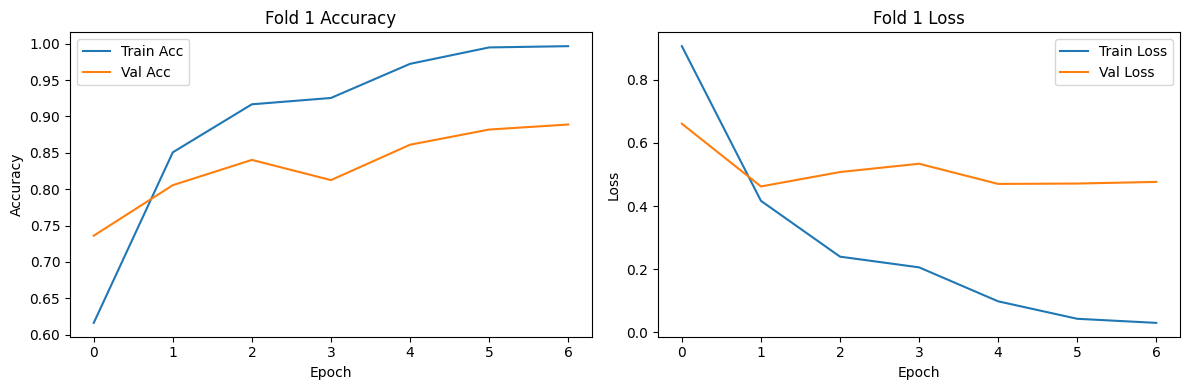


🔁 Fold 2
Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - accuracy: 0.5012 - loss: 1.0394 - val_accuracy: 0.7847 - val_loss: 0.5397 - learning_rate: 5.0000e-04
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 0.8382 - loss: 0.4504 - val_accuracy: 0.8333 - val_loss: 0.3697 - learning_rate: 5.0000e-04
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.9127 - loss: 0.2325 - val_accuracy: 0.8403 - val_loss: 0.4678 - learning_rate: 5.0000e-04
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.9670 - loss: 0.0978 - val_accuracy: 0.8681 - val_loss: 0.4876 - learning_rate: 5.0000e-04
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 265ms/step - accuracy: 0.9871 - loss: 0.0507 - val_accuracy: 0.8472 - val_loss: 0.4315 - learning_rate: 2.5000e-04
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.8750 - val_loss: 0.4168 - learning_rate: 2.5000e-04
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/

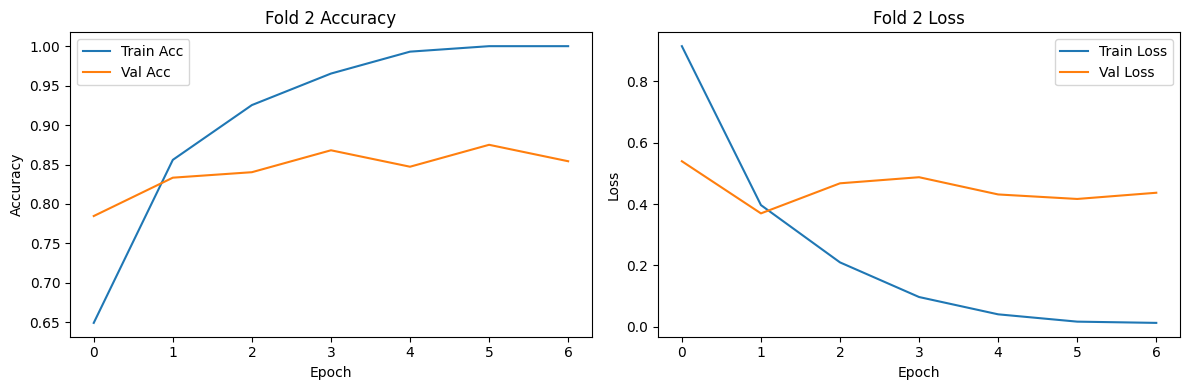


🔁 Fold 3
Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 279ms/step - accuracy: 0.5067 - loss: 1.0286 - val_accuracy: 0.8403 - val_loss: 0.5186 - learning_rate: 5.0000e-04
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.8740 - loss: 0.4175 - val_accuracy: 0.8403 - val_loss: 0.3540 - learning_rate: 5.0000e-04
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/step - accuracy: 0.9199 - loss: 0.2329 - val_accuracy: 0.8333 - val_loss: 0.3766 - learning_rate: 5.0000e-04
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.9377 - loss: 0.2071 - val_accuracy: 0.8403 - val_loss: 0.3928 - learning_rate: 5.0000e-04
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.9793 - loss: 0.0710 - val_accuracy: 0.8611 - val_loss: 0.3630 - learning_rate: 2.5000e-04
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.9972 - loss: 0.0275 - val_accuracy: 0.8403 - val_loss: 0.3631 - learning_rate: 2.5000e-04
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/

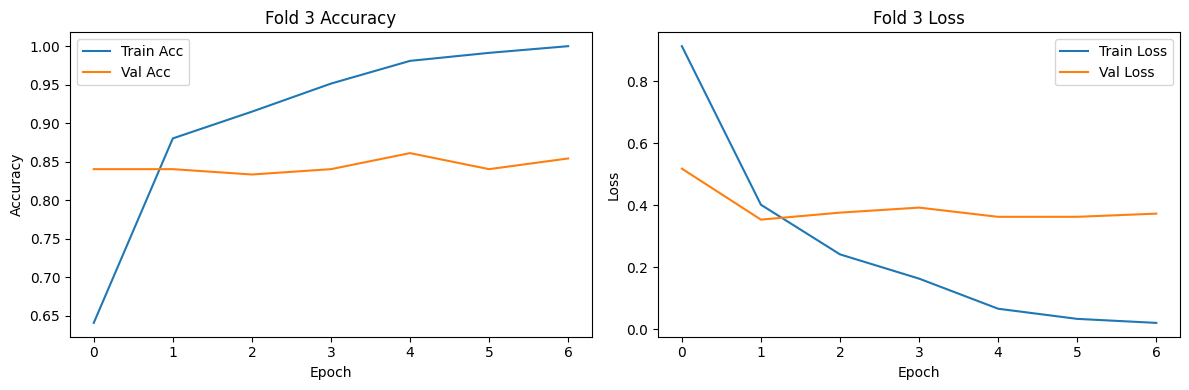


🔁 Fold 4
Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - accuracy: 0.5471 - loss: 1.0135 - val_accuracy: 0.7847 - val_loss: 0.5738 - learning_rate: 5.0000e-04
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.8736 - loss: 0.4023 - val_accuracy: 0.8194 - val_loss: 0.4231 - learning_rate: 5.0000e-04
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 274ms/step - accuracy: 0.9393 - loss: 0.1853 - val_accuracy: 0.8056 - val_loss: 0.4766 - learning_rate: 5.0000e-04
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - accuracy: 0.9695 - loss: 0.1057 - val_accuracy: 0.8194 - val_loss: 0.5406 - learning_rate: 5.0000e-04
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.9907 - loss: 0.0482 - val_accuracy: 0.8472 - val_loss: 0.4650 - learning_rate: 2.5000e-04
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.9977 - loss: 0.0182 - val_accuracy: 0.8333 - val_loss: 0.4819 - learning_rate: 2.5000e-04
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/

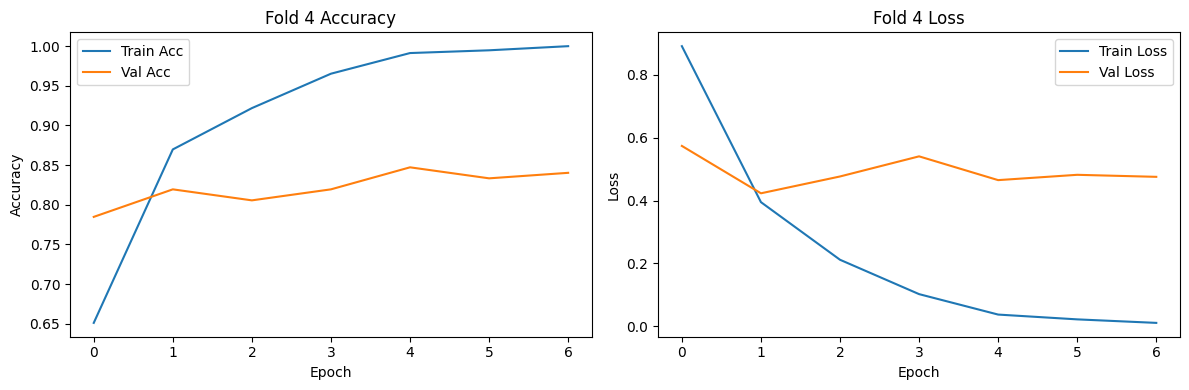


🔁 Fold 5
Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 293ms/step - accuracy: 0.4898 - loss: 1.0271 - val_accuracy: 0.7986 - val_loss: 0.5434 - learning_rate: 5.0000e-04
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.8561 - loss: 0.4733 - val_accuracy: 0.8403 - val_loss: 0.4178 - learning_rate: 5.0000e-04
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 278ms/step - accuracy: 0.9412 - loss: 0.1935 - val_accuracy: 0.8819 - val_loss: 0.3841 - learning_rate: 5.0000e-04
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 278ms/step - accuracy: 0.9694 - loss: 0.1093 - val_accuracy: 0.8472 - val_loss: 0.4144 - learning_rate: 5.0000e-04
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - accuracy: 0.9883 - loss: 0.0535 - val_accuracy: 0.8403 - val_loss: 0.4716 - learning_rate: 5.0000e-04
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - accuracy: 0.9887 - loss: 0.0366 - val_accuracy: 0.9028 - val_loss: 0.4708 - learning_rate: 2.5000e-04
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/

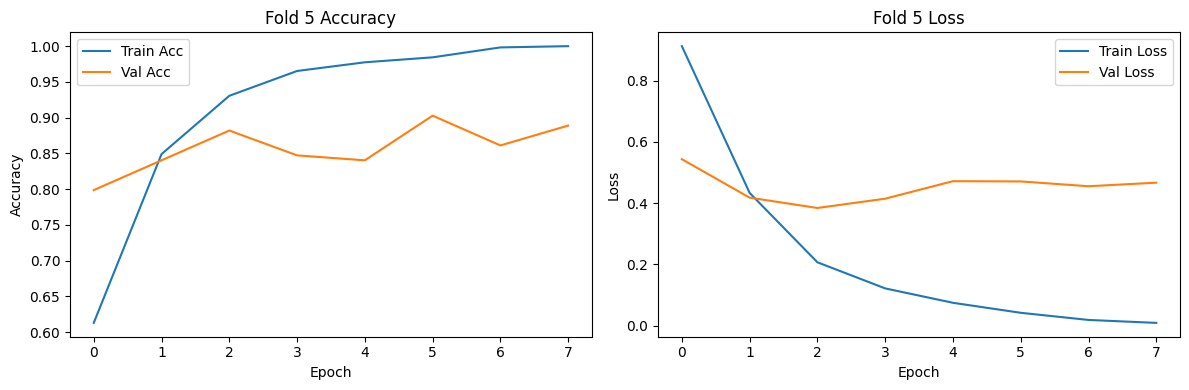


📊 Average Accuracy over 5 folds: 83.61%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 8
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 660ms/step - accuracy: 0.4539 - loss: 1.0714 - val_accuracy: 0.7431 - val_loss: 0.8622 - learning_rate: 5.0000e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 535ms/step - accuracy: 0.7919 - loss: 0.6893 - val_accuracy: 0.8333 - val_loss: 0.4581 - learning_rate: 5.0000e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 593ms/step - accuracy: 0.8827 - loss: 0.3144 - val_accuracy: 0.8611 - val_loss: 0.3852 - learning_rate: 5.0000e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 547ms/step - accuracy: 0.9280 - loss: 0.1958 - val_accuracy: 0.8542 - val_loss: 0.4338 - learning_rate: 5.0000e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 566ms/step - accuracy: 0.9671 - loss: 0.1096 - val_accuracy: 0.8611 - val_loss: 0.4332 - learning_rate: 5.0000e-04
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 562ms/step - accuracy: 0.9923 - loss: 0.0497 - val_accuracy: 0.8542 - val_loss: 0.4930 - learning_rate: 2.5000e-04
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/

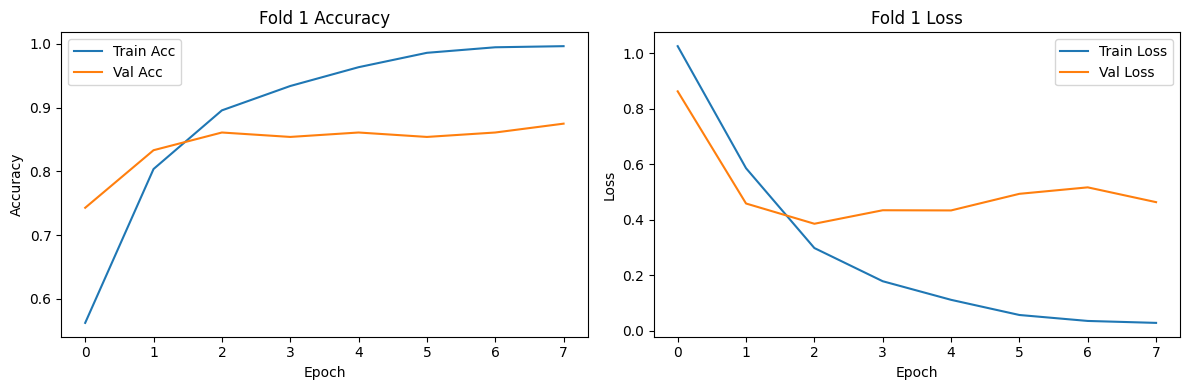


🔁 Fold 2
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 605ms/step - accuracy: 0.4903 - loss: 1.0556 - val_accuracy: 0.8125 - val_loss: 0.7799 - learning_rate: 5.0000e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 563ms/step - accuracy: 0.8202 - loss: 0.6262 - val_accuracy: 0.8472 - val_loss: 0.4152 - learning_rate: 5.0000e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 563ms/step - accuracy: 0.9057 - loss: 0.2997 - val_accuracy: 0.8403 - val_loss: 0.4185 - learning_rate: 5.0000e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 606ms/step - accuracy: 0.9468 - loss: 0.1659 - val_accuracy: 0.8681 - val_loss: 0.4110 - learning_rate: 5.0000e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 570ms/step - accuracy: 0.9626 - loss: 0.1228 - val_accuracy: 0.8819 - val_loss: 0.4509 - learning_rate: 5.0000e-04
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 571ms/step - accuracy: 0.9948 - loss: 0.0353 - val_accuracy: 0.8472 - val_loss: 0.4496 - learning_rate: 5.0000e-04
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 605ms/

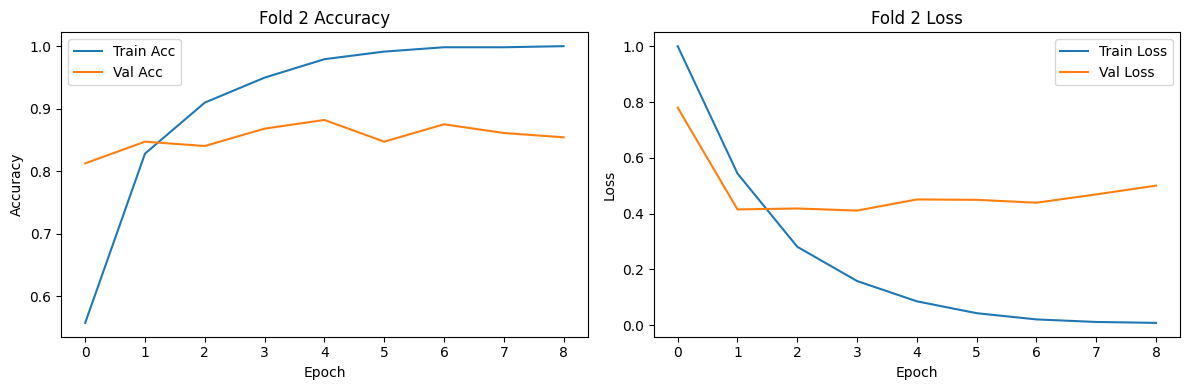


🔁 Fold 3
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 618ms/step - accuracy: 0.4726 - loss: 1.0629 - val_accuracy: 0.7986 - val_loss: 0.7693 - learning_rate: 5.0000e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 583ms/step - accuracy: 0.8185 - loss: 0.6372 - val_accuracy: 0.8611 - val_loss: 0.3595 - learning_rate: 5.0000e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 538ms/step - accuracy: 0.9006 - loss: 0.3085 - val_accuracy: 0.8819 - val_loss: 0.3259 - learning_rate: 5.0000e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 513ms/step - accuracy: 0.9449 - loss: 0.1813 - val_accuracy: 0.8542 - val_loss: 0.3480 - learning_rate: 5.0000e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step - accuracy: 0.9533 - loss: 0.1319 - val_accuracy: 0.8819 - val_loss: 0.3016 - learning_rate: 5.0000e-04
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 494ms/step - accuracy: 0.9833 - loss: 0.0537 - val_accuracy: 0.8819 - val_loss: 0.3911 - learning_rate: 5.0000e-04
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 575ms/

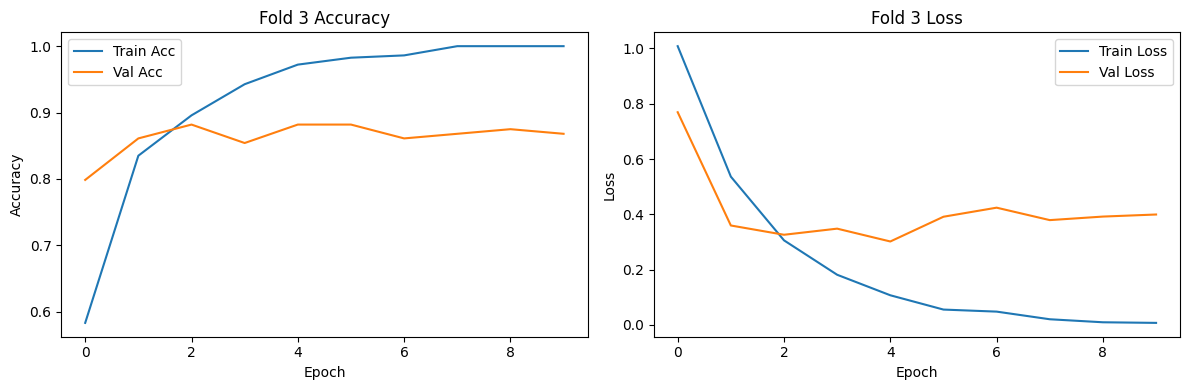


🔁 Fold 4
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 610ms/step - accuracy: 0.5130 - loss: 1.0544 - val_accuracy: 0.7847 - val_loss: 0.7953 - learning_rate: 5.0000e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 587ms/step - accuracy: 0.8282 - loss: 0.6157 - val_accuracy: 0.8125 - val_loss: 0.4438 - learning_rate: 5.0000e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 564ms/step - accuracy: 0.9370 - loss: 0.2619 - val_accuracy: 0.7847 - val_loss: 0.5338 - learning_rate: 5.0000e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 554ms/step - accuracy: 0.9173 - loss: 0.1926 - val_accuracy: 0.8333 - val_loss: 0.4638 - learning_rate: 5.0000e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 520ms/step - accuracy: 0.9723 - loss: 0.0832 - val_accuracy: 0.8472 - val_loss: 0.4327 - learning_rate: 2.5000e-04
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 535ms/step - accuracy: 0.9868 - loss: 0.0680 - val_accuracy: 0.8681 - val_loss: 0.4295 - learning_rate: 2.5000e-04
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/

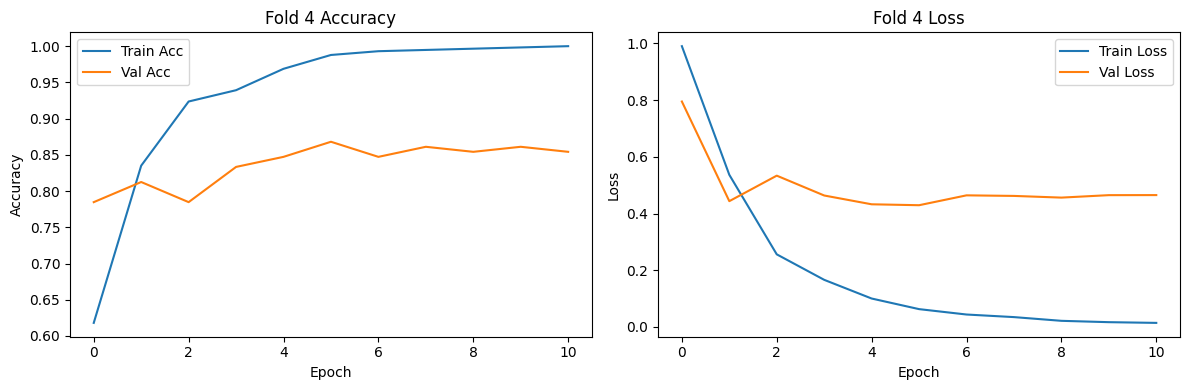


🔁 Fold 5
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 680ms/step - accuracy: 0.4423 - loss: 1.0639 - val_accuracy: 0.7778 - val_loss: 0.7986 - learning_rate: 5.0000e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.8174 - loss: 0.6688 - val_accuracy: 0.8403 - val_loss: 0.4059 - learning_rate: 5.0000e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 600ms/step - accuracy: 0.9127 - loss: 0.2954 - val_accuracy: 0.8472 - val_loss: 0.3589 - learning_rate: 5.0000e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 582ms/step - accuracy: 0.9289 - loss: 0.2098 - val_accuracy: 0.8472 - val_loss: 0.3896 - learning_rate: 5.0000e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 529ms/step - accuracy: 0.9351 - loss: 0.1790 - val_accuracy: 0.8958 - val_loss: 0.3449 - learning_rate: 5.0000e-04
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 587ms/step - accuracy: 0.9880 - loss: 0.0547 - val_accuracy: 0.8750 - val_loss: 0.3667 - learning_rate: 5.0000e-04
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 569ms/

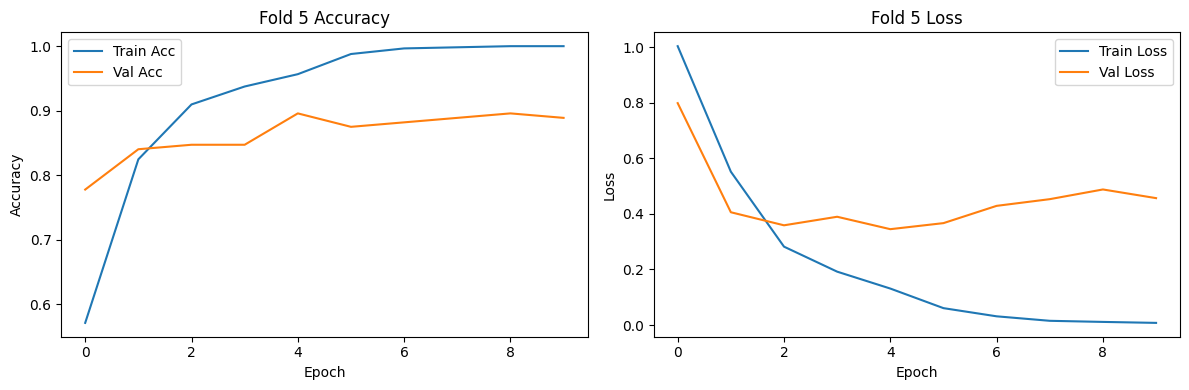


📊 Average Accuracy over 5 folds: 87.50%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 16
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4024 - loss: 1.0844 - val_accuracy: 0.6875 - val_loss: 1.0037 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7267 - loss: 0.9240 - val_accuracy: 0.7778 - val_loss: 0.7668 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8343 - loss: 0.6063 - val_accuracy: 0.7847 - val_loss: 0.5486 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8935 - loss: 0.3221 - val_accuracy: 0.8125 - val_loss: 0.4820 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9421 - loss: 0.2094 - val_accuracy: 0.8194 - val_loss: 0.5190 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9547 - loss: 0.1407 - val_accuracy: 0.8472 - val_loss: 0.4853 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.96

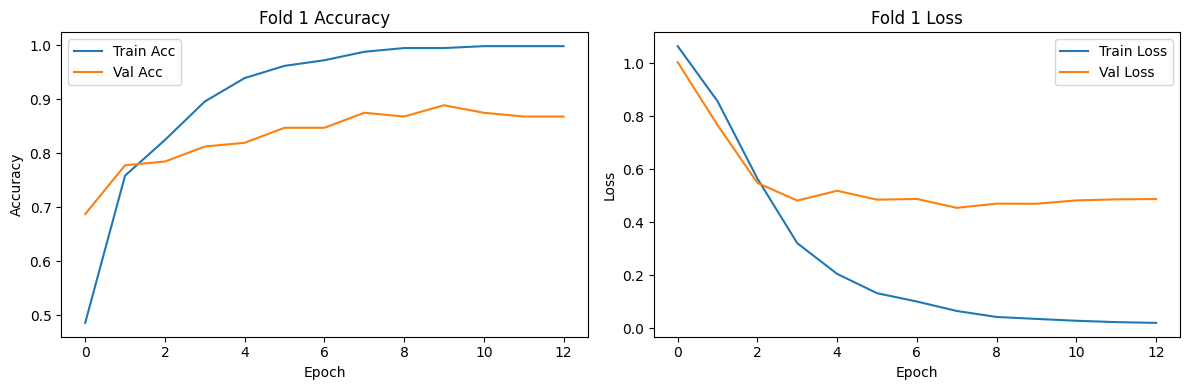


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5038 - loss: 1.0709 - val_accuracy: 0.7222 - val_loss: 0.9420 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7532 - loss: 0.8795 - val_accuracy: 0.7778 - val_loss: 0.6675 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8212 - loss: 0.5633 - val_accuracy: 0.8333 - val_loss: 0.4355 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9183 - loss: 0.2508 - val_accuracy: 0.8403 - val_loss: 0.4202 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9508 - loss: 0.1697 - val_accuracy: 0.8681 - val_loss: 0.3293 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9671 - loss: 0.0930 - val_accuracy: 0.8819 - val_loss: 0.3431 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.98

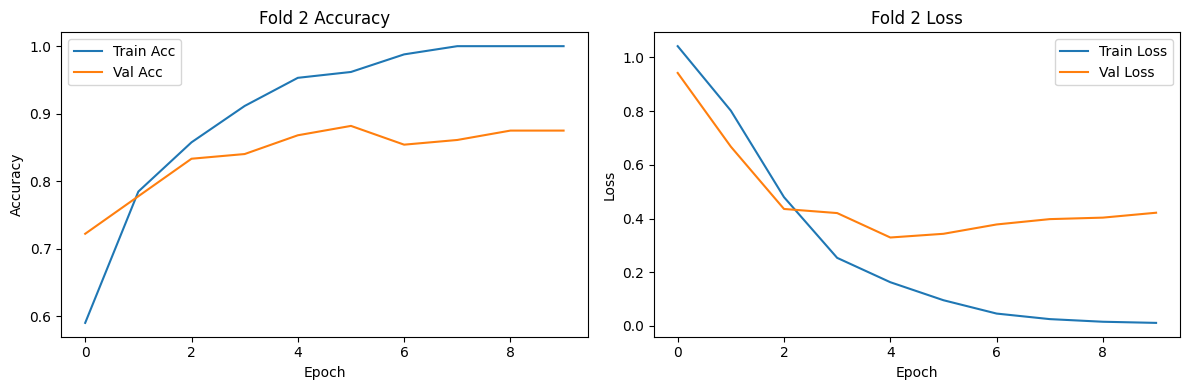


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5352 - loss: 1.0658 - val_accuracy: 0.7847 - val_loss: 0.8923 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7890 - loss: 0.8006 - val_accuracy: 0.8403 - val_loss: 0.5175 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8462 - loss: 0.4637 - val_accuracy: 0.8819 - val_loss: 0.3707 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8936 - loss: 0.2840 - val_accuracy: 0.8750 - val_loss: 0.3636 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9392 - loss: 0.2137 - val_accuracy: 0.8889 - val_loss: 0.3330 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9720 - loss: 0.1101 - val_accuracy: 0.8472 - val_loss: 0.4082 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.98

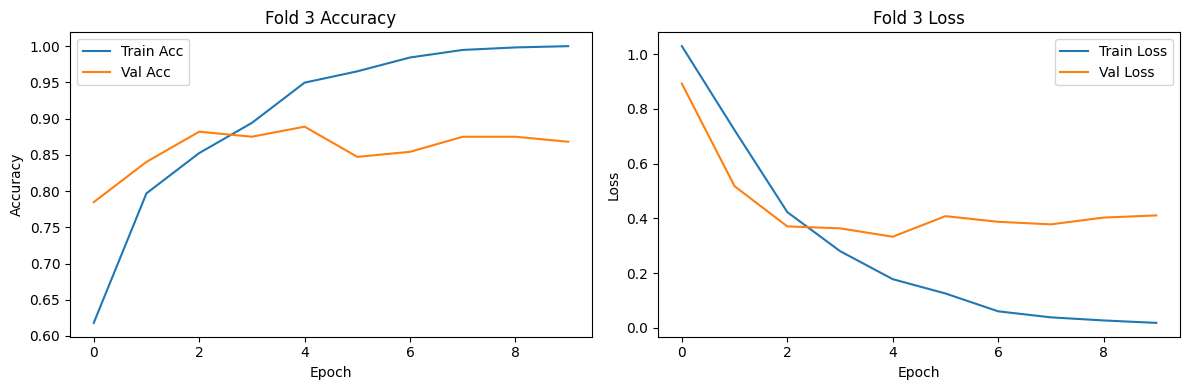


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5414 - loss: 1.0699 - val_accuracy: 0.7153 - val_loss: 0.9485 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7777 - loss: 0.8328 - val_accuracy: 0.7778 - val_loss: 0.6331 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8499 - loss: 0.4837 - val_accuracy: 0.8194 - val_loss: 0.4593 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9430 - loss: 0.2113 - val_accuracy: 0.8472 - val_loss: 0.4483 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9604 - loss: 0.1549 - val_accuracy: 0.7986 - val_loss: 0.4673 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9804 - loss: 0.0840 - val_accuracy: 0.8194 - val_loss: 0.5410 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.98

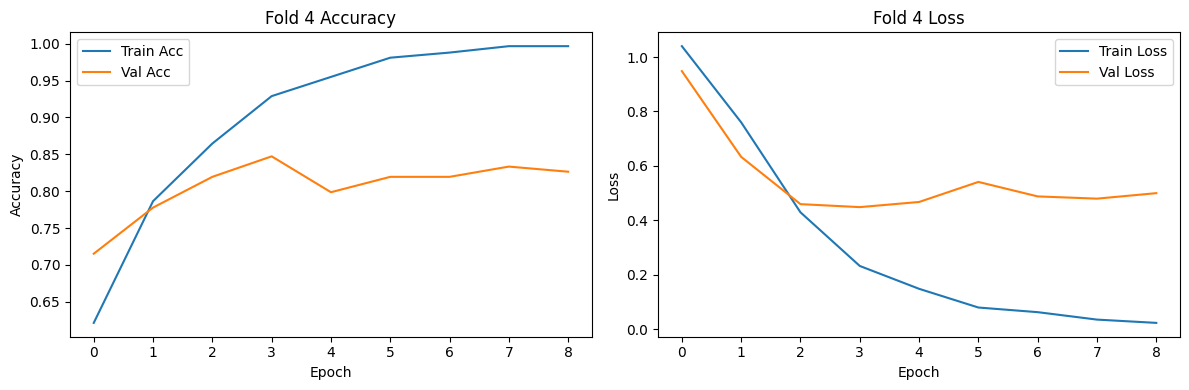


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5232 - loss: 1.0776 - val_accuracy: 0.6667 - val_loss: 0.9665 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7093 - loss: 0.8907 - val_accuracy: 0.8056 - val_loss: 0.6253 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7948 - loss: 0.5840 - val_accuracy: 0.8889 - val_loss: 0.4010 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8822 - loss: 0.3537 - val_accuracy: 0.8681 - val_loss: 0.3620 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9443 - loss: 0.2041 - val_accuracy: 0.8889 - val_loss: 0.3550 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9556 - loss: 0.1293 - val_accuracy: 0.8819 - val_loss: 0.3281 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.97

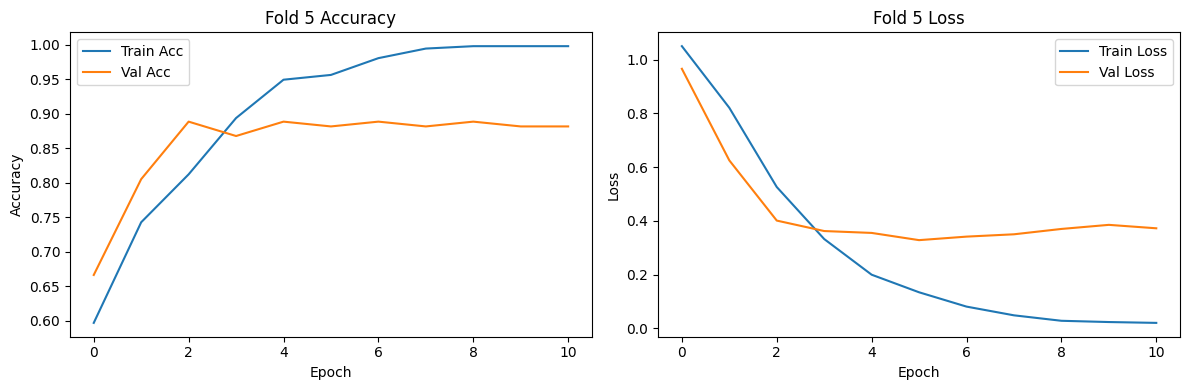


📊 Average Accuracy over 5 folds: 87.22%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4435 - loss: 1.0835 - val_accuracy: 0.7222 - val_loss: 1.0269 - learning_rate: 5.0000e-04
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7183 - loss: 0.9703 - val_accuracy: 0.7361 - val_loss: 0.8820 - learning_rate: 5.0000e-04
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8288 - loss: 0.7660 - val_accuracy: 0.7847 - val_loss: 0.6789 - learning_rate: 5.0000e-04
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8511 - loss: 0.5622 - val_accuracy: 0.7917 - val_loss: 0.5329 - learning_rate: 5.0000e-04
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9073 - loss: 0.3363 - val_accuracy: 0.7778 - val_loss: 0.5171 - learning_rate: 5.0000e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9342 - loss: 0.2536 - val_accuracy: 0.8403 - val_loss: 0.4513 - learning_rate: 5.0000e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9505 - loss: 0.1

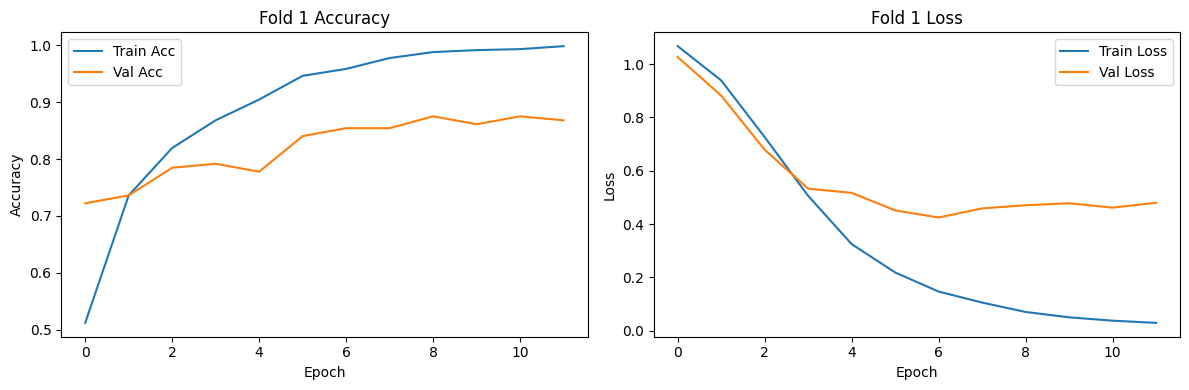


🔁 Fold 2
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4742 - loss: 1.0854 - val_accuracy: 0.7083 - val_loss: 1.0256 - learning_rate: 5.0000e-04
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7237 - loss: 0.9877 - val_accuracy: 0.7292 - val_loss: 0.8719 - learning_rate: 5.0000e-04
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7975 - loss: 0.8109 - val_accuracy: 0.8125 - val_loss: 0.6757 - learning_rate: 5.0000e-04
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8416 - loss: 0.5944 - val_accuracy: 0.8056 - val_loss: 0.5291 - learning_rate: 5.0000e-04
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8932 - loss: 0.3920 - val_accuracy: 0.8056 - val_loss: 0.4556 - learning_rate: 5.0000e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9100 - loss: 0.3029 - val_accuracy: 0.8819 - val_loss: 0.3775 - learning_rate: 5.0000e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9284 - loss: 0.2

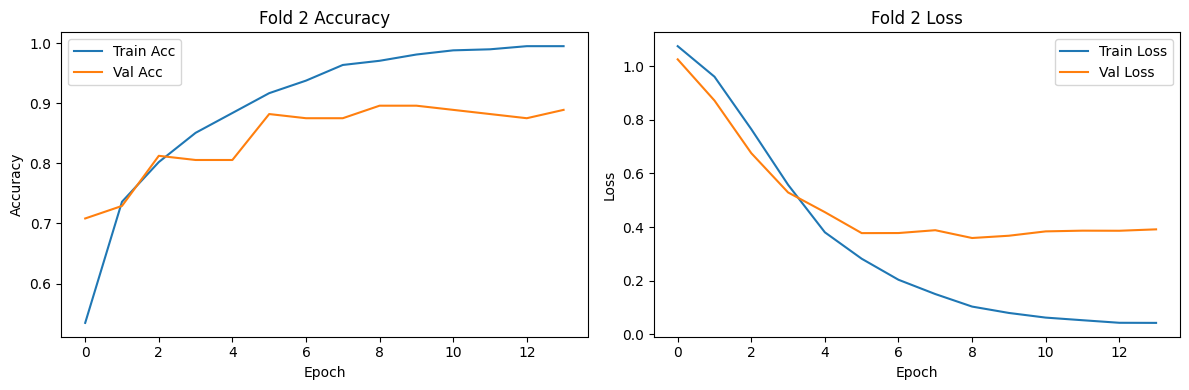


🔁 Fold 3
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.3882 - loss: 1.0886 - val_accuracy: 0.6736 - val_loss: 1.0340 - learning_rate: 5.0000e-04
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6851 - loss: 1.0115 - val_accuracy: 0.7083 - val_loss: 0.9040 - learning_rate: 5.0000e-04
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.7465 - loss: 0.8673 - val_accuracy: 0.7569 - val_loss: 0.7372 - learning_rate: 5.0000e-04
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.7944 - loss: 0.6717 - val_accuracy: 0.8403 - val_loss: 0.5530 - learning_rate: 5.0000e-04
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8703 - loss: 0.4628 - val_accuracy: 0.8264 - val_loss: 0.4175 - learning_rate: 5.0000e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9278 - loss: 0.3023 - val_accuracy: 0.8472 - val_loss: 0.3646 - learning_rate: 5.0000e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9289 - loss: 0.2

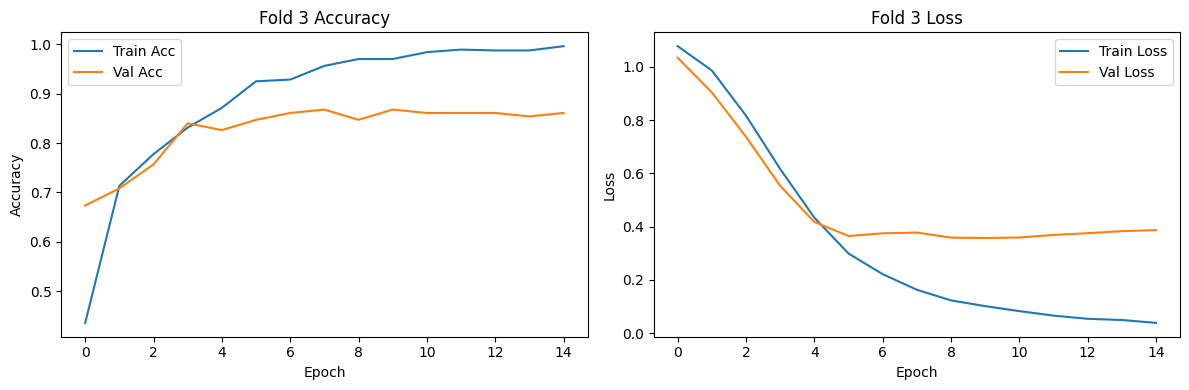


🔁 Fold 4
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.4882 - loss: 1.0832 - val_accuracy: 0.7153 - val_loss: 1.0266 - learning_rate: 5.0000e-04
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.7105 - loss: 0.9864 - val_accuracy: 0.7292 - val_loss: 0.8779 - learning_rate: 5.0000e-04
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7824 - loss: 0.7928 - val_accuracy: 0.8056 - val_loss: 0.6712 - learning_rate: 5.0000e-04
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8488 - loss: 0.5483 - val_accuracy: 0.8194 - val_loss: 0.5227 - learning_rate: 5.0000e-04
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8980 - loss: 0.3510 - val_accuracy: 0.8472 - val_loss: 0.4420 - learning_rate: 5.0000e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9410 - loss: 0.2144 - val_accuracy: 0.8681 - val_loss: 0.4139 - learning_rate: 5.0000e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9612 - loss: 0.1

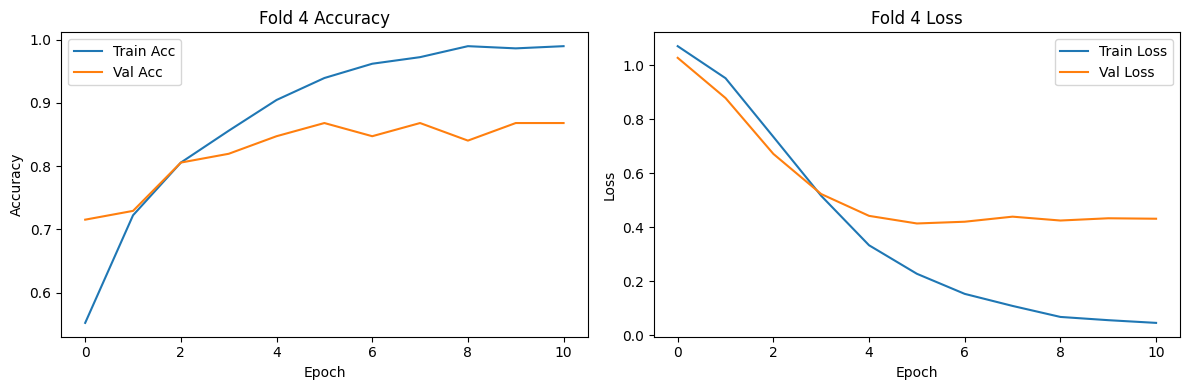


🔁 Fold 5
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4564 - loss: 1.0863 - val_accuracy: 0.7361 - val_loss: 1.0253 - learning_rate: 5.0000e-04
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7739 - loss: 0.9766 - val_accuracy: 0.7708 - val_loss: 0.8701 - learning_rate: 5.0000e-04
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8131 - loss: 0.7946 - val_accuracy: 0.7847 - val_loss: 0.6612 - learning_rate: 5.0000e-04
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7988 - loss: 0.5919 - val_accuracy: 0.8125 - val_loss: 0.4823 - learning_rate: 5.0000e-04
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8629 - loss: 0.4194 - val_accuracy: 0.8542 - val_loss: 0.3830 - learning_rate: 5.0000e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9216 - loss: 0.2586 - val_accuracy: 0.8750 - val_loss: 0.3469 - learning_rate: 5.0000e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9325 - loss: 0.2

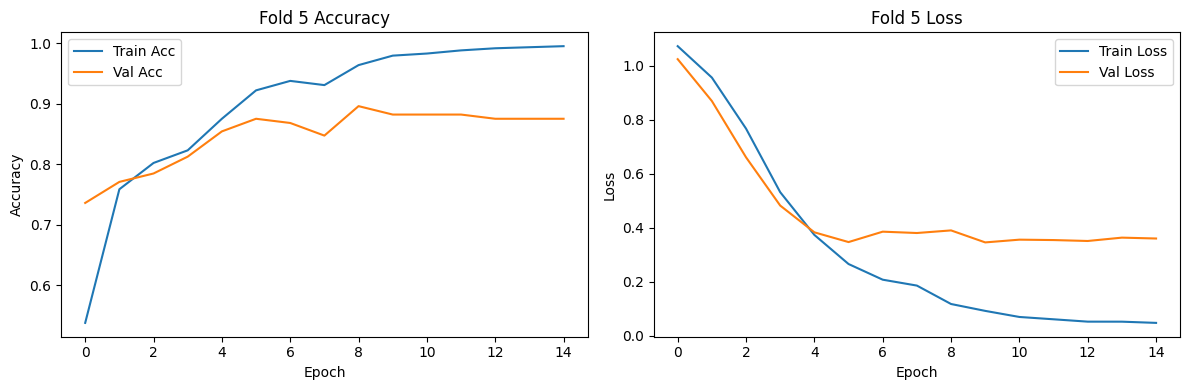


📊 Average Accuracy over 5 folds: 87.36%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 64
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.4030 - loss: 1.0933 - val_accuracy: 0.6667 - val_loss: 1.0685 - learning_rate: 5.0000e-04
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.6331 - loss: 1.0507 - val_accuracy: 0.7292 - val_loss: 1.0136 - learning_rate: 5.0000e-04
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.7446 - loss: 0.9774 - val_accuracy: 0.7500 - val_loss: 0.9255 - learning_rate: 5.0000e-04
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.7897 - loss: 0.8623 - val_accuracy: 0.7778 - val_loss: 0.8073 - learning_rate: 5.0000e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8356 - loss: 0.7201 - val_accuracy: 0.7500 - val_loss: 0.6987 - learning_rate: 5.0000e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.8290 - loss: 0.6071 - val_accuracy: 0.8125 - val_loss: 0.5878 - learning_rate: 5.0000e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8944 - loss: 0.4

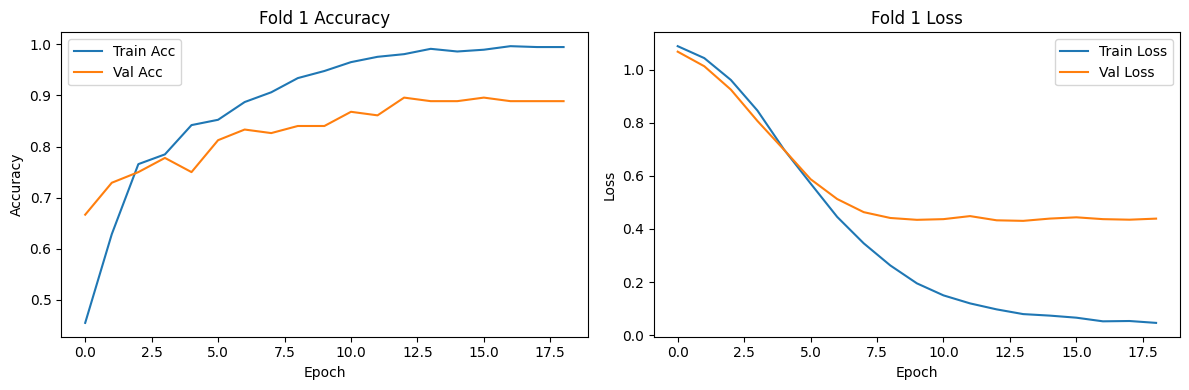


🔁 Fold 2
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.4316 - loss: 1.0905 - val_accuracy: 0.6875 - val_loss: 1.0573 - learning_rate: 5.0000e-04
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6852 - loss: 1.0458 - val_accuracy: 0.7639 - val_loss: 0.9903 - learning_rate: 5.0000e-04
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7465 - loss: 0.9687 - val_accuracy: 0.8264 - val_loss: 0.8845 - learning_rate: 5.0000e-04
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.7996 - loss: 0.8439 - val_accuracy: 0.8194 - val_loss: 0.7546 - learning_rate: 5.0000e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8316 - loss: 0.6976 - val_accuracy: 0.8264 - val_loss: 0.6197 - learning_rate: 5.0000e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.8533 - loss: 0.5694 - val_accuracy: 0.8194 - val_loss: 0.5226 - learning_rate: 5.0000e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8870 - loss: 0.4

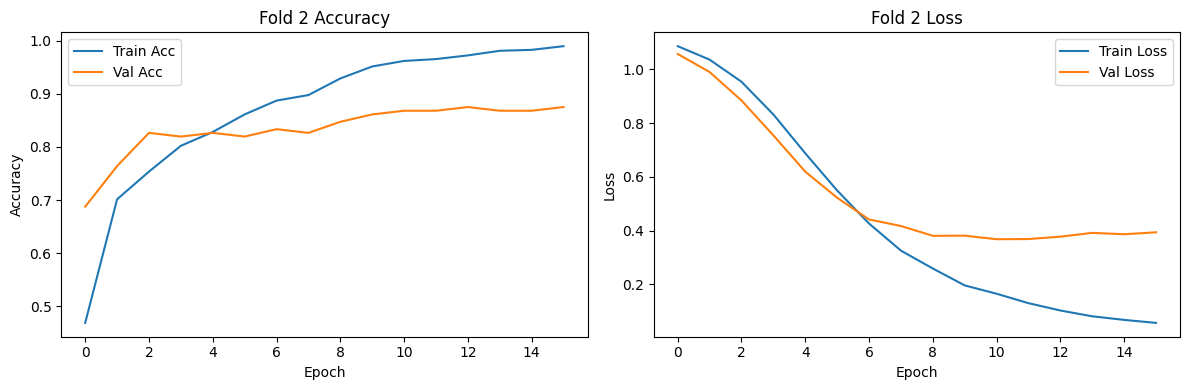


🔁 Fold 3
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.3981 - loss: 1.0906 - val_accuracy: 0.6806 - val_loss: 1.0510 - learning_rate: 5.0000e-04
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.7083 - loss: 1.0337 - val_accuracy: 0.7431 - val_loss: 0.9712 - learning_rate: 5.0000e-04
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.7665 - loss: 0.9355 - val_accuracy: 0.7569 - val_loss: 0.8541 - learning_rate: 5.0000e-04
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8060 - loss: 0.8019 - val_accuracy: 0.7847 - val_loss: 0.7196 - learning_rate: 5.0000e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.8499 - loss: 0.6620 - val_accuracy: 0.8194 - val_loss: 0.5901 - learning_rate: 5.0000e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.8665 - loss: 0.5361 - val_accuracy: 0.8681 - val_loss: 0.4741 - learning_rate: 5.0000e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8922 - loss: 0.4

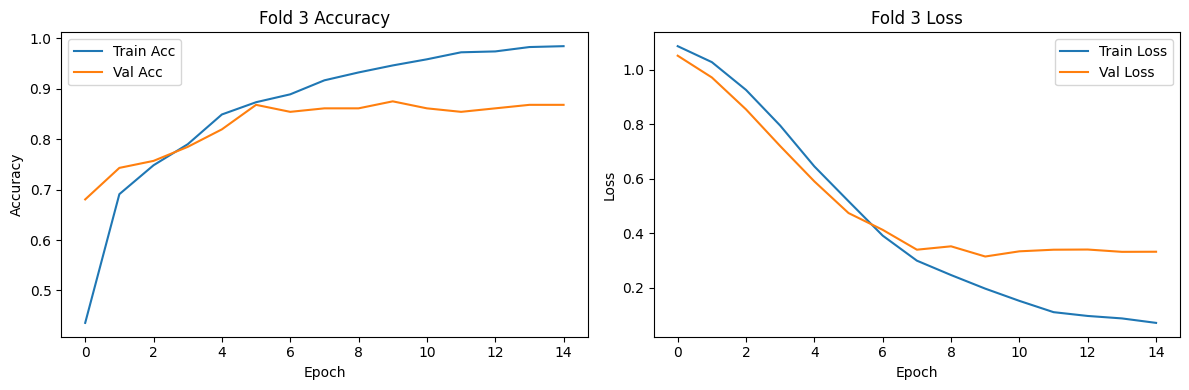


🔁 Fold 4
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.4415 - loss: 1.0904 - val_accuracy: 0.7083 - val_loss: 1.0529 - learning_rate: 5.0000e-04
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.6995 - loss: 1.0322 - val_accuracy: 0.7083 - val_loss: 0.9798 - learning_rate: 5.0000e-04
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7325 - loss: 0.9404 - val_accuracy: 0.7083 - val_loss: 0.8793 - learning_rate: 5.0000e-04
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7861 - loss: 0.8248 - val_accuracy: 0.7639 - val_loss: 0.7639 - learning_rate: 5.0000e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8154 - loss: 0.6839 - val_accuracy: 0.7986 - val_loss: 0.6544 - learning_rate: 5.0000e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8541 - loss: 0.5559 - val_accuracy: 0.8194 - val_loss: 0.5548 - learning_rate: 5.0000e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8746 - loss: 0.4

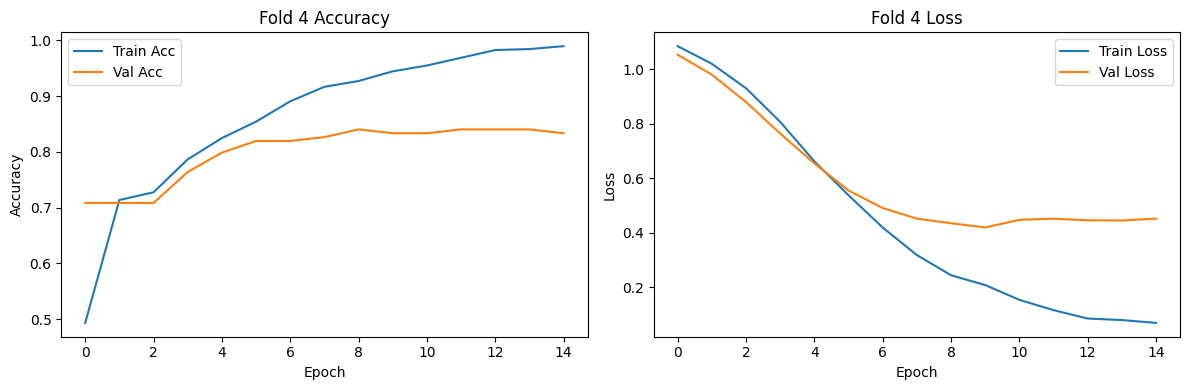


🔁 Fold 5
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.4050 - loss: 1.0919 - val_accuracy: 0.7361 - val_loss: 1.0536 - learning_rate: 5.0000e-04
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.7327 - loss: 1.0386 - val_accuracy: 0.7431 - val_loss: 0.9757 - learning_rate: 5.0000e-04
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.7576 - loss: 0.9473 - val_accuracy: 0.7778 - val_loss: 0.8587 - learning_rate: 5.0000e-04
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.7906 - loss: 0.8237 - val_accuracy: 0.8056 - val_loss: 0.7226 - learning_rate: 5.0000e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.8212 - loss: 0.6804 - val_accuracy: 0.8264 - val_loss: 0.5983 - learning_rate: 5.0000e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8416 - loss: 0.5629 - val_accuracy: 0.8403 - val_loss: 0.4838 - learning_rate: 5.0000e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.8692 - loss: 0.4

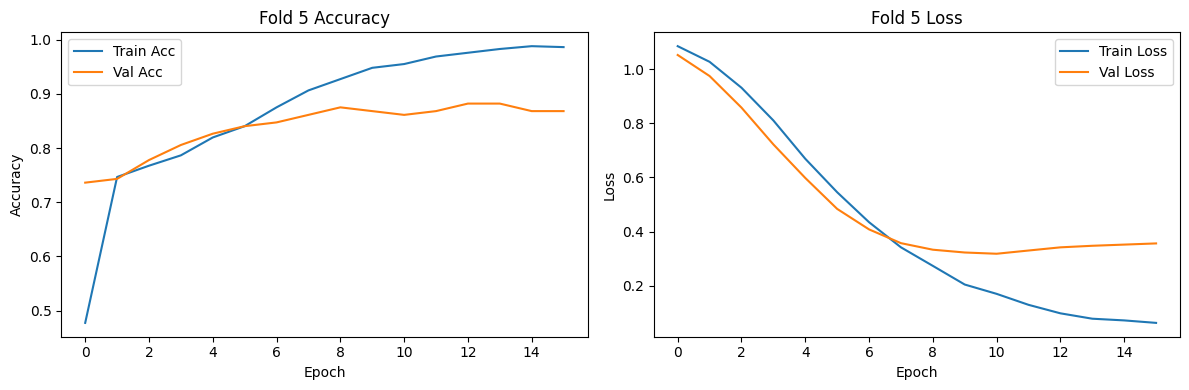


📊 Average Accuracy over 5 folds: 86.53%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 128
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")

# Patience


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4761 - loss: 1.0732 - val_accuracy: 0.6806 - val_loss: 0.9431 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7991 - loss: 0.8237 - val_accuracy: 0.7361 - val_loss: 0.6628 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8609 - loss: 0.4225 - val_accuracy: 0.7986 - val_loss: 0.4865 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9201 - loss: 0.2532 - val_accuracy: 0.8681 - val_loss: 0.4097 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9458 - loss: 0.1811 - val_accuracy: 0.8681 - val_loss: 0.4235 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9778 - loss: 0.1068 - val_accuracy: 0.8750 - val_loss: 0.4758 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.99

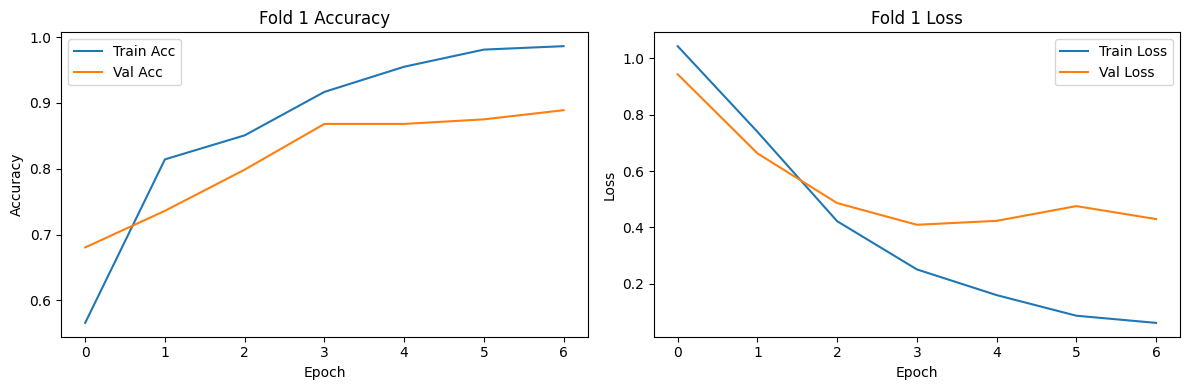


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4668 - loss: 1.0771 - val_accuracy: 0.7778 - val_loss: 0.9372 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7654 - loss: 0.8595 - val_accuracy: 0.8472 - val_loss: 0.6013 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8761 - loss: 0.4816 - val_accuracy: 0.8056 - val_loss: 0.4606 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9183 - loss: 0.2814 - val_accuracy: 0.8611 - val_loss: 0.3434 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9373 - loss: 0.1897 - val_accuracy: 0.8750 - val_loss: 0.3610 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9551 - loss: 0.1199 - val_accuracy: 0.8750 - val_loss: 0.3569 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.98

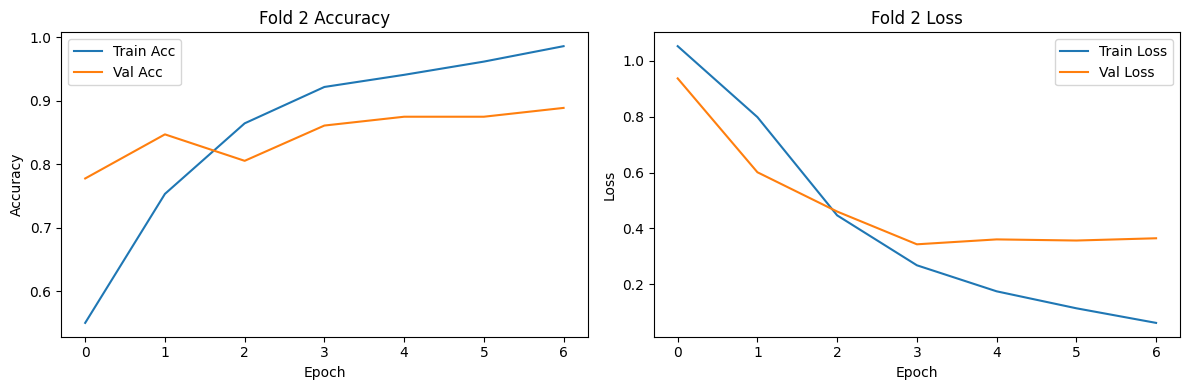


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4161 - loss: 1.0784 - val_accuracy: 0.7639 - val_loss: 0.9556 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8092 - loss: 0.8713 - val_accuracy: 0.8125 - val_loss: 0.6109 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8489 - loss: 0.5120 - val_accuracy: 0.8819 - val_loss: 0.3830 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8879 - loss: 0.2832 - val_accuracy: 0.8681 - val_loss: 0.3110 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9573 - loss: 0.1729 - val_accuracy: 0.8819 - val_loss: 0.3227 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9545 - loss: 0.1412 - val_accuracy: 0.8819 - val_loss: 0.3593 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.96

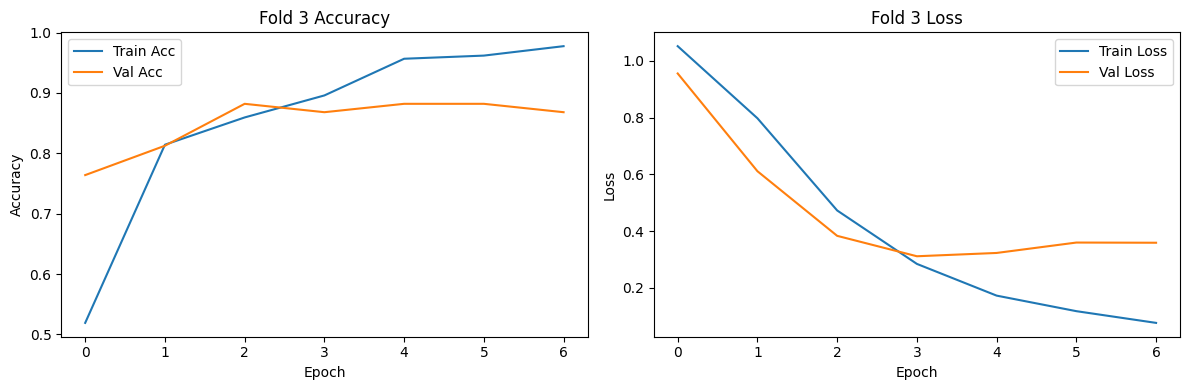


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4262 - loss: 1.0839 - val_accuracy: 0.7569 - val_loss: 0.9840 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7723 - loss: 0.8914 - val_accuracy: 0.7708 - val_loss: 0.6699 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8533 - loss: 0.5279 - val_accuracy: 0.8333 - val_loss: 0.4614 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8929 - loss: 0.3430 - val_accuracy: 0.8264 - val_loss: 0.4677 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9565 - loss: 0.1763 - val_accuracy: 0.8264 - val_loss: 0.4480 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9822 - loss: 0.1030 - val_accuracy: 0.8681 - val_loss: 0.4437 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.98

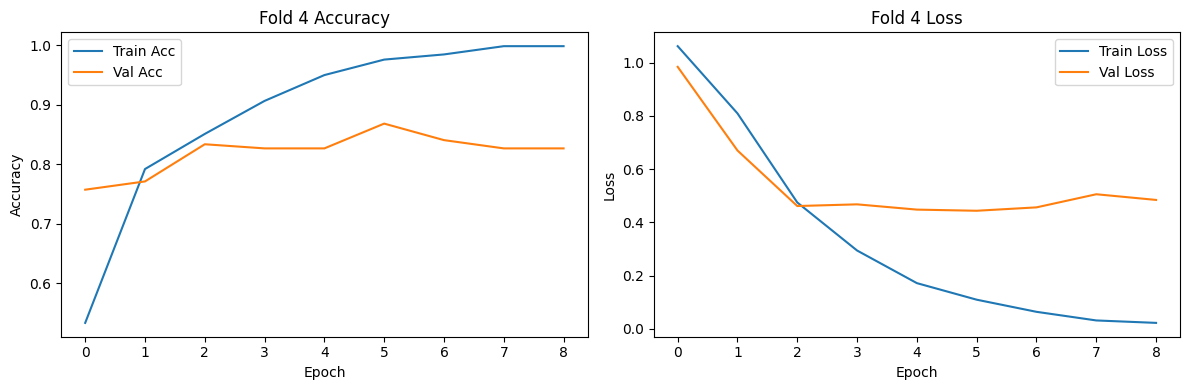


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4213 - loss: 1.0813 - val_accuracy: 0.7778 - val_loss: 0.9812 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8059 - loss: 0.9000 - val_accuracy: 0.8125 - val_loss: 0.6601 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8416 - loss: 0.5568 - val_accuracy: 0.8542 - val_loss: 0.3771 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9216 - loss: 0.2840 - val_accuracy: 0.8611 - val_loss: 0.3647 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9596 - loss: 0.1496 - val_accuracy: 0.8681 - val_loss: 0.3721 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9639 - loss: 0.0988 - val_accuracy: 0.8819 - val_loss: 0.3564 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.99

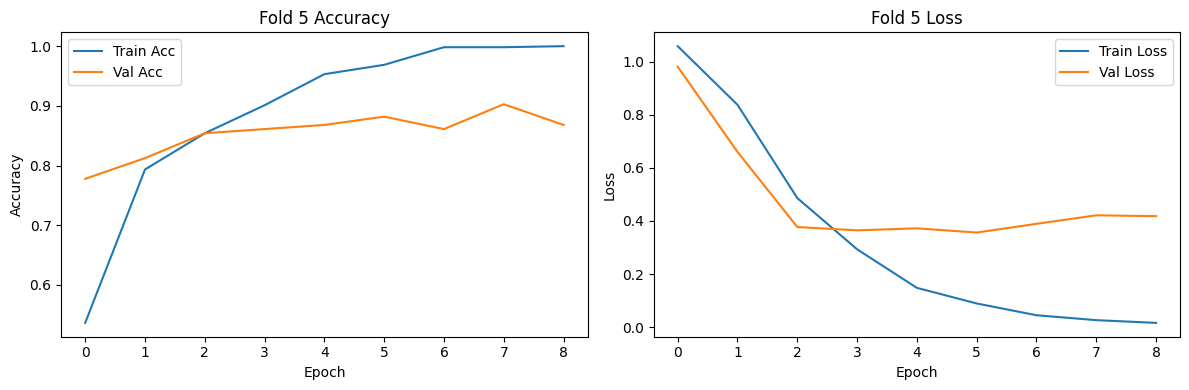


📊 Average Accuracy over 5 folds: 86.94%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4743 - loss: 1.0789 - val_accuracy: 0.7500 - val_loss: 0.9820 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7507 - loss: 0.8832 - val_accuracy: 0.7569 - val_loss: 0.6800 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8832 - loss: 0.4814 - val_accuracy: 0.7847 - val_loss: 0.5138 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9066 - loss: 0.2884 - val_accuracy: 0.8403 - val_loss: 0.4794 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9348 - loss: 0.1937 - val_accuracy: 0.8125 - val_loss: 0.5606 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9731 - loss: 0.1139 - val_accuracy: 0.8750 - val_loss: 0.4165 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.98

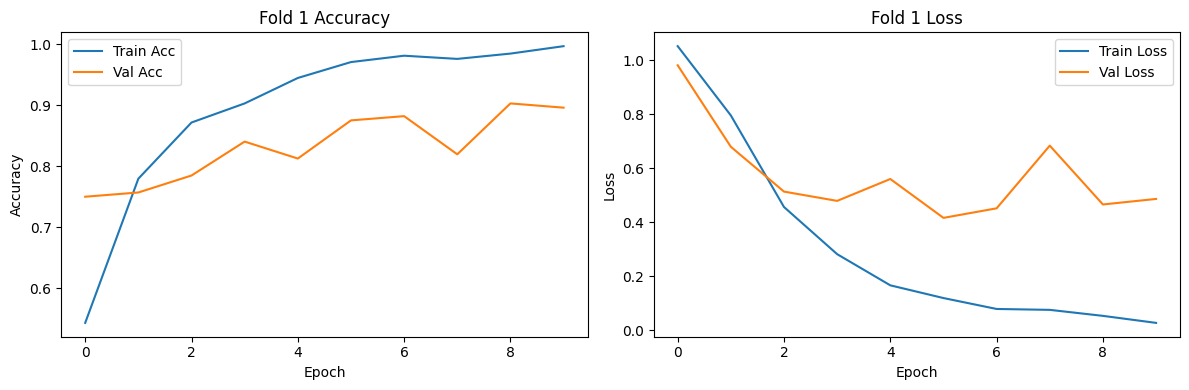


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4784 - loss: 1.0773 - val_accuracy: 0.7708 - val_loss: 0.9515 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7837 - loss: 0.8663 - val_accuracy: 0.7986 - val_loss: 0.5935 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8623 - loss: 0.4810 - val_accuracy: 0.8333 - val_loss: 0.4206 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8866 - loss: 0.3071 - val_accuracy: 0.8611 - val_loss: 0.3754 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9186 - loss: 0.2237 - val_accuracy: 0.8750 - val_loss: 0.3664 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9859 - loss: 0.0966 - val_accuracy: 0.8542 - val_loss: 0.3981 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.98

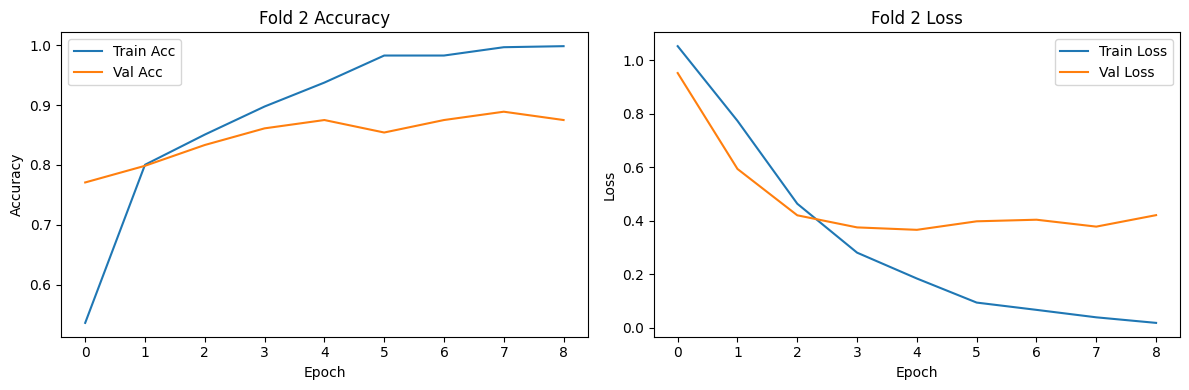


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4026 - loss: 1.0866 - val_accuracy: 0.7222 - val_loss: 0.9844 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7521 - loss: 0.9069 - val_accuracy: 0.7917 - val_loss: 0.6461 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8174 - loss: 0.5688 - val_accuracy: 0.8194 - val_loss: 0.4677 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8687 - loss: 0.3725 - val_accuracy: 0.8542 - val_loss: 0.3375 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9304 - loss: 0.2115 - val_accuracy: 0.8611 - val_loss: 0.3060 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9762 - loss: 0.1325 - val_accuracy: 0.8403 - val_loss: 0.4453 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.96

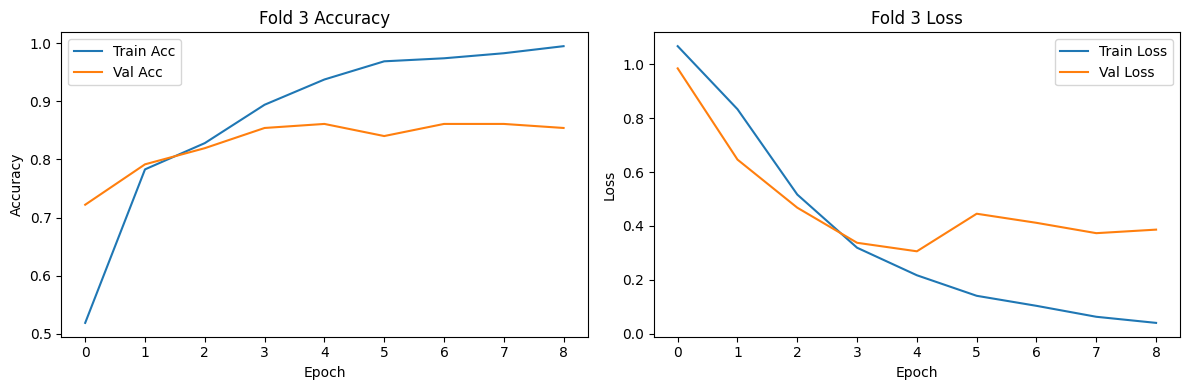


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5293 - loss: 1.0747 - val_accuracy: 0.7222 - val_loss: 0.9618 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7901 - loss: 0.8423 - val_accuracy: 0.7500 - val_loss: 0.6207 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8398 - loss: 0.4901 - val_accuracy: 0.8194 - val_loss: 0.4502 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9439 - loss: 0.2274 - val_accuracy: 0.8333 - val_loss: 0.4006 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9687 - loss: 0.1433 - val_accuracy: 0.8403 - val_loss: 0.4102 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9766 - loss: 0.0874 - val_accuracy: 0.8264 - val_loss: 0.4873 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.97

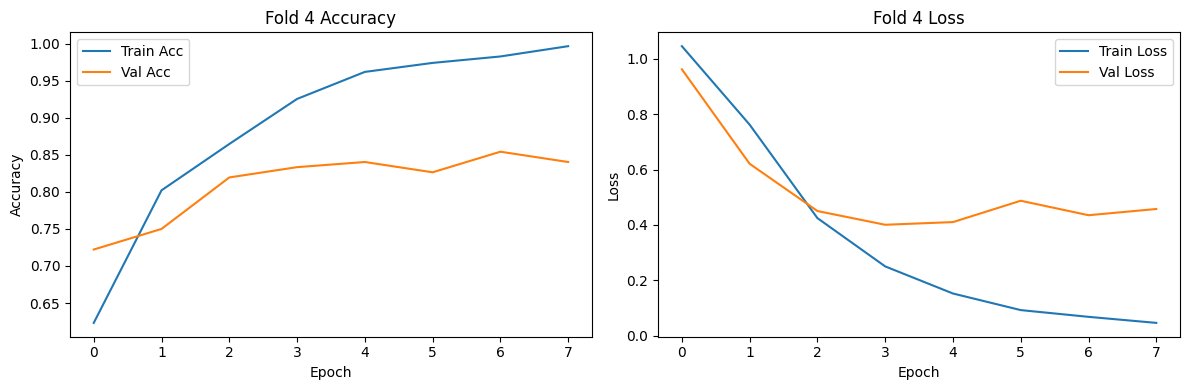


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4665 - loss: 1.0796 - val_accuracy: 0.7083 - val_loss: 0.9739 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7277 - loss: 0.8850 - val_accuracy: 0.8125 - val_loss: 0.6225 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8472 - loss: 0.5209 - val_accuracy: 0.8264 - val_loss: 0.4025 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9060 - loss: 0.3133 - val_accuracy: 0.8611 - val_loss: 0.3524 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9301 - loss: 0.2114 - val_accuracy: 0.8889 - val_loss: 0.3672 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9660 - loss: 0.1124 - val_accuracy: 0.8611 - val_loss: 0.3557 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.99

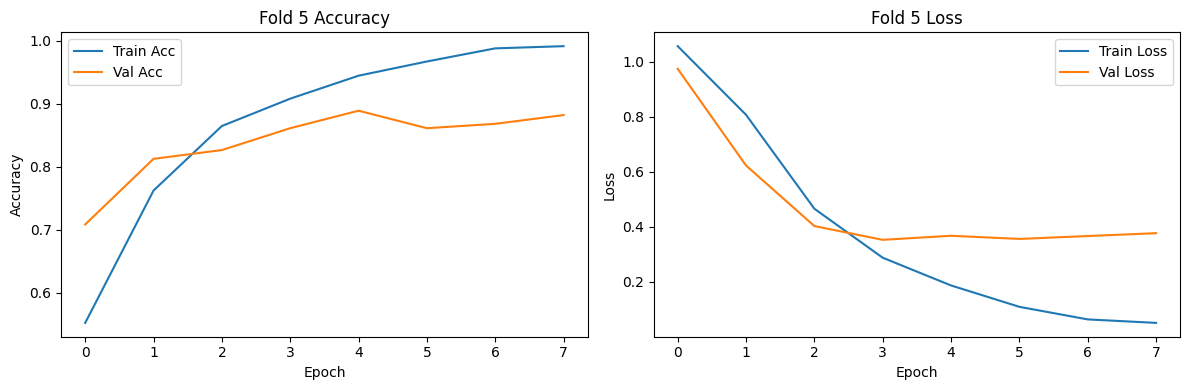


📊 Average Accuracy over 5 folds: 86.11%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4012 - loss: 1.0804 - val_accuracy: 0.6736 - val_loss: 0.9899 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7271 - loss: 0.8815 - val_accuracy: 0.7639 - val_loss: 0.7007 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8645 - loss: 0.5480 - val_accuracy: 0.8194 - val_loss: 0.5148 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9220 - loss: 0.2991 - val_accuracy: 0.8056 - val_loss: 0.4817 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9317 - loss: 0.2063 - val_accuracy: 0.8819 - val_loss: 0.4370 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9519 - loss: 0.1453 - val_accuracy: 0.8681 - val_loss: 0.4845 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.98

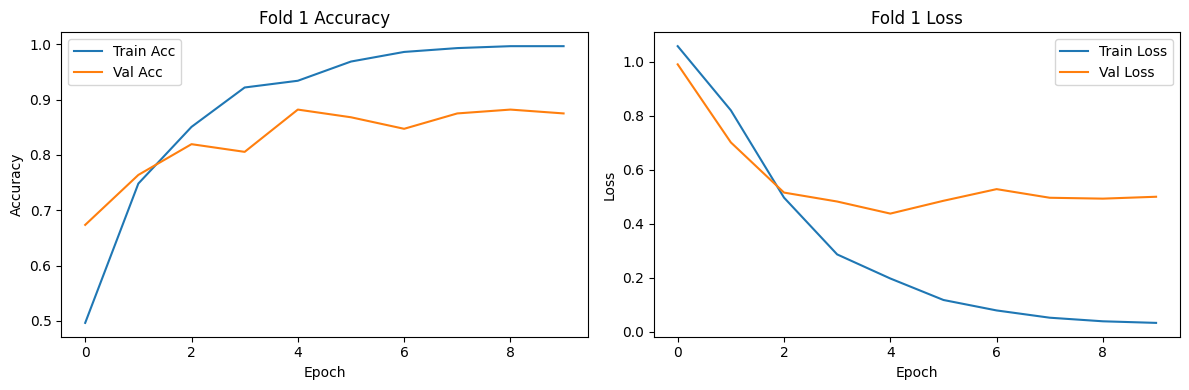


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4738 - loss: 1.0721 - val_accuracy: 0.7569 - val_loss: 0.9410 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8010 - loss: 0.8440 - val_accuracy: 0.7917 - val_loss: 0.6348 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8411 - loss: 0.5092 - val_accuracy: 0.8472 - val_loss: 0.4182 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9062 - loss: 0.2895 - val_accuracy: 0.8472 - val_loss: 0.4149 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9601 - loss: 0.1681 - val_accuracy: 0.8611 - val_loss: 0.4239 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9709 - loss: 0.1026 - val_accuracy: 0.8681 - val_loss: 0.3940 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.98

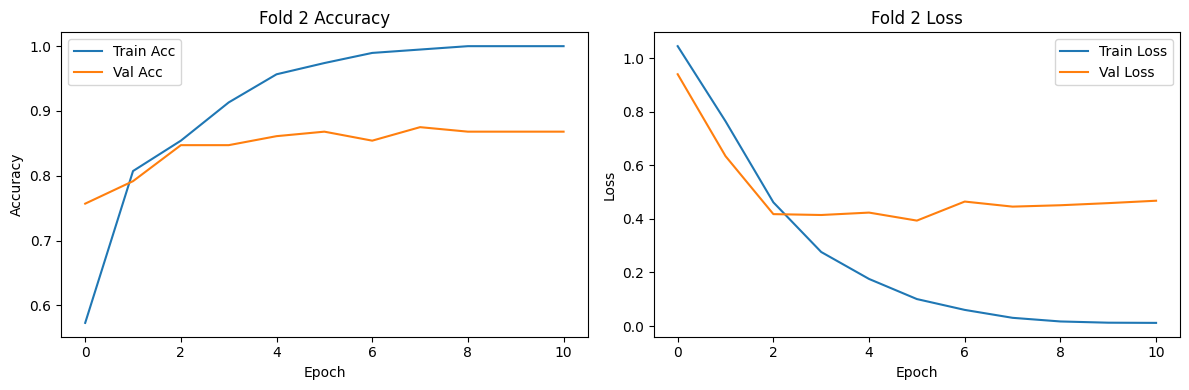


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4516 - loss: 1.0792 - val_accuracy: 0.8056 - val_loss: 0.9594 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7871 - loss: 0.8800 - val_accuracy: 0.8125 - val_loss: 0.6339 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8362 - loss: 0.5312 - val_accuracy: 0.8611 - val_loss: 0.3789 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8752 - loss: 0.3332 - val_accuracy: 0.8681 - val_loss: 0.3675 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9482 - loss: 0.2103 - val_accuracy: 0.8819 - val_loss: 0.3256 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9679 - loss: 0.1162 - val_accuracy: 0.8333 - val_loss: 0.4073 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.97

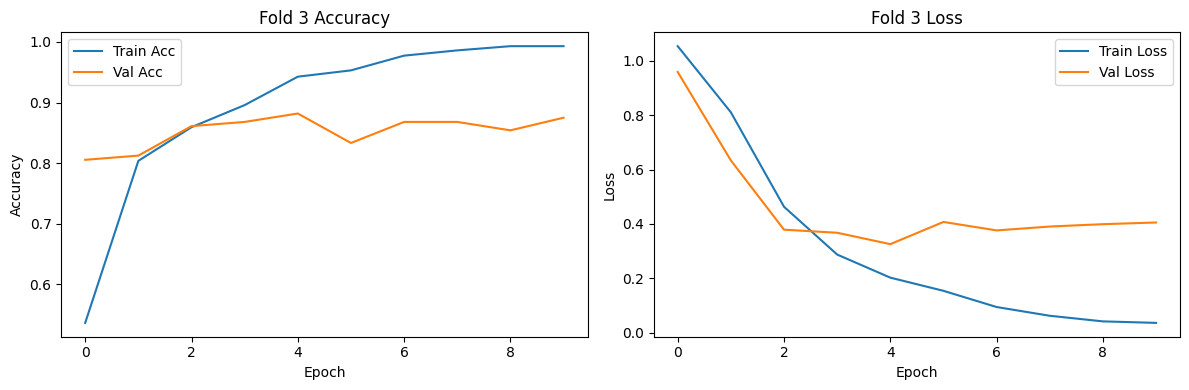


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4596 - loss: 1.0772 - val_accuracy: 0.7222 - val_loss: 0.9753 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8036 - loss: 0.8695 - val_accuracy: 0.8125 - val_loss: 0.6666 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8457 - loss: 0.4916 - val_accuracy: 0.7986 - val_loss: 0.4753 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9287 - loss: 0.2489 - val_accuracy: 0.8333 - val_loss: 0.4313 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9418 - loss: 0.1766 - val_accuracy: 0.8403 - val_loss: 0.4197 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9741 - loss: 0.0975 - val_accuracy: 0.8472 - val_loss: 0.4164 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.98

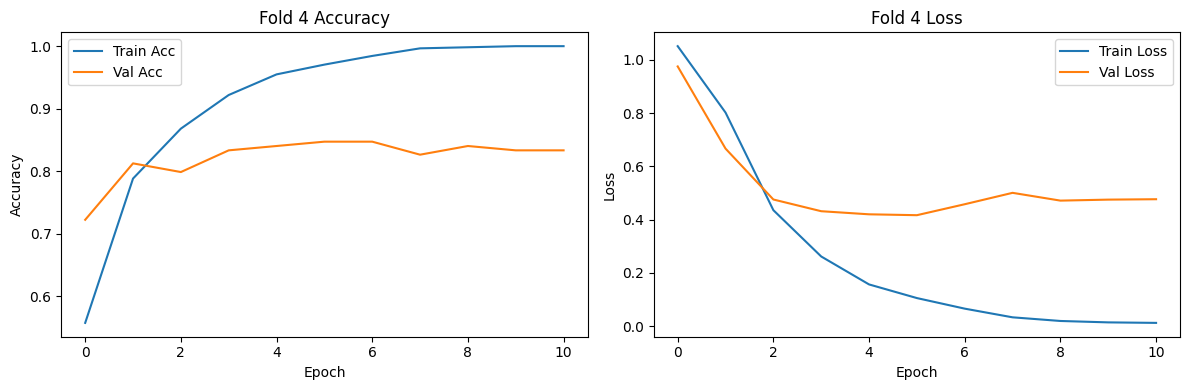


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4221 - loss: 1.0867 - val_accuracy: 0.7153 - val_loss: 0.9931 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7876 - loss: 0.8979 - val_accuracy: 0.8125 - val_loss: 0.6694 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8488 - loss: 0.5506 - val_accuracy: 0.8611 - val_loss: 0.4076 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9214 - loss: 0.2846 - val_accuracy: 0.8542 - val_loss: 0.3124 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9408 - loss: 0.1952 - val_accuracy: 0.8542 - val_loss: 0.3234 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9676 - loss: 0.1030 - val_accuracy: 0.8611 - val_loss: 0.3328 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.98

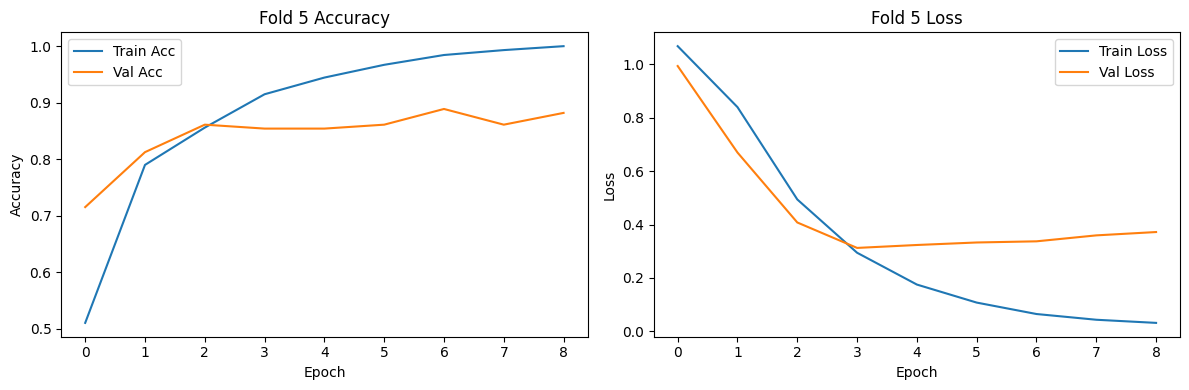


📊 Average Accuracy over 5 folds: 86.67%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4764 - loss: 1.0750 - val_accuracy: 0.7014 - val_loss: 0.9894 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7561 - loss: 0.8939 - val_accuracy: 0.7431 - val_loss: 0.7010 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8426 - loss: 0.5267 - val_accuracy: 0.8264 - val_loss: 0.4971 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9116 - loss: 0.2898 - val_accuracy: 0.8750 - val_loss: 0.4373 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9517 - loss: 0.1649 - val_accuracy: 0.8889 - val_loss: 0.4050 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9845 - loss: 0.0987 - val_accuracy: 0.8819 - val_loss: 0.4076 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.98

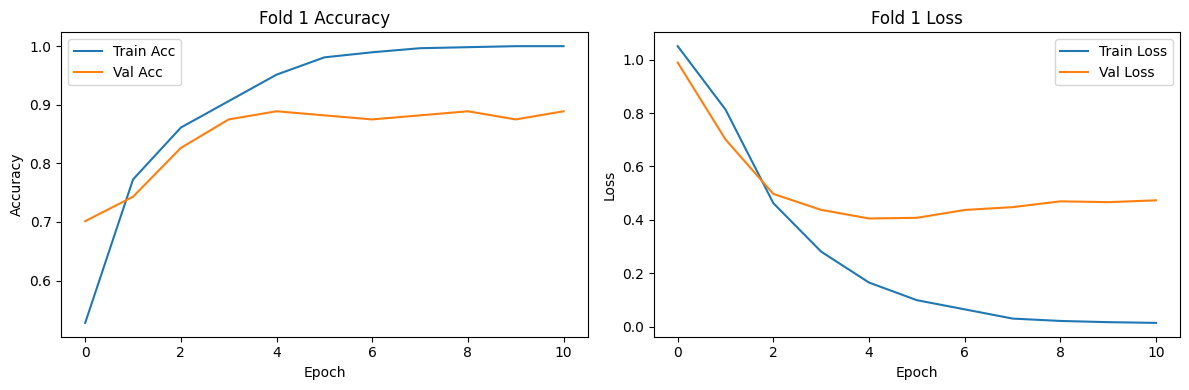


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4338 - loss: 1.0815 - val_accuracy: 0.7639 - val_loss: 0.9556 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7836 - loss: 0.8681 - val_accuracy: 0.7917 - val_loss: 0.6215 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8726 - loss: 0.4894 - val_accuracy: 0.8403 - val_loss: 0.4397 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9191 - loss: 0.2720 - val_accuracy: 0.8403 - val_loss: 0.4153 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9576 - loss: 0.1651 - val_accuracy: 0.8611 - val_loss: 0.3924 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9618 - loss: 0.1102 - val_accuracy: 0.8542 - val_loss: 0.4362 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.97

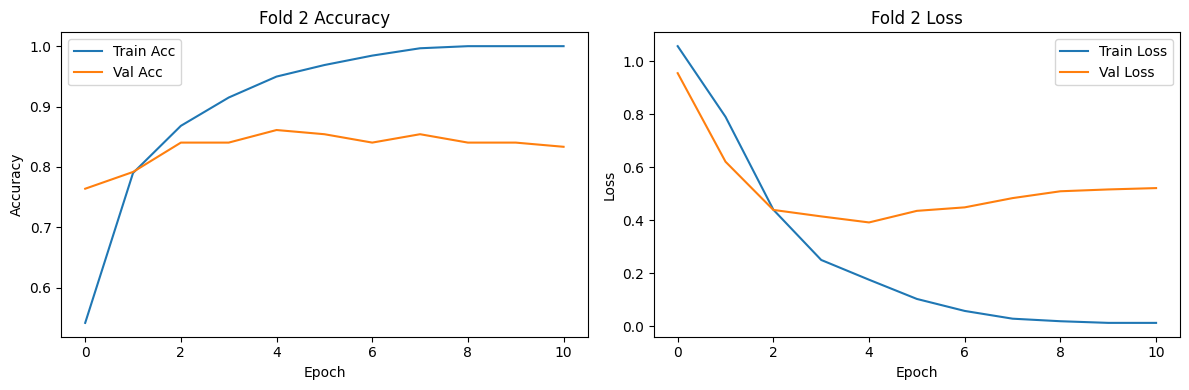


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4693 - loss: 1.0755 - val_accuracy: 0.6944 - val_loss: 0.9670 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7017 - loss: 0.8936 - val_accuracy: 0.7986 - val_loss: 0.6647 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8643 - loss: 0.5999 - val_accuracy: 0.8542 - val_loss: 0.4223 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8918 - loss: 0.3579 - val_accuracy: 0.8681 - val_loss: 0.3124 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9290 - loss: 0.2264 - val_accuracy: 0.8681 - val_loss: 0.2897 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9684 - loss: 0.1193 - val_accuracy: 0.8750 - val_loss: 0.3366 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.97

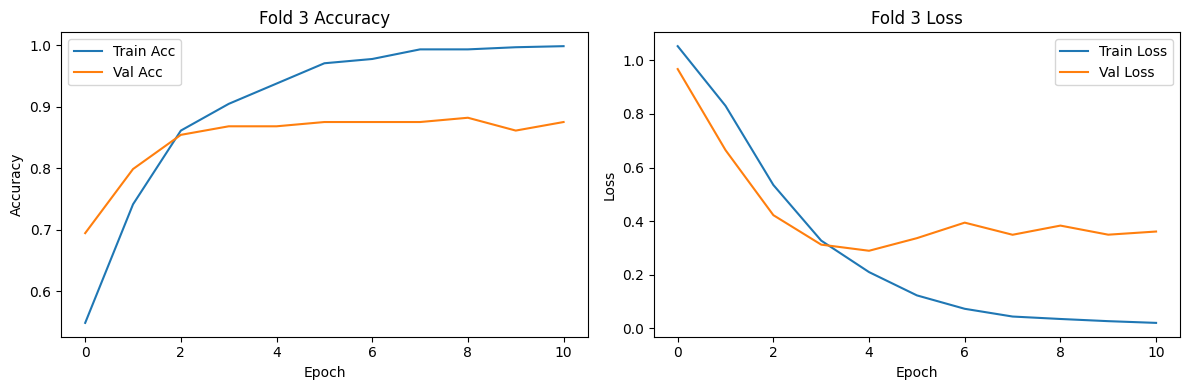


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4763 - loss: 1.0688 - val_accuracy: 0.6944 - val_loss: 0.9279 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7988 - loss: 0.8160 - val_accuracy: 0.8056 - val_loss: 0.6109 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8194 - loss: 0.4959 - val_accuracy: 0.8194 - val_loss: 0.4327 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9074 - loss: 0.2645 - val_accuracy: 0.8819 - val_loss: 0.3922 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9668 - loss: 0.1393 - val_accuracy: 0.8472 - val_loss: 0.4295 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9799 - loss: 0.0889 - val_accuracy: 0.8611 - val_loss: 0.4436 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.98

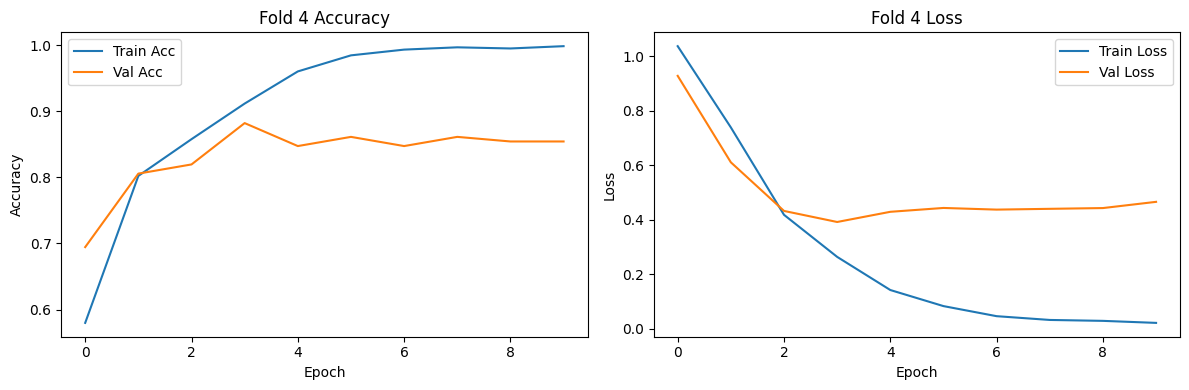


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4717 - loss: 1.0816 - val_accuracy: 0.7500 - val_loss: 0.9619 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7781 - loss: 0.8742 - val_accuracy: 0.7986 - val_loss: 0.6089 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8519 - loss: 0.5158 - val_accuracy: 0.8403 - val_loss: 0.3772 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9080 - loss: 0.2829 - val_accuracy: 0.8889 - val_loss: 0.3210 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9632 - loss: 0.1557 - val_accuracy: 0.8611 - val_loss: 0.3320 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9732 - loss: 0.1089 - val_accuracy: 0.8472 - val_loss: 0.3350 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.99

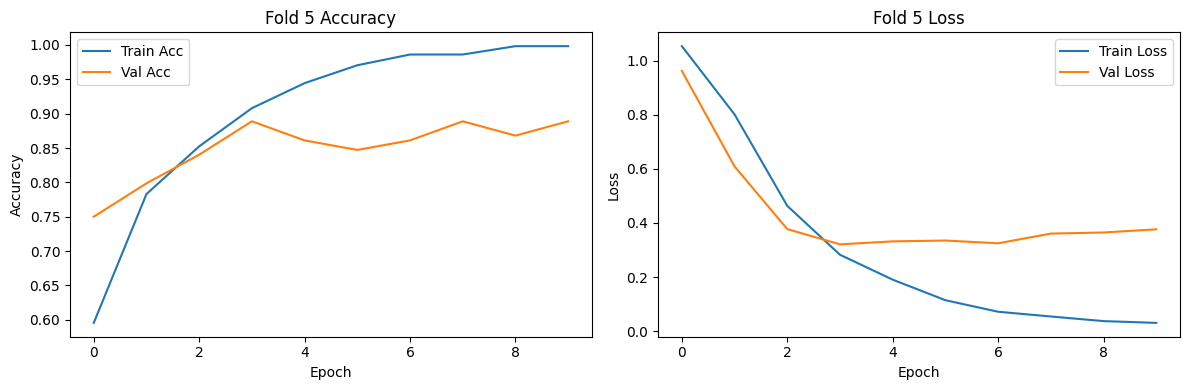


📊 Average Accuracy over 5 folds: 87.78%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4390 - loss: 1.0805 - val_accuracy: 0.7500 - val_loss: 0.9855 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7803 - loss: 0.8837 - val_accuracy: 0.7500 - val_loss: 0.6945 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8512 - loss: 0.5443 - val_accuracy: 0.7708 - val_loss: 0.5018 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9113 - loss: 0.2778 - val_accuracy: 0.7917 - val_loss: 0.5353 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9561 - loss: 0.1607 - val_accuracy: 0.8472 - val_loss: 0.4453 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9539 - loss: 0.1411 - val_accuracy: 0.8681 - val_loss: 0.4564 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.98

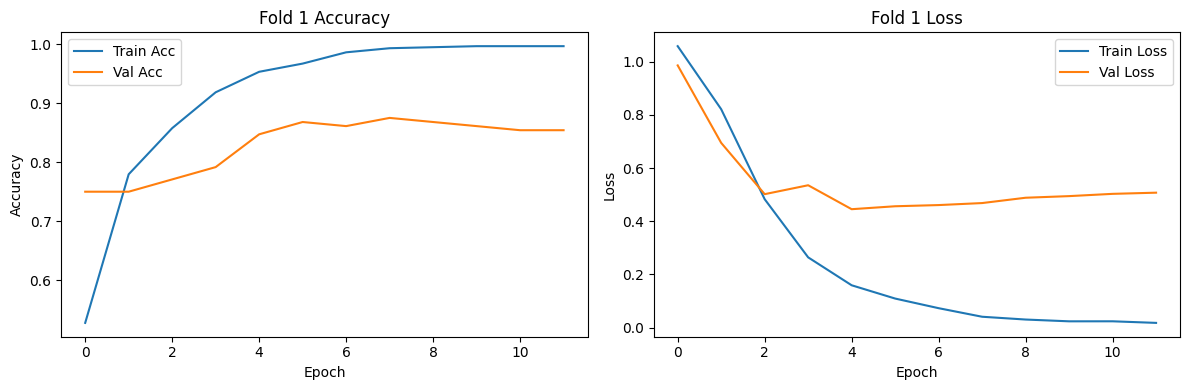


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3750 - loss: 1.0841 - val_accuracy: 0.7431 - val_loss: 0.9918 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7829 - loss: 0.9183 - val_accuracy: 0.8056 - val_loss: 0.6816 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8453 - loss: 0.5692 - val_accuracy: 0.8264 - val_loss: 0.4585 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9177 - loss: 0.2856 - val_accuracy: 0.8333 - val_loss: 0.4480 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9465 - loss: 0.1856 - val_accuracy: 0.8750 - val_loss: 0.3921 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9740 - loss: 0.1081 - val_accuracy: 0.8681 - val_loss: 0.3783 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.99

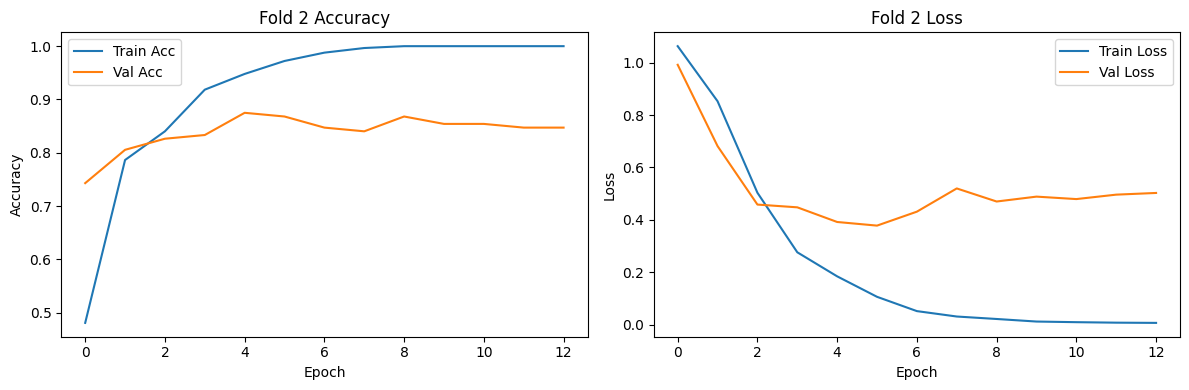


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4767 - loss: 1.0767 - val_accuracy: 0.7292 - val_loss: 0.9525 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7576 - loss: 0.8702 - val_accuracy: 0.7639 - val_loss: 0.6433 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8271 - loss: 0.5606 - val_accuracy: 0.8472 - val_loss: 0.3950 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9000 - loss: 0.3276 - val_accuracy: 0.8819 - val_loss: 0.3052 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9380 - loss: 0.2356 - val_accuracy: 0.8681 - val_loss: 0.2915 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9755 - loss: 0.1115 - val_accuracy: 0.8681 - val_loss: 0.3069 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.97

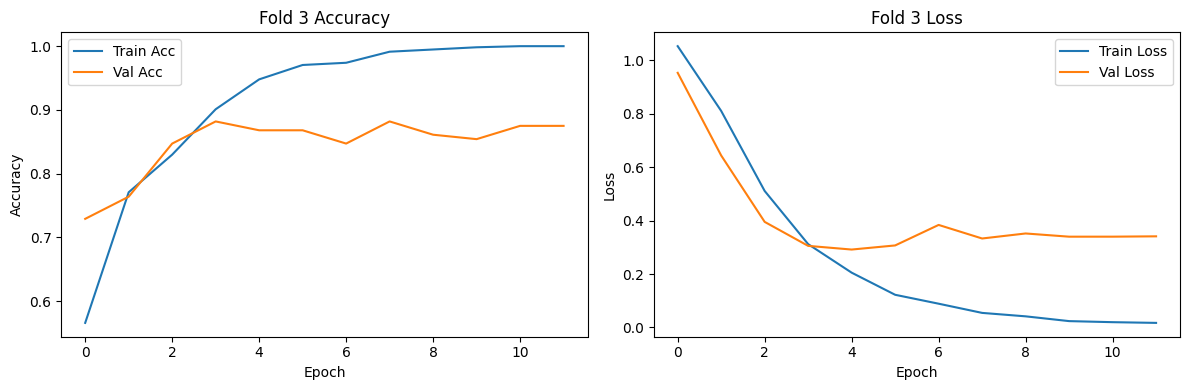


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5002 - loss: 1.0707 - val_accuracy: 0.7500 - val_loss: 0.9340 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8114 - loss: 0.8158 - val_accuracy: 0.7847 - val_loss: 0.5936 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8658 - loss: 0.4447 - val_accuracy: 0.8472 - val_loss: 0.4112 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9088 - loss: 0.2622 - val_accuracy: 0.8750 - val_loss: 0.3760 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9636 - loss: 0.1267 - val_accuracy: 0.8611 - val_loss: 0.4187 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9866 - loss: 0.1005 - val_accuracy: 0.8819 - val_loss: 0.4391 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.98

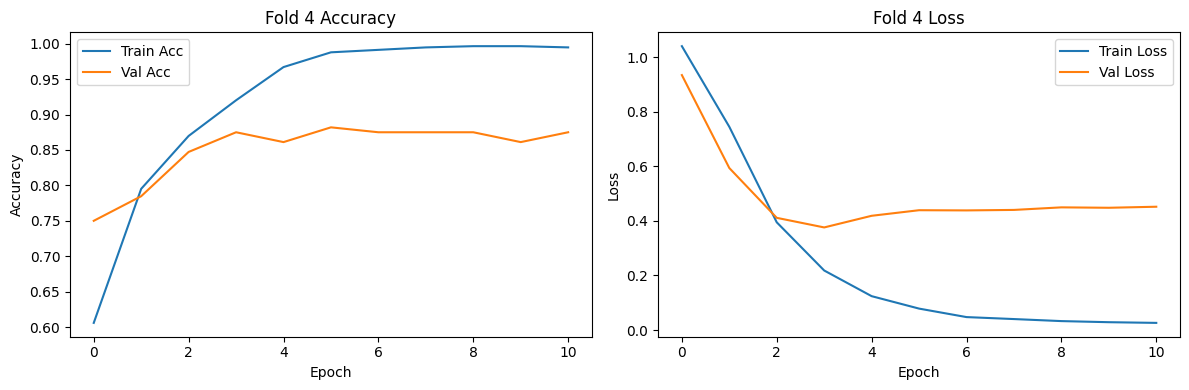


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4366 - loss: 1.0799 - val_accuracy: 0.7431 - val_loss: 0.9721 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7324 - loss: 0.8911 - val_accuracy: 0.8264 - val_loss: 0.6307 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8447 - loss: 0.5219 - val_accuracy: 0.8542 - val_loss: 0.3878 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8966 - loss: 0.3180 - val_accuracy: 0.8958 - val_loss: 0.3685 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9483 - loss: 0.1685 - val_accuracy: 0.8750 - val_loss: 0.3612 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9690 - loss: 0.1023 - val_accuracy: 0.8542 - val_loss: 0.3853 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.97

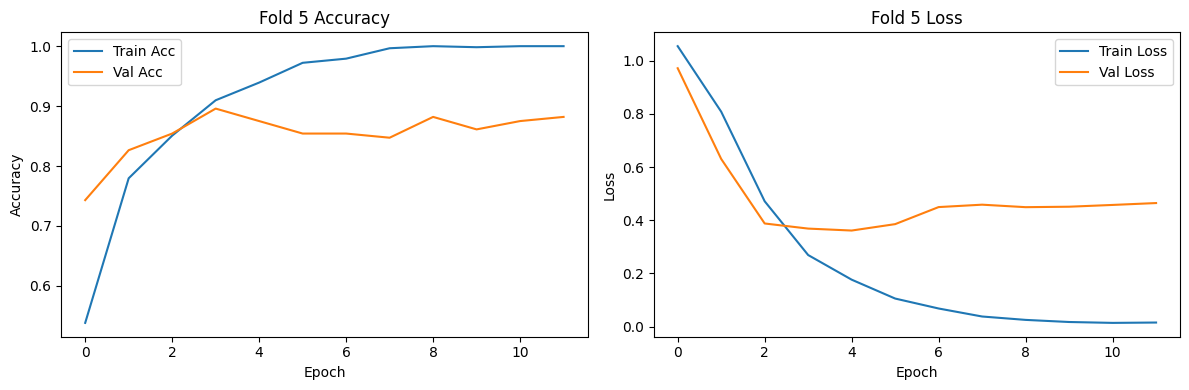


📊 Average Accuracy over 5 folds: 86.67%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")

# Confusion Matrix


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4922 - loss: 1.0743 - val_accuracy: 0.7222 - val_loss: 0.9528 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7729 - loss: 0.8399 - val_accuracy: 0.7639 - val_loss: 0.6324 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8602 - loss: 0.4764 - val_accuracy: 0.7917 - val_loss: 0.5286 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9233 - loss: 0.2560 - val_accuracy: 0.8403 - val_loss: 0.4690 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9469 - loss: 0.1789 - val_accuracy: 0.8819 - val_loss: 0.4589 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9585 - loss: 0.1377 - val_accuracy: 0.8611 - val_loss: 0.4981 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.98

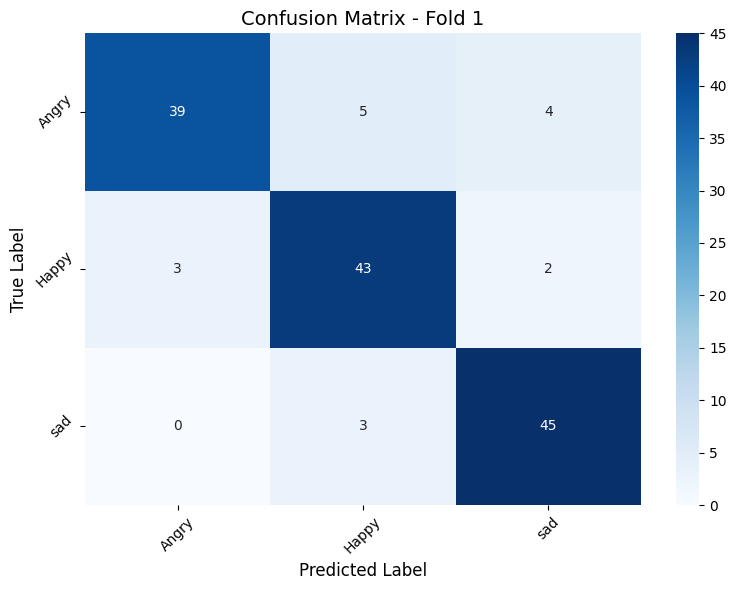

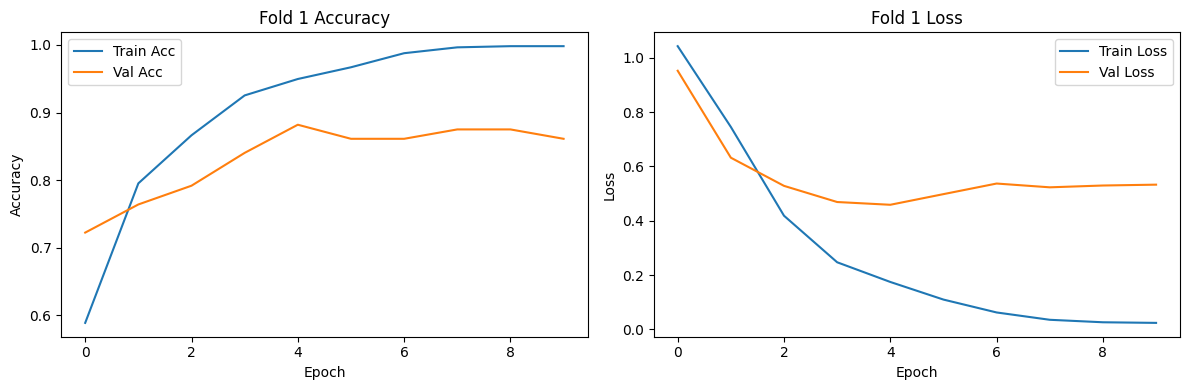


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5332 - loss: 1.0719 - val_accuracy: 0.7708 - val_loss: 0.9415 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8099 - loss: 0.8455 - val_accuracy: 0.7917 - val_loss: 0.6052 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8537 - loss: 0.4918 - val_accuracy: 0.8611 - val_loss: 0.4211 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9289 - loss: 0.2455 - val_accuracy: 0.8403 - val_loss: 0.3980 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9528 - loss: 0.1632 - val_accuracy: 0.8681 - val_loss: 0.3473 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9582 - loss: 0.1234 - val_accuracy: 0.8958 - val_loss: 0.3427 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.99

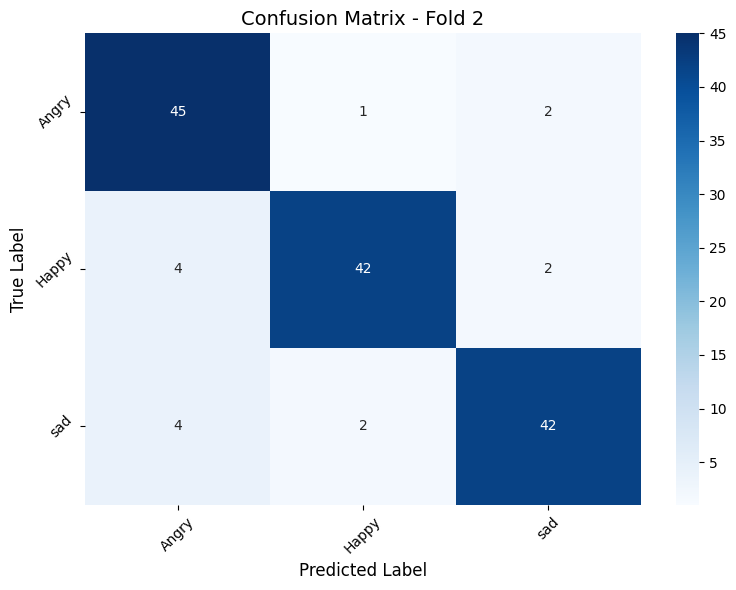

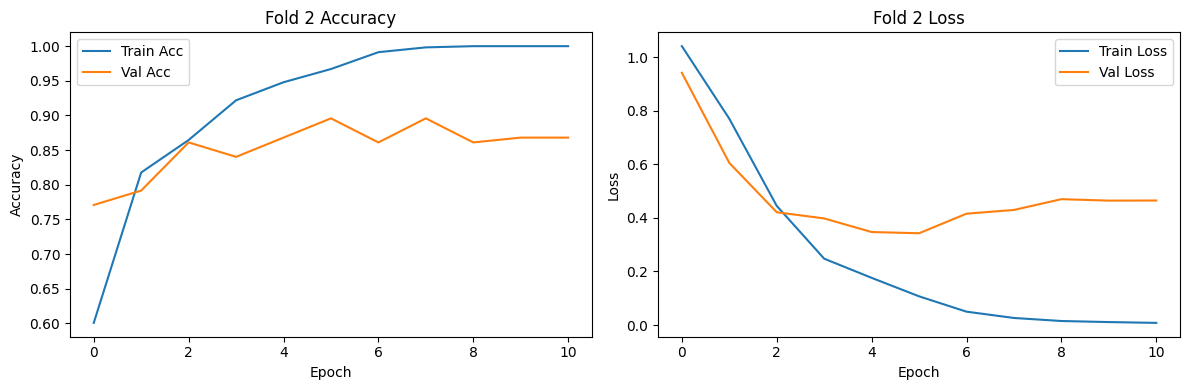


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4474 - loss: 1.0845 - val_accuracy: 0.6458 - val_loss: 0.9898 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6943 - loss: 0.9177 - val_accuracy: 0.7847 - val_loss: 0.6833 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8468 - loss: 0.5998 - val_accuracy: 0.8542 - val_loss: 0.4247 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9132 - loss: 0.3039 - val_accuracy: 0.8403 - val_loss: 0.3721 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9273 - loss: 0.2231 - val_accuracy: 0.8542 - val_loss: 0.3461 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9687 - loss: 0.1216 - val_accuracy: 0.8681 - val_loss: 0.3611 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.97

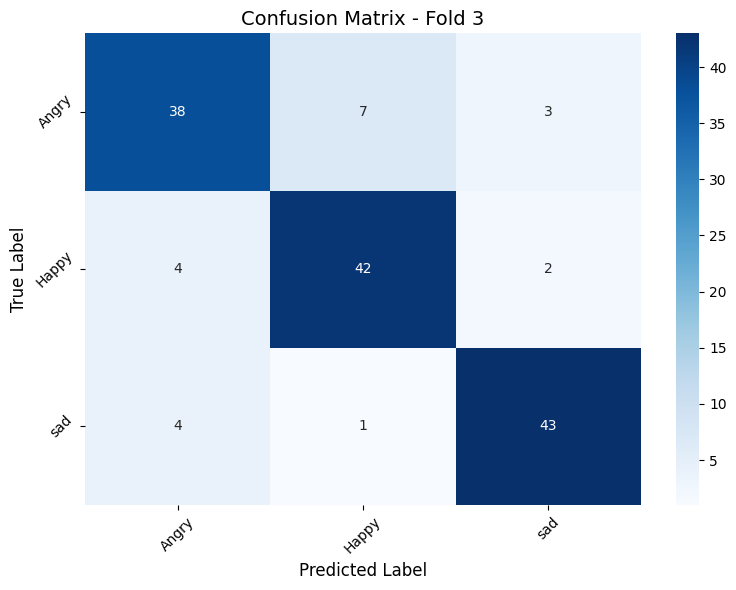

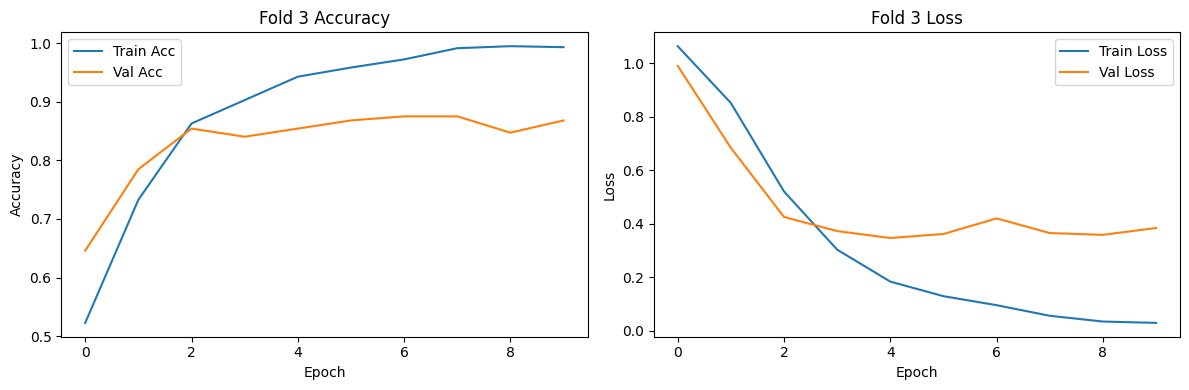


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4197 - loss: 1.0844 - val_accuracy: 0.7639 - val_loss: 1.0006 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7659 - loss: 0.9282 - val_accuracy: 0.7639 - val_loss: 0.7231 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8215 - loss: 0.6003 - val_accuracy: 0.8125 - val_loss: 0.4886 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8756 - loss: 0.3478 - val_accuracy: 0.8611 - val_loss: 0.4077 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9218 - loss: 0.2290 - val_accuracy: 0.8333 - val_loss: 0.4501 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9572 - loss: 0.1345 - val_accuracy: 0.8472 - val_loss: 0.4490 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.98

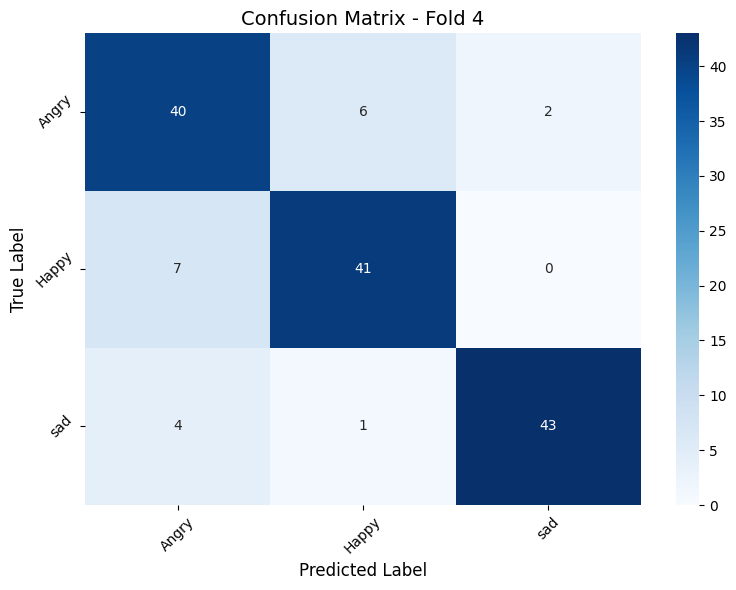

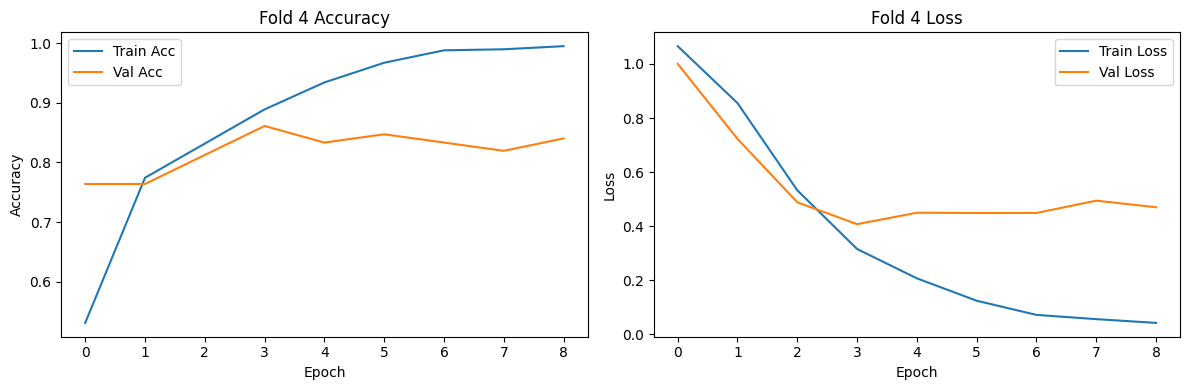


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4437 - loss: 1.0751 - val_accuracy: 0.8056 - val_loss: 0.9604 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7844 - loss: 0.8674 - val_accuracy: 0.8125 - val_loss: 0.6227 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8402 - loss: 0.5324 - val_accuracy: 0.8264 - val_loss: 0.4627 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9099 - loss: 0.3153 - val_accuracy: 0.8542 - val_loss: 0.3291 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9387 - loss: 0.1933 - val_accuracy: 0.8750 - val_loss: 0.3272 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9623 - loss: 0.1238 - val_accuracy: 0.8889 - val_loss: 0.3540 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.99

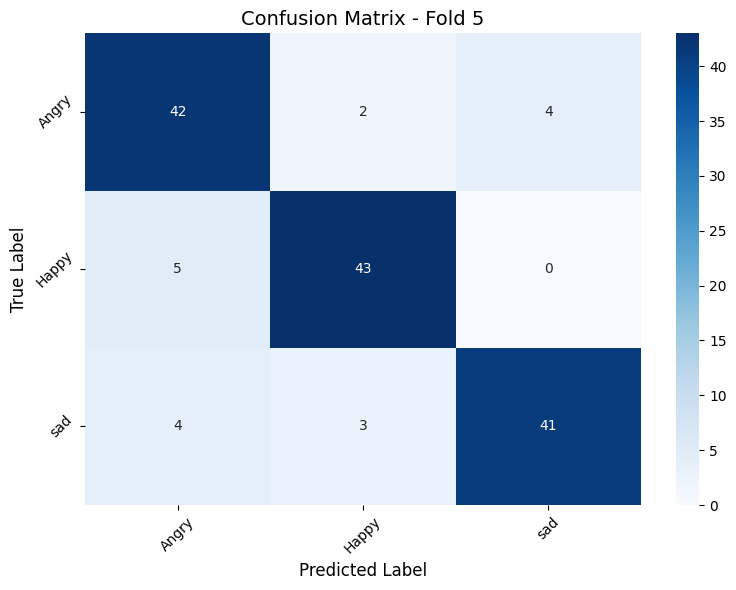

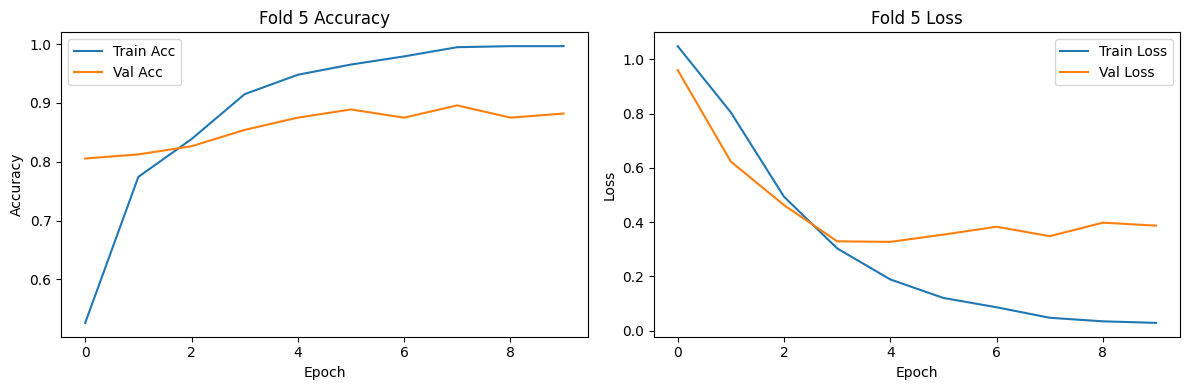


📊 Average Accuracy over 5 folds: 87.36%

🧾 5-Fold Averaged Classification Report:
              precision     recall   f1-score    support
Angry            0.8423     0.8500     0.8446         48
Happy            0.8733     0.8792     0.8758         48
sad              0.9116     0.8917     0.9010         48
                                                        
accuracy         0.8736     0.8736     0.8736        144
macro avg        0.8757     0.8736     0.8738        144
weighted avg     0.8757     0.8736     0.8738        144


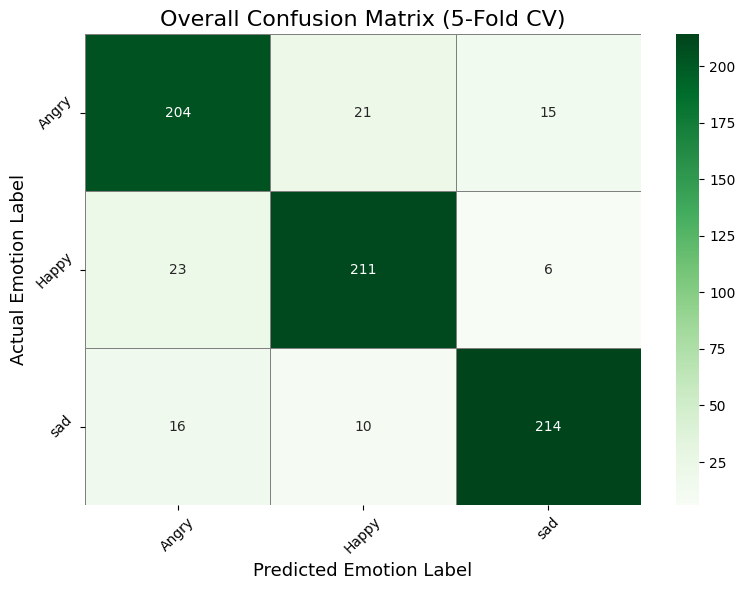


📋 Final Classification Report (All Folds Combined):
              precision    recall  f1-score   support

       Angry     0.8395    0.8500    0.8447       240
       Happy     0.8719    0.8792    0.8755       240
         sad     0.9106    0.8917    0.9011       240

    accuracy                         0.8736       720
   macro avg     0.8740    0.8736    0.8738       720
weighted avg     0.8740    0.8736    0.8738       720



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []
all_reports = []

# Collect for final confusion matrix
overall_y_true = []
overall_y_pred = []

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Predict
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Accuracy
    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")

    # Classification Report
    print("\n🧾 Classification Report:")
    report = classification_report(y_val, y_pred_classes, target_names=labels, digits=4, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))

    # Save for final confusion matrix
    overall_y_true.extend(y_val)
    overall_y_pred.extend(y_pred_classes)

    # Per-Fold Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - Fold {fold}", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Accuracy & Loss Plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    fold += 1

# 📊 Average Accuracy
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")

# 🧾 Average Classification Report
avg_report = {}
keys = all_reports[0].keys()
for key in keys:
    if isinstance(all_reports[0][key], dict):
        avg_report[key] = {}
        for metric in all_reports[0][key]:
            avg_report[key][metric] = np.mean([r[key][metric] for r in all_reports])
    else:
        avg_report[key] = np.mean([r[key] for r in all_reports])

print("\n🧾 5-Fold Averaged Classification Report:")
print("{:<12} {:>10} {:>10} {:>10} {:>10}".format("", "precision", "recall", "f1-score", "support"))
for label in labels:
    pr = avg_report[label]
    print("{:<12} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.0f}".format(
        label, pr["precision"], pr["recall"], pr["f1-score"], pr["support"]
    ))

print("{:<12} {:>10} {:>10} {:>10} {:>10}".format("", "", "", "", ""))
if "accuracy" in avg_report:
    print("{:<12} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.0f}".format(
        "accuracy", avg_report["accuracy"], avg_report["accuracy"], avg_report["accuracy"],
        sum(avg_report[label]["support"] for label in labels)
    ))

for avg_type in ["macro avg", "weighted avg"]:
    if avg_type in avg_report and isinstance(avg_report[avg_type], dict):
        pr = avg_report[avg_type]
        print("{:<12} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.0f}".format(
            avg_type, pr["precision"], pr["recall"], pr["f1-score"], pr["support"]
        ))

# ✅ Final Overall Confusion Matrix
cm_final = confusion_matrix(overall_y_true, overall_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels,
            linewidths=0.5, linecolor='gray')
plt.title("Overall Confusion Matrix (5-Fold CV)", fontsize=16)
plt.xlabel("Predicted Emotion Label", fontsize=13)
plt.ylabel("Actual Emotion Label", fontsize=13)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# 🧾 Final classification report (overall)
print("\n📋 Final Classification Report (All Folds Combined):")
print(classification_report(overall_y_true, overall_y_pred, target_names=labels, digits=4))


In [ ]:
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

# Excel Sheet Plotting

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DogEmotion_Accuracies_excel.xlsx to DogEmotion_Accuracies_excel.xlsx


# Read Excel Sheets from the Uploaded File

In [ ]:
import pandas as pd

# Load the Excel file
excel_path = '/content/DogEmotion_Accuracies_excel.xlsx'
xlsx = pd.ExcelFile(excel_path)

# Check available sheet names
print("Available Sheets:", xlsx.sheet_names)

# Load relevant sheets (you can change names as per your file)
accuracy_df = pd.read_excel(xlsx, sheet_name='MODEL ACCURACIES')
epochs_df = pd.read_excel(xlsx, sheet_name='EPOCHS')
batch_df = pd.read_excel(xlsx, sheet_name='BATCH SIZE')
lr_df = pd.read_excel(xlsx, sheet_name='LEARNING RATE')
patience_df = pd.read_excel(xlsx, sheet_name='PATIENCE')

Available Sheets: ['MODEL ACCURACIES', 'EPOCHS', 'LEARNING RATE', 'BATCH SIZE', 'PATIENCE']


# Plot Accuracy Comparison

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Excel file
xlsx_path = '/content/DogEmotion_Accuracies_excel.xlsx'
xlsx = pd.ExcelFile(xlsx_path)

# Display all sheet names
print("Available Sheets:", xlsx.sheet_names)

# Preview each sheet to identify its purpose
sheets_data = {}
for sheet in xlsx.sheet_names:
    print(f"\n📄 Sheet: {sheet}")
    df = pd.read_excel(xlsx, sheet_name=sheet)
    sheets_data[sheet] = df
    display(df.head())


Available Sheets: ['MODEL ACCURACIES', 'EPOCHS', 'LEARNING RATE', 'BATCH SIZE', 'PATIENCE']

📄 Sheet: MODEL ACCURACIES


Model  Accuracy  Precision  Recall  F1_Score
0     CNN+LSTM    0.8681     0.8728  0.8681    0.8679
1      CNN+RNN    0.8167     0.3305  0.3278    0.3252
2          CNN    0.8278     0.8395  0.8278    0.8238
3  MobileNetV2    0.8389     0.8224  0.8222    0.8216


📄 Sheet: EPOCHS


EPOCHS Unnamed: 1
0  Epochs   Accuracy
1      10     0.8639
2      20     0.8653
3      30     0.8653
4      40     0.8639


📄 Sheet: LEARNING RATE


LEARNING RATE Unnamed: 1
0  Learning Rate   Accuracy
1         0.0001     0.8542
2         0.0002     0.8639
3         0.0005     0.8667
4          0.001     0.8653


📄 Sheet: BATCH SIZE


BATCH SIZE Unnamed: 1
0  Batch Size   Accuracy
1           8     0.8361
2          16      0.875
3          32     0.8722
4          64     0.8736


📄 Sheet: PATIENCE


PATIENCE Unnamed: 1
0  Patience   Accuracy
1         3     0.8694
2         4     0.8611
3         5     0.8667
4         6     0.8778

In [ ]:
# Example: Adjust based on actual content from previous output
accuracy_df = sheets_data['MODEL ACCURACIES']
epochs_df = sheets_data['EPOCHS']
lr_df = sheets_data['LEARNING RATE']
batch_df = sheets_data['BATCH SIZE']
patience_df = sheets_data['PATIENCE']


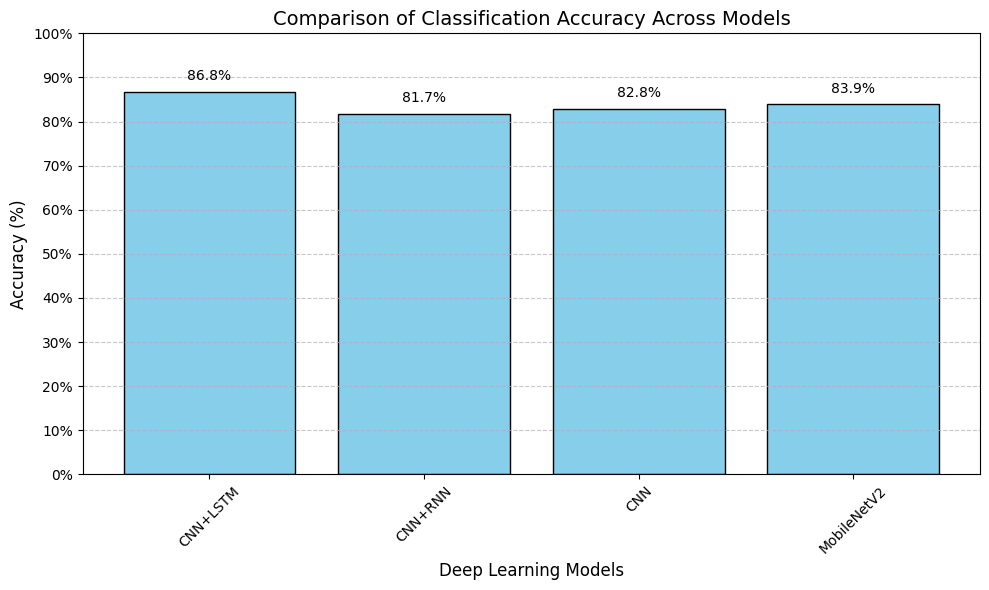

In [ ]:
import matplotlib.pyplot as plt

# Clean and prepare the data
accuracy_df = accuracy_df.dropna().copy()
accuracy_df['Model'] = accuracy_df['Model'].astype(str)

# Plot configuration
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracy_df['Model'], accuracy_df['Accuracy'], color='skyblue', edgecolor='black')

# Title and axis labels
plt.title('Comparison of Classification Accuracy Across Models', fontsize=14)
plt.xlabel('Deep Learning Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)

# Format y-axis as percentage
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1), labels=[f"{int(tick*100)}%" for tick in np.arange(0, 1.1, 0.1)])

# Grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.02,
             f"{height*100:.1f}%", ha='center', va='bottom', fontsize=10)

# Final layout adjustments
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


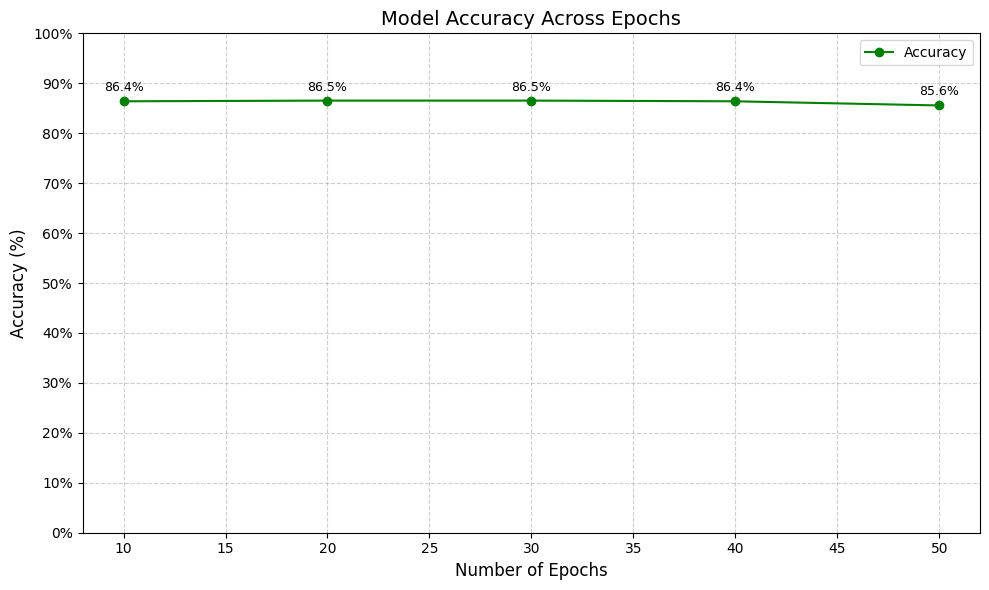

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Clean the data
epochs_df = sheets_data['EPOCHS'].iloc[1:].rename(columns={"EPOCHS": "Epochs", "Unnamed: 1": "Accuracy"})
epochs_df = epochs_df.dropna()
epochs_df.columns = epochs_df.columns.str.strip()
epochs_df["Epochs"] = pd.to_numeric(epochs_df["Epochs"], errors='coerce')
epochs_df["Accuracy"] = pd.to_numeric(epochs_df["Accuracy"], errors='coerce')
epochs_df = epochs_df.dropna()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_df["Epochs"], epochs_df["Accuracy"], marker='o', linestyle='-', color='green', label='Accuracy')

# Title and axis labels
plt.title("Model Accuracy Across Epochs", fontsize=14)
plt.xlabel("Number of Epochs", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)

# Y-axis in percentage
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1), labels=[f"{int(t*100)}%" for t in np.arange(0, 1.1, 0.1)])

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate points with exact accuracy
for x, y in zip(epochs_df["Epochs"], epochs_df["Accuracy"]):
    plt.text(x, y + 0.02, f"{y*100:.1f}%", ha='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()


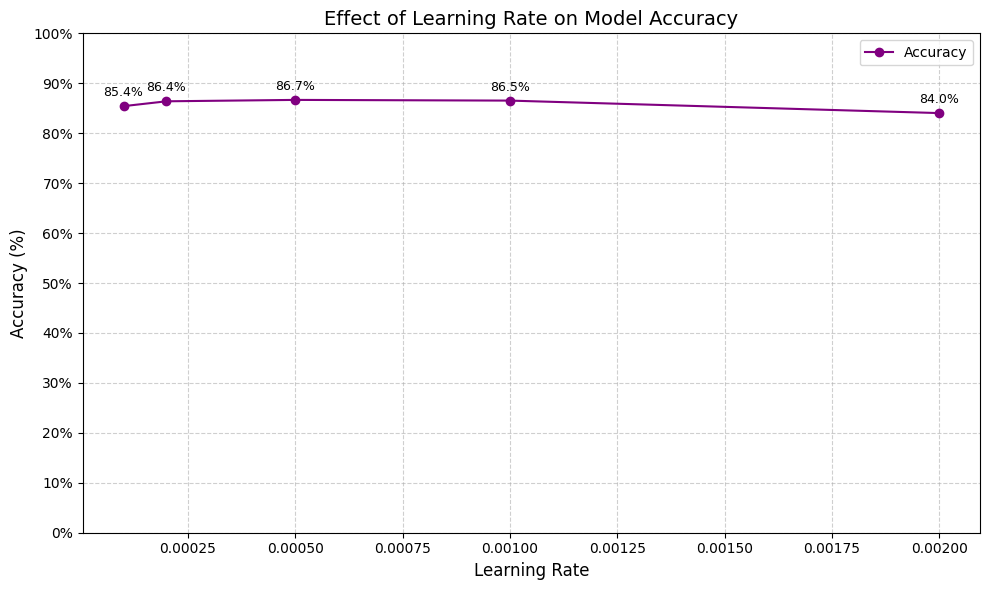

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Clean and prepare the data
lr_df = sheets_data['LEARNING RATE'].iloc[1:].rename(columns={"LEARNING RATE": "Learning Rate", "Unnamed: 1": "Accuracy"})
lr_df.columns = lr_df.columns.str.strip()
lr_df = lr_df.dropna()
lr_df["Learning Rate"] = pd.to_numeric(lr_df["Learning Rate"], errors='coerce')
lr_df["Accuracy"] = pd.to_numeric(lr_df["Accuracy"], errors='coerce')
lr_df = lr_df.dropna()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lr_df["Learning Rate"], lr_df["Accuracy"], marker='o', linestyle='-', color='purple', label='Accuracy')

# Title and axis labels
plt.title("Effect of Learning Rate on Model Accuracy", fontsize=14)
plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)

# Format Y-axis as percentage
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1), labels=[f"{int(t*100)}%" for t in np.arange(0, 1.1, 0.1)])

# Grid
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate each point with its value
for x, y in zip(lr_df["Learning Rate"], lr_df["Accuracy"]):
    plt.text(x, y + 0.02, f"{y*100:.1f}%", ha='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()


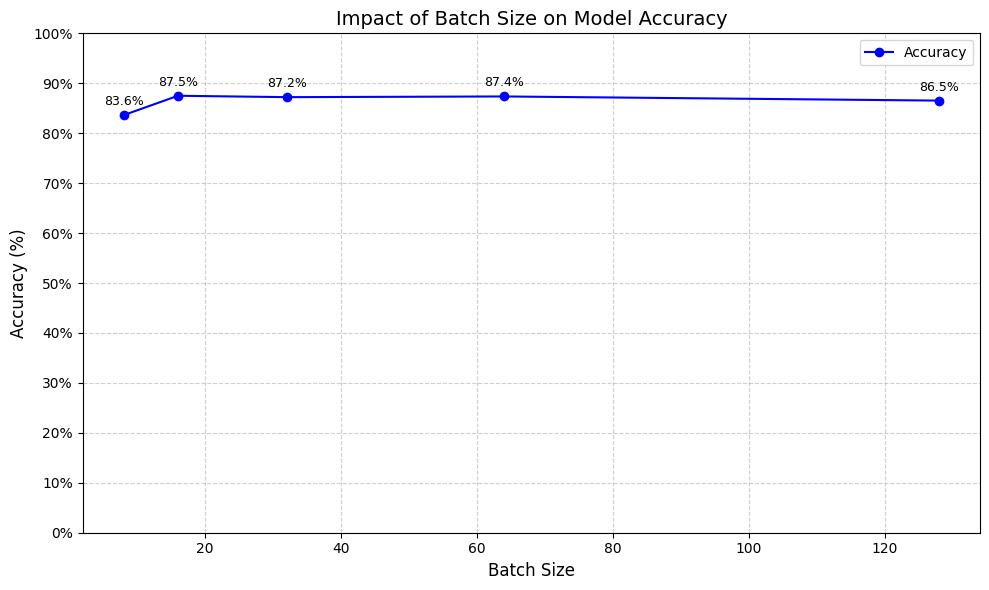

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Clean and prepare the data
batch_df = sheets_data['BATCH SIZE'].iloc[1:].rename(columns={
    "BATCH SIZE": "Batch Size",
    "Unnamed: 1": "Accuracy"
})

batch_df.columns = batch_df.columns.str.strip()
batch_df = batch_df.dropna()
batch_df["Batch Size"] = pd.to_numeric(batch_df["Batch Size"], errors='coerce')
batch_df["Accuracy"] = pd.to_numeric(batch_df["Accuracy"], errors='coerce')
batch_df = batch_df.dropna()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(batch_df["Batch Size"], batch_df["Accuracy"], marker='o', linestyle='-', color='blue', label='Accuracy')

# Title and axis labels
plt.title("Impact of Batch Size on Model Accuracy", fontsize=14)
plt.xlabel("Batch Size", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)

# Format Y-axis to show percentages
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1), labels=[f"{int(t * 100)}%" for t in np.arange(0, 1.1, 0.1)])

# Grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate points with accuracy values
for x, y in zip(batch_df["Batch Size"], batch_df["Accuracy"]):
    plt.text(x, y + 0.02, f"{y * 100:.1f}%", ha='center', fontsize=9)

# Legend and layout
plt.legend()
plt.tight_layout()
plt.show()


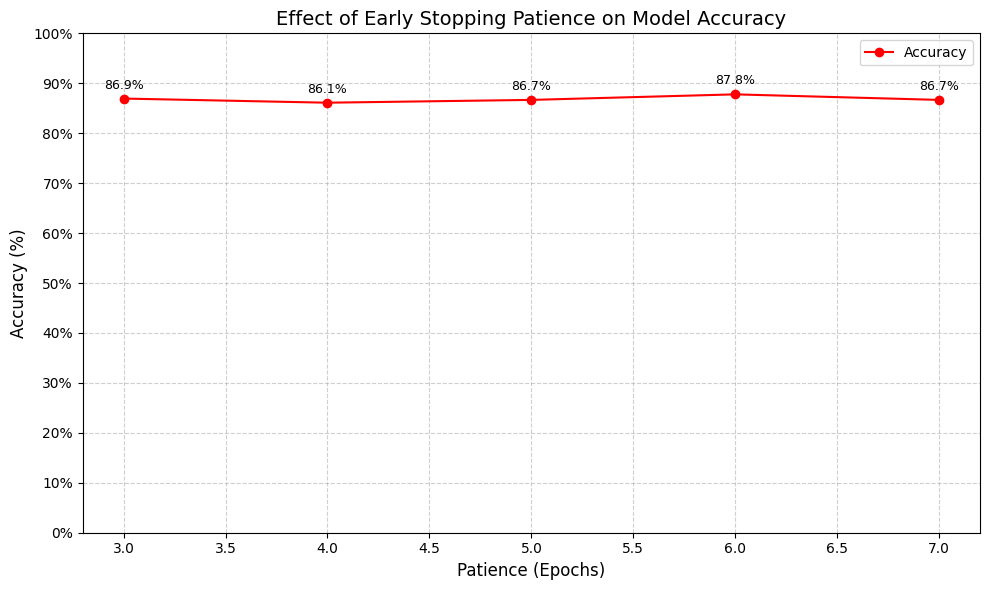

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Clean and prepare the data
patience_df = sheets_data['PATIENCE'].iloc[1:].rename(columns={
    "PATIENCE": "Patience",
    "Unnamed: 1": "Accuracy"
})

patience_df.columns = patience_df.columns.str.strip()
patience_df = patience_df.dropna()
patience_df["Patience"] = pd.to_numeric(patience_df["Patience"], errors='coerce')
patience_df["Accuracy"] = pd.to_numeric(patience_df["Accuracy"], errors='coerce')
patience_df = patience_df.dropna()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(patience_df["Patience"], patience_df["Accuracy"], marker='o', linestyle='-', color='red', label='Accuracy')

# Title and axis labels
plt.title("Effect of Early Stopping Patience on Model Accuracy", fontsize=14)
plt.xlabel("Patience (Epochs)", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)

# Format Y-axis as percentage
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1), labels=[f"{int(t * 100)}%" for t in np.arange(0, 1.1, 0.1)])

# Grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate points with accuracy values
for x, y in zip(patience_df["Patience"], patience_df["Accuracy"]):
    plt.text(x, y + 0.02, f"{y * 100:.1f}%", ha='center', fontsize=9)

# Legend and layout
plt.legend()
plt.tight_layout()
plt.show()
